## DCGAN Implementation

<code>[Статья "Unsupervised Representation Learning with Deep Convolutional GAN ICLR 2016"](https://arxiv.org/pdf/1511.06434.pdf)
</code>

In [1]:
import os
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set(style="darkgrid", font_scale=1.2)

In [3]:
!unzip pokemons_archive.zip -d ./pokemons

Archive:  pokemons_archive.zip
  inflating: ./pokemons/images/Abomasnow/0.jpg  
  inflating: ./pokemons/images/Abomasnow/1.jpg  
  inflating: ./pokemons/images/Abomasnow/2.jpg  
  inflating: ./pokemons/images/Abomasnow/3.jpg  
  inflating: ./pokemons/images/Abra/0.jpg  
  inflating: ./pokemons/images/Abra/1.jpg  
  inflating: ./pokemons/images/Abra/2.jpg  
  inflating: ./pokemons/images/Abra/3.jpg  
  inflating: ./pokemons/images/Absol/0.jpg  
  inflating: ./pokemons/images/Absol/1.jpg  
  inflating: ./pokemons/images/Absol/2.jpg  
  inflating: ./pokemons/images/Absol/3.jpg  
  inflating: ./pokemons/images/Accelgor/0.jpg  
  inflating: ./pokemons/images/Accelgor/1.jpg  
  inflating: ./pokemons/images/Aegislash/0.jpg  
  inflating: ./pokemons/images/Aegislash/1.jpg  
  inflating: ./pokemons/images/Aegislash/2.jpg  
  inflating: ./pokemons/images/Aegislash/3.jpg  
  inflating: ./pokemons/images/Aerodactyl/0.jpg  
  inflating: ./pokemons/images/Aerodactyl/1.jpg  
  inflating: ./pokemons/i

In [27]:
root_dir = "./images"
stats = [[0.5, 0.5, 0.5], [0.5, 0.5, 0.5]]
image_size = 64
batch_size = 512
input_channels = 3

In [28]:
dataset = ImageFolder(root=root_dir, transform=tt.Compose([    
    tt.Resize((image_size, image_size)),
    tt.ToTensor(),
    tt.Normalize(*stats)
]))

In [29]:
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

##### Show Faces from Dataset

In [30]:
def denorm_image(tensor):
    for ch in range(input_channels):
        tensor[ch] = tensor[ch] * stats[1][ch] + stats[0][ch]

    return tensor

In [31]:
def show_images(batch: torch.Tensor, image_count: int = 25, denorm=True):
    indices = np.random.choice(batch.shape[0], min(batch.shape[0], image_count), replace=False)
    images = []

    for index in indices:
        if denorm:
            images.append(denorm_image(batch[index].cpu().detach()))
        else:
            images.append(batch[index].clone().cpu().detach())

    fig, ax = plt.subplots(figsize=(12, 8))
    ax.set_xticks([])
    ax.set_yticks([])
    grid = make_grid(torch.stack(images), nrow=min(5, min(batch.shape[0], image_count))).permute(1, 2, 0)
    ax.imshow(grid)

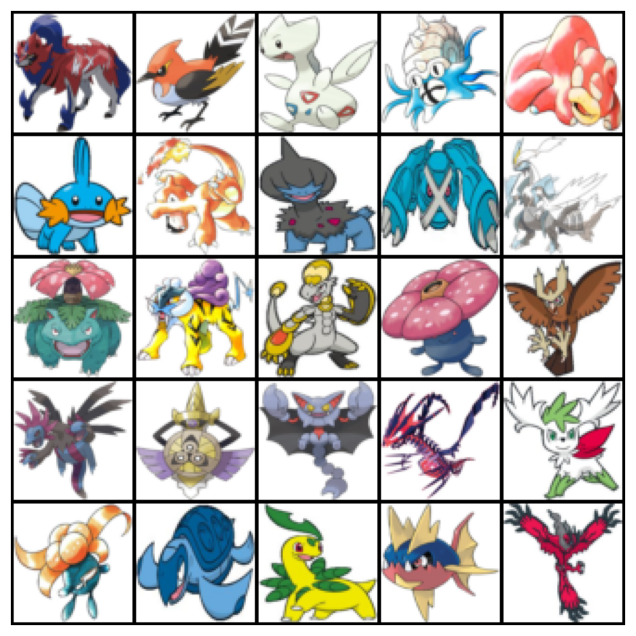

In [32]:
for (images, _) in dataloader:
    show_images(images)
    break

In [33]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader:
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [34]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [35]:
dataloader = DeviceDataLoader(dataloader, device)

## Model Architecture


In [36]:
from torchsummary import summary

![DCGAN Architecture](./model.png)

In [105]:
def get_discriminator():
    return nn.Sequential(
        # in: input_channels x 64 x 64
        nn.Conv2d(input_channels, 32, kernel_size=4, stride=1, padding="same", bias=False),        
        nn.LeakyReLU(0.2, inplace=True),
        # out: 32 x 64 x 64

        nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2, inplace=True),
        # out: 64 x 32 x 32

        nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2, inplace=True),
        # out: 128 x 16 x 16

        nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2, inplace=True),
        # out: 256 x 8 x 8

        nn.Conv2d(256, 256, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2, inplace=True),
        # out: 256 x 4 x 4

        nn.Conv2d(256, 1, kernel_size=4, stride=1, padding=0, bias=False),
        # out: 1 x 1 x 1

        nn.Flatten(),
        nn.Sigmoid()
    )

discriminator = get_discriminator()

In [106]:
discriminator = to_device(discriminator, device)
summary(discriminator, (input_channels, image_size, image_size))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 64, 64]          1,536
├─LeakyReLU: 1-2                         [-1, 32, 64, 64]          --
├─Conv2d: 1-3                            [-1, 64, 32, 32]          32,768
├─BatchNorm2d: 1-4                       [-1, 64, 32, 32]          128
├─LeakyReLU: 1-5                         [-1, 64, 32, 32]          --
├─Conv2d: 1-6                            [-1, 128, 16, 16]         131,072
├─BatchNorm2d: 1-7                       [-1, 128, 16, 16]         256
├─LeakyReLU: 1-8                         [-1, 128, 16, 16]         --
├─Conv2d: 1-9                            [-1, 256, 8, 8]           524,288
├─BatchNorm2d: 1-10                      [-1, 256, 8, 8]           512
├─LeakyReLU: 1-11                        [-1, 256, 8, 8]           --
├─Conv2d: 1-12                           [-1, 256, 4, 4]           1,048,576
├─BatchNorm2d: 1-13                      [-1, 256, 4, 4]  

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 64, 64]          1,536
├─LeakyReLU: 1-2                         [-1, 32, 64, 64]          --
├─Conv2d: 1-3                            [-1, 64, 32, 32]          32,768
├─BatchNorm2d: 1-4                       [-1, 64, 32, 32]          128
├─LeakyReLU: 1-5                         [-1, 64, 32, 32]          --
├─Conv2d: 1-6                            [-1, 128, 16, 16]         131,072
├─BatchNorm2d: 1-7                       [-1, 128, 16, 16]         256
├─LeakyReLU: 1-8                         [-1, 128, 16, 16]         --
├─Conv2d: 1-9                            [-1, 256, 8, 8]           524,288
├─BatchNorm2d: 1-10                      [-1, 256, 8, 8]           512
├─LeakyReLU: 1-11                        [-1, 256, 8, 8]           --
├─Conv2d: 1-12                           [-1, 256, 4, 4]           1,048,576
├─BatchNorm2d: 1-13                      [-1, 256, 4, 4]  

In [107]:
latent_size = 128

In [108]:
def get_generator():
    return nn.Sequential(
        # in: latent_size x 1 x 1

        nn.ConvTranspose2d(latent_size, 256, kernel_size=4, stride=1, padding=0, bias=False),
        nn.BatchNorm2d(256),
        nn.ReLU(True),
        # out: 256 x 4 x 4

        nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU(True),
        # out: 128 x 8 x 8

        nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(True),
        # out: 64 x 16 x 16

        nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(32),
        nn.ReLU(True),
        # out: 32 x 32 x 32

        nn.ConvTranspose2d(32, input_channels, kernel_size=4, stride=2, padding=1, bias=False),
        nn.Tanh()
        # out: input_channels x 128 x 128
    )

generator = get_generator()

In [109]:
generator = to_device(generator, device)
summary(generator, (latent_size, 1, 1))

Layer (type:depth-idx)                   Output Shape              Param #
├─ConvTranspose2d: 1-1                   [-1, 256, 4, 4]           524,288
├─BatchNorm2d: 1-2                       [-1, 256, 4, 4]           512
├─ReLU: 1-3                              [-1, 256, 4, 4]           --
├─ConvTranspose2d: 1-4                   [-1, 128, 8, 8]           524,288
├─BatchNorm2d: 1-5                       [-1, 128, 8, 8]           256
├─ReLU: 1-6                              [-1, 128, 8, 8]           --
├─ConvTranspose2d: 1-7                   [-1, 64, 16, 16]          131,072
├─BatchNorm2d: 1-8                       [-1, 64, 16, 16]          128
├─ReLU: 1-9                              [-1, 64, 16, 16]          --
├─ConvTranspose2d: 1-10                  [-1, 32, 32, 32]          32,768
├─BatchNorm2d: 1-11                      [-1, 32, 32, 32]          64
├─ReLU: 1-12                             [-1, 32, 32, 32]          --
├─ConvTranspose2d: 1-13                  [-1, 3, 64, 64]       

Layer (type:depth-idx)                   Output Shape              Param #
├─ConvTranspose2d: 1-1                   [-1, 256, 4, 4]           524,288
├─BatchNorm2d: 1-2                       [-1, 256, 4, 4]           512
├─ReLU: 1-3                              [-1, 256, 4, 4]           --
├─ConvTranspose2d: 1-4                   [-1, 128, 8, 8]           524,288
├─BatchNorm2d: 1-5                       [-1, 128, 8, 8]           256
├─ReLU: 1-6                              [-1, 128, 8, 8]           --
├─ConvTranspose2d: 1-7                   [-1, 64, 16, 16]          131,072
├─BatchNorm2d: 1-8                       [-1, 64, 16, 16]          128
├─ReLU: 1-9                              [-1, 64, 16, 16]          --
├─ConvTranspose2d: 1-10                  [-1, 32, 32, 32]          32,768
├─BatchNorm2d: 1-11                      [-1, 32, 32, 32]          64
├─ReLU: 1-12                             [-1, 32, 32, 32]          --
├─ConvTranspose2d: 1-13                  [-1, 3, 64, 64]       

#### Noise example

torch.Size([4, 3, 64, 64])


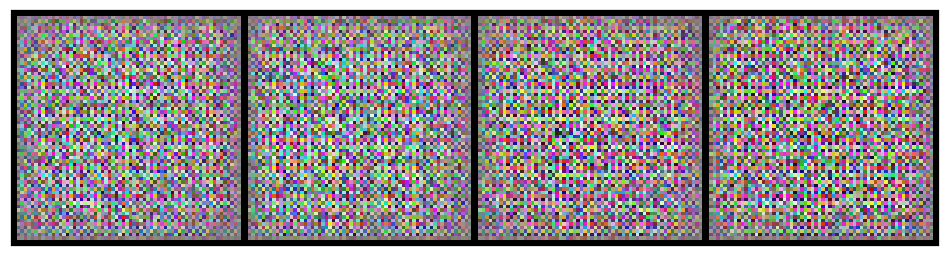

In [110]:
xb = torch.randn(4, latent_size, 1, 1).to(device)
fake_images = generator(xb).cpu()
print(fake_images.shape)
show_images(fake_images)

In [111]:
sample_dir = "generated"
os.makedirs(sample_dir, exist_ok=True)

In [112]:
checkpoints = "checkpoints"
os.makedirs(checkpoints, exist_ok=True)

In [113]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

In [114]:
def save_samples(index, latent_tensors, show=True, dir=sample_dir):
    fake_images = generator(latent_tensors)
    fake_fname = "generated-images-{0:0=4d}.png".format(index)
    save_image(denorm_image(fake_images), os.path.join(dir, fake_fname), nrow=8)
    print("Saving", fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

## Training

In [115]:
tmp_dir = "tmp"
os.makedirs(tmp_dir, exist_ok=True)

In [119]:
from datetime import datetime
from time import time
from copy import deepcopy

def fit(model, criterion, epochs, optimizer, start_idx=1, unrolled_steps=3):
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    now_s = datetime.now().strftime("%Y.%m.%d-%H:%M:%S")

    # Dir for generated images    
    generated_dir = os.path.join(sample_dir, "examples_" + now_s)
    os.makedirs(generated_dir, exist_ok=True)

    # Dir for checkpoints
    cur_checkpoints = os.path.join(checkpoints, "chpt_" + now_s)
    os.makedirs(cur_checkpoints, exist_ok=True)    

    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images, _ in tqdm(dataloader):            
            # Train discriminator
            # Clear discriminator gradients
            optimizer["discriminator"].zero_grad()

            # Pass real images through discriminator
            real_preds = model["discriminator"](real_images)
            real_targets = torch.ones(real_images.size(0), 1, device=device)
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()

            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # Pass fake images through discriminator
            fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # Update discriminator weights
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())

            # Clear generator gradients
            optimizer["generator"].zero_grad()                

            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # Try to fool the discriminator
            preds = model["discriminator"](fake_images)
            targets = torch.ones(batch_size, 1, device=device)
            loss_g = criterion["generator"](preds, targets)

            # Update generator weights
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())

        # Record losses & scores
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))

        # Log losses & scores (last batch)
        print(
            "Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
                epoch + 1,
                epochs,
                losses_g[-1],
                losses_d[-1],
                real_scores[-1],
                fake_scores[-1],
            )
        )
        
        # Save generated images
        save_samples(epoch + start_idx, fixed_latent, show=False, dir=generated_dir)

        # Save checkpoints
        # torch.save(model["discriminator"].state_dict(), os.path.join(cur_checkpoints, "discriminator_" + str(epoch + start_idx) + ".pt"))
        # torch.save(model["generator"].state_dict(), os.path.join(cur_checkpoints, "generator_" + str(epoch + start_idx) + ".pt"))

    return losses_g, losses_d, real_scores, fake_scores

In [120]:
model = {"discriminator": discriminator.to(device), "generator": generator.to(device)}

criterion = {"discriminator": nn.BCELoss(), "generator": nn.BCELoss()}

lr_d = 0.00005
lr_g = 0.00005
epochs = 1500

In [121]:
# Create optimizers
optimizer = {
    "discriminator": torch.optim.Adam(
        model["discriminator"].parameters(), lr=lr_d, betas=(0.5, 0.999), eps=0.00005
    ),
    "generator": torch.optim.Adam(
        model["generator"].parameters(), lr=lr_g, betas=(0.5, 0.999), eps=0.00005
    ),
}

In [122]:
history = fit(model, criterion, epochs, optimizer)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1/1500], loss_g: 1.4382, loss_d: 0.9809, real_score: 0.6086, fake_score: 0.3523
Saving generated-images-0001.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [2/1500], loss_g: 2.2053, loss_d: 0.3704, real_score: 0.8480, fake_score: 0.1777
Saving generated-images-0002.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [3/1500], loss_g: 2.6607, loss_d: 0.2159, real_score: 0.9171, fake_score: 0.1167
Saving generated-images-0003.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [4/1500], loss_g: 2.9419, loss_d: 0.1648, real_score: 0.9397, fake_score: 0.0937
Saving generated-images-0004.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [5/1500], loss_g: 3.1619, loss_d: 0.1414, real_score: 0.9496, fake_score: 0.0824
Saving generated-images-0005.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [6/1500], loss_g: 3.4817, loss_d: 0.1120, real_score: 0.9577, fake_score: 0.0636
Saving generated-images-0006.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [7/1500], loss_g: 3.7788, loss_d: 0.0905, real_score: 0.9671, fake_score: 0.0535
Saving generated-images-0007.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [8/1500], loss_g: 4.0577, loss_d: 0.0714, real_score: 0.9726, fake_score: 0.0412
Saving generated-images-0008.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [9/1500], loss_g: 4.2750, loss_d: 0.0618, real_score: 0.9771, fake_score: 0.0368
Saving generated-images-0009.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [10/1500], loss_g: 4.4964, loss_d: 0.0533, real_score: 0.9799, fake_score: 0.0316
Saving generated-images-0010.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [11/1500], loss_g: 4.7179, loss_d: 0.0445, real_score: 0.9829, fake_score: 0.0262
Saving generated-images-0011.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [12/1500], loss_g: 4.9034, loss_d: 0.0353, real_score: 0.9865, fake_score: 0.0210
Saving generated-images-0012.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [13/1500], loss_g: 5.0235, loss_d: 0.0299, real_score: 0.9887, fake_score: 0.0180
Saving generated-images-0013.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [14/1500], loss_g: 5.1651, loss_d: 0.0279, real_score: 0.9898, fake_score: 0.0172
Saving generated-images-0014.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [15/1500], loss_g: 5.2834, loss_d: 0.0246, real_score: 0.9910, fake_score: 0.0152
Saving generated-images-0015.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [16/1500], loss_g: 5.4463, loss_d: 0.0220, real_score: 0.9917, fake_score: 0.0134
Saving generated-images-0016.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [17/1500], loss_g: 5.5802, loss_d: 0.0192, real_score: 0.9927, fake_score: 0.0116
Saving generated-images-0017.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [18/1500], loss_g: 5.6703, loss_d: 0.0175, real_score: 0.9934, fake_score: 0.0107
Saving generated-images-0018.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [19/1500], loss_g: 5.8157, loss_d: 0.0166, real_score: 0.9936, fake_score: 0.0100
Saving generated-images-0019.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [20/1500], loss_g: 5.9572, loss_d: 0.0154, real_score: 0.9941, fake_score: 0.0093
Saving generated-images-0020.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [21/1500], loss_g: 6.0344, loss_d: 0.0147, real_score: 0.9941, fake_score: 0.0086
Saving generated-images-0021.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [22/1500], loss_g: 6.1175, loss_d: 0.0136, real_score: 0.9948, fake_score: 0.0082
Saving generated-images-0022.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [23/1500], loss_g: 6.0946, loss_d: 0.0121, real_score: 0.9952, fake_score: 0.0071
Saving generated-images-0023.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [24/1500], loss_g: 6.1523, loss_d: 0.0115, real_score: 0.9954, fake_score: 0.0068
Saving generated-images-0024.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [25/1500], loss_g: 6.1954, loss_d: 0.0108, real_score: 0.9957, fake_score: 0.0064
Saving generated-images-0025.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [26/1500], loss_g: 6.2649, loss_d: 0.0100, real_score: 0.9959, fake_score: 0.0058
Saving generated-images-0026.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [27/1500], loss_g: 6.3034, loss_d: 0.0099, real_score: 0.9962, fake_score: 0.0060
Saving generated-images-0027.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [28/1500], loss_g: 6.4085, loss_d: 0.0103, real_score: 0.9958, fake_score: 0.0060
Saving generated-images-0028.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [29/1500], loss_g: 6.4750, loss_d: 0.0094, real_score: 0.9962, fake_score: 0.0055
Saving generated-images-0029.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [30/1500], loss_g: 6.6253, loss_d: 0.0096, real_score: 0.9961, fake_score: 0.0055
Saving generated-images-0030.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [31/1500], loss_g: 6.7042, loss_d: 0.0089, real_score: 0.9961, fake_score: 0.0049
Saving generated-images-0031.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [32/1500], loss_g: 6.7498, loss_d: 0.0083, real_score: 0.9963, fake_score: 0.0046
Saving generated-images-0032.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [33/1500], loss_g: 6.7440, loss_d: 0.0083, real_score: 0.9963, fake_score: 0.0046
Saving generated-images-0033.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [34/1500], loss_g: 6.7957, loss_d: 0.0077, real_score: 0.9966, fake_score: 0.0043
Saving generated-images-0034.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [35/1500], loss_g: 6.8723, loss_d: 0.0076, real_score: 0.9969, fake_score: 0.0044
Saving generated-images-0035.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [36/1500], loss_g: 6.8707, loss_d: 0.0078, real_score: 0.9968, fake_score: 0.0046
Saving generated-images-0036.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [37/1500], loss_g: 6.9298, loss_d: 0.0080, real_score: 0.9967, fake_score: 0.0047
Saving generated-images-0037.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [38/1500], loss_g: 6.9740, loss_d: 0.0078, real_score: 0.9966, fake_score: 0.0043
Saving generated-images-0038.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [39/1500], loss_g: 7.0237, loss_d: 0.0071, real_score: 0.9969, fake_score: 0.0040
Saving generated-images-0039.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [40/1500], loss_g: 7.0067, loss_d: 0.0068, real_score: 0.9970, fake_score: 0.0038
Saving generated-images-0040.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [41/1500], loss_g: 6.9948, loss_d: 0.0061, real_score: 0.9975, fake_score: 0.0035
Saving generated-images-0041.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [42/1500], loss_g: 6.9741, loss_d: 0.0058, real_score: 0.9976, fake_score: 0.0034
Saving generated-images-0042.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [43/1500], loss_g: 6.9928, loss_d: 0.0058, real_score: 0.9976, fake_score: 0.0033
Saving generated-images-0043.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [44/1500], loss_g: 7.0029, loss_d: 0.0060, real_score: 0.9975, fake_score: 0.0034
Saving generated-images-0044.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [45/1500], loss_g: 7.0549, loss_d: 0.0054, real_score: 0.9977, fake_score: 0.0030
Saving generated-images-0045.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [46/1500], loss_g: 7.1140, loss_d: 0.0051, real_score: 0.9978, fake_score: 0.0029
Saving generated-images-0046.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [47/1500], loss_g: 7.2418, loss_d: 0.0055, real_score: 0.9976, fake_score: 0.0030
Saving generated-images-0047.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [48/1500], loss_g: 7.2773, loss_d: 0.0053, real_score: 0.9976, fake_score: 0.0028
Saving generated-images-0048.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [49/1500], loss_g: 7.2092, loss_d: 0.0051, real_score: 0.9977, fake_score: 0.0028
Saving generated-images-0049.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [50/1500], loss_g: 7.1621, loss_d: 0.0047, real_score: 0.9979, fake_score: 0.0026
Saving generated-images-0050.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [51/1500], loss_g: 7.1248, loss_d: 0.0046, real_score: 0.9979, fake_score: 0.0025
Saving generated-images-0051.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [52/1500], loss_g: 7.1757, loss_d: 0.0043, real_score: 0.9981, fake_score: 0.0024
Saving generated-images-0052.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [53/1500], loss_g: 7.2032, loss_d: 0.0044, real_score: 0.9979, fake_score: 0.0023
Saving generated-images-0053.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [54/1500], loss_g: 7.3341, loss_d: 0.0044, real_score: 0.9981, fake_score: 0.0025
Saving generated-images-0054.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [55/1500], loss_g: 7.4799, loss_d: 0.0044, real_score: 0.9979, fake_score: 0.0024
Saving generated-images-0055.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [56/1500], loss_g: 7.6283, loss_d: 0.0043, real_score: 0.9978, fake_score: 0.0021
Saving generated-images-0056.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [57/1500], loss_g: 7.6002, loss_d: 0.0045, real_score: 0.9978, fake_score: 0.0022
Saving generated-images-0057.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [58/1500], loss_g: 7.6331, loss_d: 0.0044, real_score: 0.9978, fake_score: 0.0022
Saving generated-images-0058.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [59/1500], loss_g: 7.6939, loss_d: 0.0047, real_score: 0.9975, fake_score: 0.0022
Saving generated-images-0059.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [60/1500], loss_g: 7.8016, loss_d: 0.0047, real_score: 0.9975, fake_score: 0.0022
Saving generated-images-0060.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [61/1500], loss_g: 7.9099, loss_d: 0.0050, real_score: 0.9971, fake_score: 0.0021
Saving generated-images-0061.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [62/1500], loss_g: 7.7435, loss_d: 0.0054, real_score: 0.9969, fake_score: 0.0023
Saving generated-images-0062.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [63/1500], loss_g: 9.0107, loss_d: 0.0059, real_score: 0.9971, fake_score: 0.0029
Saving generated-images-0063.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [64/1500], loss_g: 8.7963, loss_d: 0.0055, real_score: 0.9964, fake_score: 0.0018
Saving generated-images-0064.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [65/1500], loss_g: 9.0593, loss_d: 0.0084, real_score: 0.9960, fake_score: 0.0042
Saving generated-images-0065.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [66/1500], loss_g: 9.7504, loss_d: 0.0029, real_score: 0.9976, fake_score: 0.0005
Saving generated-images-0066.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [67/1500], loss_g: 8.1708, loss_d: 0.0048, real_score: 0.9972, fake_score: 0.0020
Saving generated-images-0067.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [68/1500], loss_g: 5.3591, loss_d: 4.0867, real_score: 0.8992, fake_score: 0.4019
Saving generated-images-0068.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [69/1500], loss_g: 5.9349, loss_d: 0.1784, real_score: 0.8767, fake_score: 0.0027
Saving generated-images-0069.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [70/1500], loss_g: 4.4291, loss_d: 0.0244, real_score: 0.9895, fake_score: 0.0134
Saving generated-images-0070.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [71/1500], loss_g: 4.2108, loss_d: 0.0302, real_score: 0.9898, fake_score: 0.0194
Saving generated-images-0071.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [72/1500], loss_g: 4.1551, loss_d: 0.0386, real_score: 0.9866, fake_score: 0.0243
Saving generated-images-0072.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [73/1500], loss_g: 4.3243, loss_d: 0.0532, real_score: 0.9793, fake_score: 0.0309
Saving generated-images-0073.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [74/1500], loss_g: 4.9097, loss_d: 0.0684, real_score: 0.9669, fake_score: 0.0320
Saving generated-images-0074.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [75/1500], loss_g: 5.7403, loss_d: 0.0666, real_score: 0.9634, fake_score: 0.0268
Saving generated-images-0075.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [76/1500], loss_g: 6.0694, loss_d: 0.0405, real_score: 0.9780, fake_score: 0.0175
Saving generated-images-0076.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [77/1500], loss_g: 6.0342, loss_d: 0.0285, real_score: 0.9852, fake_score: 0.0132
Saving generated-images-0077.png


  0%|          | 0/5 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9533477940>
Traceback (most recent call last):
  File "/home/taysin/anaconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/taysin/anaconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/taysin/anaconda3/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9533477940>
Traceback (most recent call last):
  File "/home/taysin/anaconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/taysin/anaconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449

Epoch [78/1500], loss_g: 6.0492, loss_d: 0.0229, real_score: 0.9885, fake_score: 0.0112
Saving generated-images-0078.png


  0%|          | 0/5 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9533477940>
Traceback (most recent call last):
  File "/home/taysin/anaconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/taysin/anaconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/taysin/anaconda3/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9533477940>
Traceback (most recent call last):
  File "/home/taysin/anaconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/taysin/anaconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449

Epoch [79/1500], loss_g: 6.2670, loss_d: 0.0215, real_score: 0.9892, fake_score: 0.0105
Saving generated-images-0079.png


  0%|          | 0/5 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9533477940>
Traceback (most recent call last):
  File "/home/taysin/anaconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/taysin/anaconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/taysin/anaconda3/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9533477940>
Traceback (most recent call last):
  File "/home/taysin/anaconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/taysin/anaconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449

Epoch [80/1500], loss_g: 6.4603, loss_d: 0.0215, real_score: 0.9887, fake_score: 0.0100
Saving generated-images-0080.png


  0%|          | 0/5 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9533477940>
Traceback (most recent call last):
  File "/home/taysin/anaconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/taysin/anaconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/taysin/anaconda3/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9533477940>
Traceback (most recent call last):
  File "/home/taysin/anaconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/taysin/anaconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449

Epoch [81/1500], loss_g: 6.6447, loss_d: 0.0205, real_score: 0.9888, fake_score: 0.0091
Saving generated-images-0081.png


  0%|          | 0/5 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9533477940>
Traceback (most recent call last):
  File "/home/taysin/anaconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/taysin/anaconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/taysin/anaconda3/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9533477940>
Traceback (most recent call last):
  File "/home/taysin/anaconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/taysin/anaconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449

Epoch [82/1500], loss_g: 6.5048, loss_d: 0.0166, real_score: 0.9908, fake_score: 0.0073
Saving generated-images-0082.png


  0%|          | 0/5 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9533477940>
Traceback (most recent call last):
  File "/home/taysin/anaconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/taysin/anaconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/taysin/anaconda3/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9533477940>
Traceback (most recent call last):
  File "/home/taysin/anaconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/taysin/anaconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449

Epoch [83/1500], loss_g: 6.2648, loss_d: 0.0128, real_score: 0.9933, fake_score: 0.0059
Saving generated-images-0083.png


  0%|          | 0/5 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9533477940>
Traceback (most recent call last):
  File "/home/taysin/anaconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/taysin/anaconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/taysin/anaconda3/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9533477940>
Traceback (most recent call last):
  File "/home/taysin/anaconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/taysin/anaconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449

Epoch [84/1500], loss_g: 6.2053, loss_d: 0.0107, real_score: 0.9948, fake_score: 0.0054
Saving generated-images-0084.png


  0%|          | 0/5 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9533477940>
Traceback (most recent call last):
  File "/home/taysin/anaconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/taysin/anaconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/taysin/anaconda3/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9533477940>
Traceback (most recent call last):
  File "/home/taysin/anaconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/taysin/anaconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449

Epoch [85/1500], loss_g: 6.2110, loss_d: 0.0095, real_score: 0.9954, fake_score: 0.0048
Saving generated-images-0085.png


  0%|          | 0/5 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9533477940><function _MultiProcessingDataLoaderIter.__del__ at 0x7f9533477940>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/taysin/anaconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
  File "/home/taysin/anaconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/home/taysin/anaconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
  File "/home/taysin/anaconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
        if w.is_alive():if w.is_alive():

  File "/home/taysin/anaconda3/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
  File "/home/taysin/anaconda3/lib/python3.9/multiprocessing/process.py", line

Epoch [86/1500], loss_g: 6.2275, loss_d: 0.0088, real_score: 0.9958, fake_score: 0.0045
Saving generated-images-0086.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [87/1500], loss_g: 6.2517, loss_d: 0.0085, real_score: 0.9960, fake_score: 0.0044
Saving generated-images-0087.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [88/1500], loss_g: 6.2597, loss_d: 0.0075, real_score: 0.9963, fake_score: 0.0038
Saving generated-images-0088.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [89/1500], loss_g: 6.2592, loss_d: 0.0069, real_score: 0.9967, fake_score: 0.0037
Saving generated-images-0089.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [90/1500], loss_g: 6.2583, loss_d: 0.0075, real_score: 0.9968, fake_score: 0.0043
Saving generated-images-0090.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [91/1500], loss_g: 6.3863, loss_d: 0.0080, real_score: 0.9966, fake_score: 0.0046
Saving generated-images-0091.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [92/1500], loss_g: 6.5602, loss_d: 0.0087, real_score: 0.9962, fake_score: 0.0049
Saving generated-images-0092.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [93/1500], loss_g: 6.7130, loss_d: 0.0092, real_score: 0.9956, fake_score: 0.0048
Saving generated-images-0093.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [94/1500], loss_g: 6.7627, loss_d: 0.0097, real_score: 0.9952, fake_score: 0.0048
Saving generated-images-0094.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [95/1500], loss_g: 6.7146, loss_d: 0.0095, real_score: 0.9951, fake_score: 0.0045
Saving generated-images-0095.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [96/1500], loss_g: 6.7369, loss_d: 0.0097, real_score: 0.9947, fake_score: 0.0043
Saving generated-images-0096.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [97/1500], loss_g: 6.6494, loss_d: 0.0098, real_score: 0.9946, fake_score: 0.0043
Saving generated-images-0097.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [98/1500], loss_g: 6.6301, loss_d: 0.0093, real_score: 0.9950, fake_score: 0.0042
Saving generated-images-0098.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [99/1500], loss_g: 6.5732, loss_d: 0.0106, real_score: 0.9942, fake_score: 0.0047
Saving generated-images-0099.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [100/1500], loss_g: 6.5216, loss_d: 0.0109, real_score: 0.9939, fake_score: 0.0048
Saving generated-images-0100.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [101/1500], loss_g: 6.4430, loss_d: 0.0114, real_score: 0.9936, fake_score: 0.0049
Saving generated-images-0101.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [102/1500], loss_g: 6.3033, loss_d: 0.0117, real_score: 0.9933, fake_score: 0.0049
Saving generated-images-0102.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [103/1500], loss_g: 6.2755, loss_d: 0.0114, real_score: 0.9935, fake_score: 0.0048
Saving generated-images-0103.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [104/1500], loss_g: 6.3968, loss_d: 0.0111, real_score: 0.9935, fake_score: 0.0044
Saving generated-images-0104.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [105/1500], loss_g: 6.4252, loss_d: 0.0119, real_score: 0.9927, fake_score: 0.0044
Saving generated-images-0105.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [106/1500], loss_g: 6.5127, loss_d: 0.0123, real_score: 0.9923, fake_score: 0.0045
Saving generated-images-0106.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [107/1500], loss_g: 6.6631, loss_d: 0.0137, real_score: 0.9917, fake_score: 0.0051
Saving generated-images-0107.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [108/1500], loss_g: 6.6851, loss_d: 0.0167, real_score: 0.9891, fake_score: 0.0054
Saving generated-images-0108.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [109/1500], loss_g: 6.6942, loss_d: 0.0200, real_score: 0.9873, fake_score: 0.0064
Saving generated-images-0109.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [110/1500], loss_g: 7.3952, loss_d: 0.0433, real_score: 0.9745, fake_score: 0.0119
Saving generated-images-0110.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [111/1500], loss_g: 9.5749, loss_d: 0.0246, real_score: 0.9881, fake_score: 0.0110
Saving generated-images-0111.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [112/1500], loss_g: 6.9100, loss_d: 0.0047, real_score: 0.9986, fake_score: 0.0033
Saving generated-images-0112.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [113/1500], loss_g: 6.8168, loss_d: 0.0141, real_score: 0.9931, fake_score: 0.0069
Saving generated-images-0113.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [114/1500], loss_g: 8.1024, loss_d: 0.0598, real_score: 0.9744, fake_score: 0.0291
Saving generated-images-0114.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [115/1500], loss_g: 8.5545, loss_d: 1.6123, real_score: 0.8184, fake_score: 0.1996
Saving generated-images-0115.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [116/1500], loss_g: 6.8560, loss_d: 0.0420, real_score: 0.9673, fake_score: 0.0015
Saving generated-images-0116.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [117/1500], loss_g: 4.4598, loss_d: 0.0271, real_score: 0.9906, fake_score: 0.0170
Saving generated-images-0117.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [118/1500], loss_g: 4.4106, loss_d: 0.0380, real_score: 0.9848, fake_score: 0.0208
Saving generated-images-0118.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [119/1500], loss_g: 4.3794, loss_d: 0.0472, real_score: 0.9784, fake_score: 0.0218
Saving generated-images-0119.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [120/1500], loss_g: 4.3420, loss_d: 0.0595, real_score: 0.9724, fake_score: 0.0254
Saving generated-images-0120.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [121/1500], loss_g: 4.4569, loss_d: 0.0784, real_score: 0.9653, fake_score: 0.0338
Saving generated-images-0121.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [122/1500], loss_g: 4.6249, loss_d: 0.1263, real_score: 0.9476, fake_score: 0.0504
Saving generated-images-0122.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [123/1500], loss_g: 4.5311, loss_d: 0.1898, real_score: 0.9230, fake_score: 0.0706
Saving generated-images-0123.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [124/1500], loss_g: 4.6410, loss_d: 0.1918, real_score: 0.9222, fake_score: 0.0773
Saving generated-images-0124.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [125/1500], loss_g: 4.7803, loss_d: 0.1201, real_score: 0.9415, fake_score: 0.0476
Saving generated-images-0125.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [126/1500], loss_g: 4.7964, loss_d: 0.0906, real_score: 0.9537, fake_score: 0.0371
Saving generated-images-0126.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [127/1500], loss_g: 4.5071, loss_d: 0.2749, real_score: 0.8636, fake_score: 0.0412
Saving generated-images-0127.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [128/1500], loss_g: 5.2214, loss_d: 1.6470, real_score: 0.8969, fake_score: 0.2347
Saving generated-images-0128.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [129/1500], loss_g: 4.5920, loss_d: 0.0815, real_score: 0.9769, fake_score: 0.0505
Saving generated-images-0129.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [130/1500], loss_g: 4.4543, loss_d: 0.0795, real_score: 0.9637, fake_score: 0.0388
Saving generated-images-0130.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [131/1500], loss_g: 4.3851, loss_d: 0.0965, real_score: 0.9509, fake_score: 0.0420
Saving generated-images-0131.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [132/1500], loss_g: 4.5738, loss_d: 0.0735, real_score: 0.9599, fake_score: 0.0302
Saving generated-images-0132.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [133/1500], loss_g: 4.8067, loss_d: 0.0628, real_score: 0.9679, fake_score: 0.0286
Saving generated-images-0133.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [134/1500], loss_g: 4.8328, loss_d: 0.0592, real_score: 0.9682, fake_score: 0.0253
Saving generated-images-0134.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [135/1500], loss_g: 5.0029, loss_d: 0.0569, real_score: 0.9701, fake_score: 0.0251
Saving generated-images-0135.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [136/1500], loss_g: 4.9836, loss_d: 0.0495, real_score: 0.9748, fake_score: 0.0227
Saving generated-images-0136.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [137/1500], loss_g: 4.9839, loss_d: 0.0487, real_score: 0.9741, fake_score: 0.0211
Saving generated-images-0137.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [138/1500], loss_g: 5.1523, loss_d: 0.0525, real_score: 0.9729, fake_score: 0.0232
Saving generated-images-0138.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [139/1500], loss_g: 5.1500, loss_d: 0.0551, real_score: 0.9709, fake_score: 0.0237
Saving generated-images-0139.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [140/1500], loss_g: 5.4684, loss_d: 0.0569, real_score: 0.9709, fake_score: 0.0255
Saving generated-images-0140.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [141/1500], loss_g: 5.5477, loss_d: 0.0445, real_score: 0.9748, fake_score: 0.0177
Saving generated-images-0141.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [142/1500], loss_g: 5.5628, loss_d: 0.0324, real_score: 0.9816, fake_score: 0.0132
Saving generated-images-0142.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [143/1500], loss_g: 5.5092, loss_d: 0.0321, real_score: 0.9812, fake_score: 0.0126
Saving generated-images-0143.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [144/1500], loss_g: 5.6583, loss_d: 0.0340, real_score: 0.9814, fake_score: 0.0147
Saving generated-images-0144.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [145/1500], loss_g: 6.0738, loss_d: 0.0364, real_score: 0.9803, fake_score: 0.0158
Saving generated-images-0145.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [146/1500], loss_g: 6.0110, loss_d: 0.0324, real_score: 0.9816, fake_score: 0.0133
Saving generated-images-0146.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [147/1500], loss_g: 6.2139, loss_d: 0.0296, real_score: 0.9834, fake_score: 0.0123
Saving generated-images-0147.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [148/1500], loss_g: 6.2761, loss_d: 0.0244, real_score: 0.9862, fake_score: 0.0101
Saving generated-images-0148.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [149/1500], loss_g: 6.3226, loss_d: 0.0224, real_score: 0.9874, fake_score: 0.0094
Saving generated-images-0149.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [150/1500], loss_g: 6.2312, loss_d: 0.0251, real_score: 0.9868, fake_score: 0.0115
Saving generated-images-0150.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [151/1500], loss_g: 6.6111, loss_d: 0.0324, real_score: 0.9834, fake_score: 0.0149
Saving generated-images-0151.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [152/1500], loss_g: 6.3424, loss_d: 0.0319, real_score: 0.9810, fake_score: 0.0114
Saving generated-images-0152.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [153/1500], loss_g: 5.8471, loss_d: 0.0296, real_score: 0.9831, fake_score: 0.0119
Saving generated-images-0153.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [154/1500], loss_g: 4.8486, loss_d: 3.1319, real_score: 0.7938, fake_score: 0.2310
Saving generated-images-0154.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [155/1500], loss_g: 4.3320, loss_d: 1.8974, real_score: 0.9483, fake_score: 0.3657
Saving generated-images-0155.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [156/1500], loss_g: 4.1519, loss_d: 0.1583, real_score: 0.9107, fake_score: 0.0445
Saving generated-images-0156.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [157/1500], loss_g: 3.8126, loss_d: 0.1337, real_score: 0.9460, fake_score: 0.0662
Saving generated-images-0157.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [158/1500], loss_g: 3.8174, loss_d: 0.1291, real_score: 0.9378, fake_score: 0.0576
Saving generated-images-0158.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [159/1500], loss_g: 4.2125, loss_d: 0.1191, real_score: 0.9356, fake_score: 0.0476
Saving generated-images-0159.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [160/1500], loss_g: 4.6967, loss_d: 0.0926, real_score: 0.9469, fake_score: 0.0353
Saving generated-images-0160.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [161/1500], loss_g: 5.0726, loss_d: 0.0761, real_score: 0.9562, fake_score: 0.0297
Saving generated-images-0161.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [162/1500], loss_g: 5.3963, loss_d: 0.0711, real_score: 0.9594, fake_score: 0.0282
Saving generated-images-0162.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [163/1500], loss_g: 5.7000, loss_d: 0.0706, real_score: 0.9606, fake_score: 0.0289
Saving generated-images-0163.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [164/1500], loss_g: 5.9795, loss_d: 0.0661, real_score: 0.9624, fake_score: 0.0263
Saving generated-images-0164.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [165/1500], loss_g: 6.2337, loss_d: 0.0594, real_score: 0.9670, fake_score: 0.0246
Saving generated-images-0165.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [166/1500], loss_g: 6.1045, loss_d: 0.0470, real_score: 0.9743, fake_score: 0.0202
Saving generated-images-0166.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [167/1500], loss_g: 6.1391, loss_d: 0.0408, real_score: 0.9782, fake_score: 0.0182
Saving generated-images-0167.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [168/1500], loss_g: 6.2352, loss_d: 0.0382, real_score: 0.9794, fake_score: 0.0168
Saving generated-images-0168.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [169/1500], loss_g: 6.1354, loss_d: 0.0316, real_score: 0.9827, fake_score: 0.0137
Saving generated-images-0169.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [170/1500], loss_g: 6.1396, loss_d: 0.0284, real_score: 0.9857, fake_score: 0.0136
Saving generated-images-0170.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [171/1500], loss_g: 6.1538, loss_d: 0.0313, real_score: 0.9842, fake_score: 0.0149
Saving generated-images-0171.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [172/1500], loss_g: 6.0095, loss_d: 0.0302, real_score: 0.9844, fake_score: 0.0139
Saving generated-images-0172.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [173/1500], loss_g: 5.9434, loss_d: 0.0282, real_score: 0.9852, fake_score: 0.0126
Saving generated-images-0173.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [174/1500], loss_g: 5.9761, loss_d: 0.0286, real_score: 0.9853, fake_score: 0.0130
Saving generated-images-0174.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [175/1500], loss_g: 6.1630, loss_d: 0.0339, real_score: 0.9814, fake_score: 0.0140
Saving generated-images-0175.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [176/1500], loss_g: 6.0391, loss_d: 0.0371, real_score: 0.9781, fake_score: 0.0138
Saving generated-images-0176.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [177/1500], loss_g: 5.8132, loss_d: 0.0335, real_score: 0.9797, fake_score: 0.0122
Saving generated-images-0177.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [178/1500], loss_g: 5.9140, loss_d: 0.0323, real_score: 0.9806, fake_score: 0.0120
Saving generated-images-0178.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [179/1500], loss_g: 5.9854, loss_d: 0.0378, real_score: 0.9784, fake_score: 0.0151
Saving generated-images-0179.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [180/1500], loss_g: 5.9121, loss_d: 0.0478, real_score: 0.9727, fake_score: 0.0189
Saving generated-images-0180.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [181/1500], loss_g: 5.8656, loss_d: 0.0437, real_score: 0.9756, fake_score: 0.0180
Saving generated-images-0181.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [182/1500], loss_g: 5.8531, loss_d: 0.0343, real_score: 0.9814, fake_score: 0.0149
Saving generated-images-0182.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [183/1500], loss_g: 5.6733, loss_d: 0.0312, real_score: 0.9819, fake_score: 0.0124
Saving generated-images-0183.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [184/1500], loss_g: 5.9274, loss_d: 0.0291, real_score: 0.9846, fake_score: 0.0131
Saving generated-images-0184.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [185/1500], loss_g: 5.9123, loss_d: 0.0301, real_score: 0.9831, fake_score: 0.0123
Saving generated-images-0185.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [186/1500], loss_g: 5.7481, loss_d: 0.0260, real_score: 0.9845, fake_score: 0.0098
Saving generated-images-0186.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [187/1500], loss_g: 6.5220, loss_d: 0.0340, real_score: 0.9820, fake_score: 0.0150
Saving generated-images-0187.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [188/1500], loss_g: 6.9504, loss_d: 0.0516, real_score: 0.9818, fake_score: 0.0306
Saving generated-images-0188.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [189/1500], loss_g: 2.7525, loss_d: 4.1736, real_score: 0.8055, fake_score: 0.4808
Saving generated-images-0189.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [190/1500], loss_g: 4.8905, loss_d: 0.2139, real_score: 0.8885, fake_score: 0.0478
Saving generated-images-0190.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [191/1500], loss_g: 3.8882, loss_d: 0.3120, real_score: 0.9144, fake_score: 0.1550
Saving generated-images-0191.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [192/1500], loss_g: 4.2863, loss_d: 0.1749, real_score: 0.9223, fake_score: 0.0797
Saving generated-images-0192.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [193/1500], loss_g: 4.4771, loss_d: 0.1444, real_score: 0.9273, fake_score: 0.0603
Saving generated-images-0193.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [194/1500], loss_g: 4.6000, loss_d: 0.1189, real_score: 0.9395, fake_score: 0.0512
Saving generated-images-0194.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [195/1500], loss_g: 4.5506, loss_d: 0.1150, real_score: 0.9372, fake_score: 0.0455
Saving generated-images-0195.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [196/1500], loss_g: 4.6088, loss_d: 0.1051, real_score: 0.9438, fake_score: 0.0430
Saving generated-images-0196.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [197/1500], loss_g: 4.6695, loss_d: 0.0921, real_score: 0.9498, fake_score: 0.0373
Saving generated-images-0197.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [198/1500], loss_g: 4.7762, loss_d: 0.0825, real_score: 0.9556, fake_score: 0.0341
Saving generated-images-0198.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [199/1500], loss_g: 4.5474, loss_d: 0.2798, real_score: 0.8534, fake_score: 0.0523
Saving generated-images-0199.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [200/1500], loss_g: 7.8900, loss_d: 1.2669, real_score: 0.9133, fake_score: 0.2005
Saving generated-images-0200.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [201/1500], loss_g: 4.6235, loss_d: 0.0587, real_score: 0.9818, fake_score: 0.0380
Saving generated-images-0201.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [202/1500], loss_g: 4.6674, loss_d: 0.0696, real_score: 0.9619, fake_score: 0.0288
Saving generated-images-0202.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [203/1500], loss_g: 4.4464, loss_d: 0.0896, real_score: 0.9524, fake_score: 0.0381
Saving generated-images-0203.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [204/1500], loss_g: 4.3442, loss_d: 0.0887, real_score: 0.9482, fake_score: 0.0330
Saving generated-images-0204.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [205/1500], loss_g: 4.5417, loss_d: 0.0957, real_score: 0.9475, fake_score: 0.0385
Saving generated-images-0205.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [206/1500], loss_g: 4.4777, loss_d: 0.0848, real_score: 0.9535, fake_score: 0.0351
Saving generated-images-0206.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [207/1500], loss_g: 4.6304, loss_d: 0.0862, real_score: 0.9528, fake_score: 0.0354
Saving generated-images-0207.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [208/1500], loss_g: 4.6851, loss_d: 0.0699, real_score: 0.9617, fake_score: 0.0293
Saving generated-images-0208.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [209/1500], loss_g: 4.8465, loss_d: 0.0604, real_score: 0.9651, fake_score: 0.0235
Saving generated-images-0209.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [210/1500], loss_g: 4.6578, loss_d: 0.0634, real_score: 0.9649, fake_score: 0.0260
Saving generated-images-0210.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [211/1500], loss_g: 4.7253, loss_d: 0.0728, real_score: 0.9604, fake_score: 0.0301
Saving generated-images-0211.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [212/1500], loss_g: 6.2036, loss_d: 0.1516, real_score: 0.9486, fake_score: 0.0802
Saving generated-images-0212.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [213/1500], loss_g: 4.8846, loss_d: 2.1068, real_score: 0.7864, fake_score: 0.2287
Saving generated-images-0213.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [214/1500], loss_g: 4.4654, loss_d: 0.1040, real_score: 0.9511, fake_score: 0.0461
Saving generated-images-0214.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [215/1500], loss_g: 3.8392, loss_d: 0.1775, real_score: 0.9137, fake_score: 0.0762
Saving generated-images-0215.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [216/1500], loss_g: 3.9900, loss_d: 0.1707, real_score: 0.9105, fake_score: 0.0683
Saving generated-images-0216.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [217/1500], loss_g: 4.1929, loss_d: 0.1113, real_score: 0.9404, fake_score: 0.0463
Saving generated-images-0217.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [218/1500], loss_g: 4.1542, loss_d: 0.1008, real_score: 0.9446, fake_score: 0.0409
Saving generated-images-0218.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [219/1500], loss_g: 4.3029, loss_d: 0.1042, real_score: 0.9461, fake_score: 0.0456
Saving generated-images-0219.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [220/1500], loss_g: 4.4029, loss_d: 0.1139, real_score: 0.9362, fake_score: 0.0433
Saving generated-images-0220.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [221/1500], loss_g: 4.4670, loss_d: 0.0867, real_score: 0.9564, fake_score: 0.0398
Saving generated-images-0221.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [222/1500], loss_g: 4.5565, loss_d: 0.0790, real_score: 0.9577, fake_score: 0.0338
Saving generated-images-0222.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [223/1500], loss_g: 4.6469, loss_d: 0.0768, real_score: 0.9602, fake_score: 0.0337
Saving generated-images-0223.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [224/1500], loss_g: 4.5412, loss_d: 0.0673, real_score: 0.9630, fake_score: 0.0279
Saving generated-images-0224.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [225/1500], loss_g: 4.3962, loss_d: 0.0690, real_score: 0.9631, fake_score: 0.0295
Saving generated-images-0225.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [226/1500], loss_g: 4.5344, loss_d: 0.0629, real_score: 0.9650, fake_score: 0.0257
Saving generated-images-0226.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [227/1500], loss_g: 4.7785, loss_d: 0.0674, real_score: 0.9640, fake_score: 0.0287
Saving generated-images-0227.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [228/1500], loss_g: 4.5860, loss_d: 0.0688, real_score: 0.9621, fake_score: 0.0275
Saving generated-images-0228.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [229/1500], loss_g: 4.6582, loss_d: 0.0660, real_score: 0.9636, fake_score: 0.0268
Saving generated-images-0229.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [230/1500], loss_g: 4.7593, loss_d: 0.0680, real_score: 0.9633, fake_score: 0.0281
Saving generated-images-0230.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [231/1500], loss_g: 5.0218, loss_d: 0.0523, real_score: 0.9738, fake_score: 0.0244
Saving generated-images-0231.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [232/1500], loss_g: 4.8968, loss_d: 0.0455, real_score: 0.9758, fake_score: 0.0200
Saving generated-images-0232.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [233/1500], loss_g: 4.8509, loss_d: 0.0468, real_score: 0.9747, fake_score: 0.0201
Saving generated-images-0233.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [234/1500], loss_g: 5.0395, loss_d: 0.0428, real_score: 0.9760, fake_score: 0.0174
Saving generated-images-0234.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [235/1500], loss_g: 5.0853, loss_d: 0.0481, real_score: 0.9755, fake_score: 0.0219
Saving generated-images-0235.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [236/1500], loss_g: 5.3537, loss_d: 0.0623, real_score: 0.9667, fake_score: 0.0257
Saving generated-images-0236.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [237/1500], loss_g: 5.8310, loss_d: 0.0553, real_score: 0.9749, fake_score: 0.0279
Saving generated-images-0237.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [238/1500], loss_g: 5.6717, loss_d: 0.0525, real_score: 0.9696, fake_score: 0.0190
Saving generated-images-0238.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [239/1500], loss_g: 5.6082, loss_d: 0.0559, real_score: 0.9697, fake_score: 0.0234
Saving generated-images-0239.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [240/1500], loss_g: 5.9611, loss_d: 0.0361, real_score: 0.9817, fake_score: 0.0168
Saving generated-images-0240.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [241/1500], loss_g: 5.8203, loss_d: 0.0320, real_score: 0.9824, fake_score: 0.0136
Saving generated-images-0241.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [242/1500], loss_g: 5.9340, loss_d: 0.0318, real_score: 0.9832, fake_score: 0.0140
Saving generated-images-0242.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [243/1500], loss_g: 5.9648, loss_d: 0.0354, real_score: 0.9805, fake_score: 0.0147
Saving generated-images-0243.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [244/1500], loss_g: 7.5421, loss_d: 0.1010, real_score: 0.9655, fake_score: 0.0540
Saving generated-images-0244.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [245/1500], loss_g: 7.7956, loss_d: 2.1504, real_score: 0.8145, fake_score: 0.2020
Saving generated-images-0245.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [246/1500], loss_g: 6.4151, loss_d: 0.0918, real_score: 0.9711, fake_score: 0.0442
Saving generated-images-0246.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [247/1500], loss_g: 4.4428, loss_d: 0.2088, real_score: 0.9108, fake_score: 0.0871
Saving generated-images-0247.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [248/1500], loss_g: 4.4262, loss_d: 0.1538, real_score: 0.9292, fake_score: 0.0653
Saving generated-images-0248.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [249/1500], loss_g: 4.8681, loss_d: 0.1149, real_score: 0.9498, fake_score: 0.0550
Saving generated-images-0249.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [250/1500], loss_g: 4.7130, loss_d: 0.0992, real_score: 0.9513, fake_score: 0.0435
Saving generated-images-0250.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [251/1500], loss_g: 4.9362, loss_d: 0.1119, real_score: 0.9465, fake_score: 0.0486
Saving generated-images-0251.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [252/1500], loss_g: 4.9358, loss_d: 0.0976, real_score: 0.9564, fake_score: 0.0474
Saving generated-images-0252.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [253/1500], loss_g: 7.0756, loss_d: 1.8831, real_score: 0.7329, fake_score: 0.1467
Saving generated-images-0253.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [254/1500], loss_g: 4.1620, loss_d: 0.2118, real_score: 0.9402, fake_score: 0.0876
Saving generated-images-0254.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [255/1500], loss_g: 4.8314, loss_d: 0.0316, real_score: 0.9947, fake_score: 0.0252
Saving generated-images-0255.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [256/1500], loss_g: 4.3995, loss_d: 0.0620, real_score: 0.9788, fake_score: 0.0378
Saving generated-images-0256.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [257/1500], loss_g: 4.2218, loss_d: 0.0835, real_score: 0.9650, fake_score: 0.0444
Saving generated-images-0257.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [258/1500], loss_g: 4.4274, loss_d: 0.0858, real_score: 0.9581, fake_score: 0.0392
Saving generated-images-0258.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [259/1500], loss_g: 4.3943, loss_d: 0.0832, real_score: 0.9595, fake_score: 0.0382
Saving generated-images-0259.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [260/1500], loss_g: 4.7176, loss_d: 0.0772, real_score: 0.9600, fake_score: 0.0329
Saving generated-images-0260.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [261/1500], loss_g: 4.8920, loss_d: 0.0724, real_score: 0.9617, fake_score: 0.0303
Saving generated-images-0261.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [262/1500], loss_g: 5.1315, loss_d: 0.0631, real_score: 0.9671, fake_score: 0.0273
Saving generated-images-0262.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [263/1500], loss_g: 5.1955, loss_d: 0.0542, real_score: 0.9705, fake_score: 0.0223
Saving generated-images-0263.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [264/1500], loss_g: 5.2348, loss_d: 0.0425, real_score: 0.9764, fake_score: 0.0174
Saving generated-images-0264.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [265/1500], loss_g: 5.2636, loss_d: 0.0452, real_score: 0.9757, fake_score: 0.0193
Saving generated-images-0265.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [266/1500], loss_g: 5.4417, loss_d: 0.0485, real_score: 0.9745, fake_score: 0.0214
Saving generated-images-0266.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [267/1500], loss_g: 5.2921, loss_d: 0.0577, real_score: 0.9689, fake_score: 0.0243
Saving generated-images-0267.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [268/1500], loss_g: 5.2204, loss_d: 0.0506, real_score: 0.9741, fake_score: 0.0231
Saving generated-images-0268.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [269/1500], loss_g: 5.1607, loss_d: 0.0475, real_score: 0.9752, fake_score: 0.0212
Saving generated-images-0269.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [270/1500], loss_g: 5.1888, loss_d: 0.0429, real_score: 0.9785, fake_score: 0.0201
Saving generated-images-0270.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [271/1500], loss_g: 5.2132, loss_d: 0.0426, real_score: 0.9776, fake_score: 0.0185
Saving generated-images-0271.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [272/1500], loss_g: 5.1810, loss_d: 0.0389, real_score: 0.9808, fake_score: 0.0181
Saving generated-images-0272.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [273/1500], loss_g: 5.1554, loss_d: 0.0374, real_score: 0.9814, fake_score: 0.0168
Saving generated-images-0273.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [274/1500], loss_g: 5.3001, loss_d: 0.0347, real_score: 0.9821, fake_score: 0.0149
Saving generated-images-0274.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [275/1500], loss_g: 5.3181, loss_d: 0.0335, real_score: 0.9831, fake_score: 0.0148
Saving generated-images-0275.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [276/1500], loss_g: 5.4606, loss_d: 0.0350, real_score: 0.9831, fake_score: 0.0160
Saving generated-images-0276.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [277/1500], loss_g: 5.4714, loss_d: 0.0439, real_score: 0.9814, fake_score: 0.0224
Saving generated-images-0277.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [278/1500], loss_g: 5.7294, loss_d: 0.0694, real_score: 0.9686, fake_score: 0.0325
Saving generated-images-0278.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [279/1500], loss_g: 5.2507, loss_d: 0.0518, real_score: 0.9734, fake_score: 0.0221
Saving generated-images-0279.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [280/1500], loss_g: 5.3118, loss_d: 0.0450, real_score: 0.9767, fake_score: 0.0191
Saving generated-images-0280.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [281/1500], loss_g: 5.4911, loss_d: 0.0480, real_score: 0.9756, fake_score: 0.0210
Saving generated-images-0281.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [282/1500], loss_g: 5.4660, loss_d: 0.0565, real_score: 0.9717, fake_score: 0.0251
Saving generated-images-0282.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [283/1500], loss_g: 5.3989, loss_d: 0.0613, real_score: 0.9665, fake_score: 0.0238
Saving generated-images-0283.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [284/1500], loss_g: 5.9072, loss_d: 0.0882, real_score: 0.9572, fake_score: 0.0377
Saving generated-images-0284.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [285/1500], loss_g: 5.5474, loss_d: 0.0596, real_score: 0.9667, fake_score: 0.0226
Saving generated-images-0285.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [286/1500], loss_g: 7.6337, loss_d: 0.5710, real_score: 0.9037, fake_score: 0.1864
Saving generated-images-0286.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [287/1500], loss_g: 5.8213, loss_d: 1.4719, real_score: 0.7953, fake_score: 0.1057
Saving generated-images-0287.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [288/1500], loss_g: 5.3647, loss_d: 0.1066, real_score: 0.9572, fake_score: 0.0459
Saving generated-images-0288.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [289/1500], loss_g: 4.3974, loss_d: 0.1642, real_score: 0.9313, fake_score: 0.0709
Saving generated-images-0289.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [290/1500], loss_g: 4.2419, loss_d: 0.1508, real_score: 0.9276, fake_score: 0.0629
Saving generated-images-0290.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [291/1500], loss_g: 4.4564, loss_d: 0.1546, real_score: 0.9323, fake_score: 0.0739
Saving generated-images-0291.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [292/1500], loss_g: 4.3508, loss_d: 0.1136, real_score: 0.9430, fake_score: 0.0483
Saving generated-images-0292.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [293/1500], loss_g: 4.4489, loss_d: 0.0918, real_score: 0.9540, fake_score: 0.0400
Saving generated-images-0293.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [294/1500], loss_g: 4.5936, loss_d: 0.0793, real_score: 0.9629, fake_score: 0.0381
Saving generated-images-0294.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [295/1500], loss_g: 4.6581, loss_d: 0.0764, real_score: 0.9617, fake_score: 0.0344
Saving generated-images-0295.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [296/1500], loss_g: 4.5152, loss_d: 0.0693, real_score: 0.9649, fake_score: 0.0309
Saving generated-images-0296.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [297/1500], loss_g: 4.6173, loss_d: 0.0685, real_score: 0.9639, fake_score: 0.0292
Saving generated-images-0297.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [298/1500], loss_g: 4.6357, loss_d: 0.0666, real_score: 0.9653, fake_score: 0.0290
Saving generated-images-0298.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [299/1500], loss_g: 4.8287, loss_d: 0.0752, real_score: 0.9613, fake_score: 0.0330
Saving generated-images-0299.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [300/1500], loss_g: 7.8003, loss_d: 2.0418, real_score: 0.7475, fake_score: 0.1177
Saving generated-images-0300.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [301/1500], loss_g: 5.5391, loss_d: 0.3895, real_score: 0.8974, fake_score: 0.1380
Saving generated-images-0301.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [302/1500], loss_g: 6.5692, loss_d: 0.0246, real_score: 0.9802, fake_score: 0.0038
Saving generated-images-0302.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [303/1500], loss_g: 4.2217, loss_d: 0.0645, real_score: 0.9833, fake_score: 0.0450
Saving generated-images-0303.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [304/1500], loss_g: 4.1191, loss_d: 0.0780, real_score: 0.9669, fake_score: 0.0415
Saving generated-images-0304.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [305/1500], loss_g: 4.2736, loss_d: 0.0654, real_score: 0.9699, fake_score: 0.0329
Saving generated-images-0305.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [306/1500], loss_g: 4.4700, loss_d: 0.0577, real_score: 0.9724, fake_score: 0.0282
Saving generated-images-0306.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [307/1500], loss_g: 4.4182, loss_d: 0.0684, real_score: 0.9673, fake_score: 0.0332
Saving generated-images-0307.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [308/1500], loss_g: 4.5477, loss_d: 0.0850, real_score: 0.9579, fake_score: 0.0388
Saving generated-images-0308.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [309/1500], loss_g: 4.8006, loss_d: 0.1083, real_score: 0.9449, fake_score: 0.0447
Saving generated-images-0309.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [310/1500], loss_g: 5.3697, loss_d: 0.0596, real_score: 0.9726, fake_score: 0.0300
Saving generated-images-0310.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [311/1500], loss_g: 5.0060, loss_d: 0.0619, real_score: 0.9653, fake_score: 0.0251
Saving generated-images-0311.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [312/1500], loss_g: 5.0617, loss_d: 0.0574, real_score: 0.9712, fake_score: 0.0268
Saving generated-images-0312.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [313/1500], loss_g: 4.8431, loss_d: 0.0643, real_score: 0.9673, fake_score: 0.0293
Saving generated-images-0313.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [314/1500], loss_g: 4.6894, loss_d: 0.0780, real_score: 0.9600, fake_score: 0.0347
Saving generated-images-0314.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [315/1500], loss_g: 4.7053, loss_d: 0.0844, real_score: 0.9575, fake_score: 0.0380
Saving generated-images-0315.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [316/1500], loss_g: 8.0505, loss_d: 2.0811, real_score: 0.7281, fake_score: 0.1675
Saving generated-images-0316.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [317/1500], loss_g: 4.7882, loss_d: 0.8655, real_score: 0.8181, fake_score: 0.1028
Saving generated-images-0317.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [318/1500], loss_g: 5.0802, loss_d: 0.0259, real_score: 0.9980, fake_score: 0.0231
Saving generated-images-0318.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [319/1500], loss_g: 4.3532, loss_d: 0.0642, real_score: 0.9830, fake_score: 0.0438
Saving generated-images-0319.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [320/1500], loss_g: 3.9579, loss_d: 0.1044, real_score: 0.9556, fake_score: 0.0536
Saving generated-images-0320.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [321/1500], loss_g: 3.8193, loss_d: 0.1033, real_score: 0.9534, fake_score: 0.0505
Saving generated-images-0321.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [322/1500], loss_g: 4.1380, loss_d: 0.0918, real_score: 0.9583, fake_score: 0.0455
Saving generated-images-0322.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [323/1500], loss_g: 4.0669, loss_d: 0.0940, real_score: 0.9571, fake_score: 0.0464
Saving generated-images-0323.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [324/1500], loss_g: 4.2159, loss_d: 0.1083, real_score: 0.9484, fake_score: 0.0480
Saving generated-images-0324.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [325/1500], loss_g: 4.2755, loss_d: 0.0825, real_score: 0.9639, fake_score: 0.0423
Saving generated-images-0325.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [326/1500], loss_g: 4.2933, loss_d: 0.0877, real_score: 0.9590, fake_score: 0.0419
Saving generated-images-0326.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [327/1500], loss_g: 4.6616, loss_d: 0.0733, real_score: 0.9703, fake_score: 0.0400
Saving generated-images-0327.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [328/1500], loss_g: 4.7453, loss_d: 0.0674, real_score: 0.9695, fake_score: 0.0337
Saving generated-images-0328.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [329/1500], loss_g: 4.4867, loss_d: 0.0747, real_score: 0.9647, fake_score: 0.0356
Saving generated-images-0329.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [330/1500], loss_g: 4.6766, loss_d: 0.0890, real_score: 0.9621, fake_score: 0.0457
Saving generated-images-0330.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [331/1500], loss_g: 4.2676, loss_d: 0.0927, real_score: 0.9514, fake_score: 0.0368
Saving generated-images-0331.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [332/1500], loss_g: 4.2319, loss_d: 0.1009, real_score: 0.9503, fake_score: 0.0437
Saving generated-images-0332.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [333/1500], loss_g: 4.5734, loss_d: 0.0991, real_score: 0.9529, fake_score: 0.0447
Saving generated-images-0333.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [334/1500], loss_g: 4.5993, loss_d: 0.0724, real_score: 0.9645, fake_score: 0.0335
Saving generated-images-0334.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [335/1500], loss_g: 4.3288, loss_d: 0.0652, real_score: 0.9646, fake_score: 0.0271
Saving generated-images-0335.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [336/1500], loss_g: 4.5969, loss_d: 0.0676, real_score: 0.9659, fake_score: 0.0304
Saving generated-images-0336.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [337/1500], loss_g: 4.4703, loss_d: 0.0620, real_score: 0.9686, fake_score: 0.0280
Saving generated-images-0337.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [338/1500], loss_g: 4.3960, loss_d: 0.0679, real_score: 0.9671, fake_score: 0.0322
Saving generated-images-0338.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [339/1500], loss_g: 4.6453, loss_d: 0.0757, real_score: 0.9623, fake_score: 0.0339
Saving generated-images-0339.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [340/1500], loss_g: 4.6133, loss_d: 0.0565, real_score: 0.9730, fake_score: 0.0277
Saving generated-images-0340.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [341/1500], loss_g: 4.4356, loss_d: 0.0665, real_score: 0.9644, fake_score: 0.0280
Saving generated-images-0341.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [342/1500], loss_g: 4.8630, loss_d: 0.0663, real_score: 0.9682, fake_score: 0.0312
Saving generated-images-0342.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [343/1500], loss_g: 4.6860, loss_d: 0.0752, real_score: 0.9639, fake_score: 0.0350
Saving generated-images-0343.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [344/1500], loss_g: 5.4874, loss_d: 1.4172, real_score: 0.7569, fake_score: 0.0878
Saving generated-images-0344.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [345/1500], loss_g: 5.3095, loss_d: 0.0947, real_score: 0.9866, fake_score: 0.0670
Saving generated-images-0345.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [346/1500], loss_g: 4.5220, loss_d: 0.0421, real_score: 0.9855, fake_score: 0.0263
Saving generated-images-0346.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [347/1500], loss_g: 4.2465, loss_d: 0.0669, real_score: 0.9727, fake_score: 0.0366
Saving generated-images-0347.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [348/1500], loss_g: 4.2670, loss_d: 0.0784, real_score: 0.9630, fake_score: 0.0375
Saving generated-images-0348.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [349/1500], loss_g: 4.6003, loss_d: 0.0709, real_score: 0.9686, fake_score: 0.0362
Saving generated-images-0349.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [350/1500], loss_g: 4.7033, loss_d: 0.0542, real_score: 0.9748, fake_score: 0.0272
Saving generated-images-0350.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [351/1500], loss_g: 4.6485, loss_d: 0.0520, real_score: 0.9748, fake_score: 0.0251
Saving generated-images-0351.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [352/1500], loss_g: 4.7055, loss_d: 0.0610, real_score: 0.9737, fake_score: 0.0325
Saving generated-images-0352.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [353/1500], loss_g: 4.7488, loss_d: 0.0704, real_score: 0.9671, fake_score: 0.0343
Saving generated-images-0353.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [354/1500], loss_g: 4.7997, loss_d: 0.0654, real_score: 0.9674, fake_score: 0.0300
Saving generated-images-0354.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [355/1500], loss_g: 4.8669, loss_d: 0.0670, real_score: 0.9669, fake_score: 0.0309
Saving generated-images-0355.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [356/1500], loss_g: 4.9421, loss_d: 0.0621, real_score: 0.9714, fake_score: 0.0308
Saving generated-images-0356.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [357/1500], loss_g: 4.9124, loss_d: 0.0740, real_score: 0.9669, fake_score: 0.0367
Saving generated-images-0357.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [358/1500], loss_g: 4.7826, loss_d: 0.0666, real_score: 0.9644, fake_score: 0.0272
Saving generated-images-0358.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [359/1500], loss_g: 4.6469, loss_d: 0.0711, real_score: 0.9637, fake_score: 0.0314
Saving generated-images-0359.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [360/1500], loss_g: 4.8708, loss_d: 0.0781, real_score: 0.9633, fake_score: 0.0365
Saving generated-images-0360.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [361/1500], loss_g: 6.2639, loss_d: 0.4629, real_score: 0.9383, fake_score: 0.1774
Saving generated-images-0361.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [362/1500], loss_g: 5.1679, loss_d: 4.9798, real_score: 0.4235, fake_score: 0.1868
Saving generated-images-0362.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [363/1500], loss_g: 3.6368, loss_d: 0.2163, real_score: 0.9093, fake_score: 0.0945
Saving generated-images-0363.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [364/1500], loss_g: 3.2143, loss_d: 0.1995, real_score: 0.9345, fake_score: 0.1107
Saving generated-images-0364.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [365/1500], loss_g: 3.6302, loss_d: 0.1690, real_score: 0.9348, fake_score: 0.0857
Saving generated-images-0365.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [366/1500], loss_g: 3.9419, loss_d: 0.1024, real_score: 0.9614, fake_score: 0.0575
Saving generated-images-0366.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [367/1500], loss_g: 4.1294, loss_d: 0.0958, real_score: 0.9606, fake_score: 0.0511
Saving generated-images-0367.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [368/1500], loss_g: 4.2548, loss_d: 0.0804, real_score: 0.9660, fake_score: 0.0424
Saving generated-images-0368.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [369/1500], loss_g: 4.4030, loss_d: 0.0746, real_score: 0.9678, fake_score: 0.0384
Saving generated-images-0369.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [370/1500], loss_g: 4.3423, loss_d: 0.0777, real_score: 0.9658, fake_score: 0.0392
Saving generated-images-0370.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [371/1500], loss_g: 4.3320, loss_d: 0.0725, real_score: 0.9677, fake_score: 0.0362
Saving generated-images-0371.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [372/1500], loss_g: 4.3899, loss_d: 0.0697, real_score: 0.9698, fake_score: 0.0359
Saving generated-images-0372.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [373/1500], loss_g: 4.3749, loss_d: 0.0721, real_score: 0.9681, fake_score: 0.0365
Saving generated-images-0373.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [374/1500], loss_g: 4.3316, loss_d: 0.0741, real_score: 0.9660, fake_score: 0.0362
Saving generated-images-0374.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [375/1500], loss_g: 4.2881, loss_d: 0.0711, real_score: 0.9685, fake_score: 0.0363
Saving generated-images-0375.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [376/1500], loss_g: 4.3138, loss_d: 0.0688, real_score: 0.9684, fake_score: 0.0339
Saving generated-images-0376.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [377/1500], loss_g: 4.3870, loss_d: 0.0634, real_score: 0.9707, fake_score: 0.0315
Saving generated-images-0377.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [378/1500], loss_g: 4.5346, loss_d: 0.0575, real_score: 0.9737, fake_score: 0.0290
Saving generated-images-0378.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [379/1500], loss_g: 4.5298, loss_d: 0.0508, real_score: 0.9765, fake_score: 0.0258
Saving generated-images-0379.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [380/1500], loss_g: 4.5546, loss_d: 0.0468, real_score: 0.9780, fake_score: 0.0236
Saving generated-images-0380.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [381/1500], loss_g: 4.5127, loss_d: 0.0527, real_score: 0.9756, fake_score: 0.0267
Saving generated-images-0381.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [382/1500], loss_g: 4.5075, loss_d: 0.0551, real_score: 0.9733, fake_score: 0.0266
Saving generated-images-0382.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [383/1500], loss_g: 4.4343, loss_d: 0.0621, real_score: 0.9685, fake_score: 0.0283
Saving generated-images-0383.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [384/1500], loss_g: 4.4236, loss_d: 0.0789, real_score: 0.9598, fake_score: 0.0342
Saving generated-images-0384.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [385/1500], loss_g: 4.5145, loss_d: 0.0707, real_score: 0.9666, fake_score: 0.0342
Saving generated-images-0385.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [386/1500], loss_g: 4.1112, loss_d: 0.0759, real_score: 0.9599, fake_score: 0.0321
Saving generated-images-0386.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [387/1500], loss_g: 8.0015, loss_d: 4.2518, real_score: 0.5543, fake_score: 0.1813
Saving generated-images-0387.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [388/1500], loss_g: 1.8644, loss_d: 1.7300, real_score: 0.6287, fake_score: 0.2786
Saving generated-images-0388.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [389/1500], loss_g: 2.3230, loss_d: 0.4118, real_score: 0.8072, fake_score: 0.1488
Saving generated-images-0389.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [390/1500], loss_g: 2.3510, loss_d: 0.3452, real_score: 0.8528, fake_score: 0.1526
Saving generated-images-0390.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [391/1500], loss_g: 2.5742, loss_d: 0.2817, real_score: 0.8747, fake_score: 0.1251
Saving generated-images-0391.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [392/1500], loss_g: 2.8888, loss_d: 0.2117, real_score: 0.9028, fake_score: 0.0956
Saving generated-images-0392.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [393/1500], loss_g: 3.2038, loss_d: 0.1706, real_score: 0.9207, fake_score: 0.0783
Saving generated-images-0393.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [394/1500], loss_g: 3.3198, loss_d: 0.1451, real_score: 0.9317, fake_score: 0.0671
Saving generated-images-0394.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [395/1500], loss_g: 3.4391, loss_d: 0.1449, real_score: 0.9343, fake_score: 0.0692
Saving generated-images-0395.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [396/1500], loss_g: 3.5194, loss_d: 0.1400, real_score: 0.9378, fake_score: 0.0683
Saving generated-images-0396.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [397/1500], loss_g: 3.6100, loss_d: 0.1229, real_score: 0.9445, fake_score: 0.0604
Saving generated-images-0397.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [398/1500], loss_g: 3.6701, loss_d: 0.1015, real_score: 0.9546, fake_score: 0.0513
Saving generated-images-0398.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [399/1500], loss_g: 3.7217, loss_d: 0.0988, real_score: 0.9577, fake_score: 0.0519
Saving generated-images-0399.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [400/1500], loss_g: 3.6812, loss_d: 0.1338, real_score: 0.9430, fake_score: 0.0681
Saving generated-images-0400.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [401/1500], loss_g: 3.6307, loss_d: 0.1529, real_score: 0.9317, fake_score: 0.0736
Saving generated-images-0401.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [402/1500], loss_g: 3.9180, loss_d: 0.0952, real_score: 0.9591, fake_score: 0.0498
Saving generated-images-0402.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [403/1500], loss_g: 4.0248, loss_d: 0.0819, real_score: 0.9629, fake_score: 0.0415
Saving generated-images-0403.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [404/1500], loss_g: 4.1522, loss_d: 0.0769, real_score: 0.9689, fake_score: 0.0428
Saving generated-images-0404.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [405/1500], loss_g: 4.3110, loss_d: 0.0749, real_score: 0.9684, fake_score: 0.0403
Saving generated-images-0405.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [406/1500], loss_g: 4.4503, loss_d: 0.0596, real_score: 0.9758, fake_score: 0.0333
Saving generated-images-0406.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [407/1500], loss_g: 4.5960, loss_d: 0.0549, real_score: 0.9773, fake_score: 0.0302
Saving generated-images-0407.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [408/1500], loss_g: 4.5058, loss_d: 0.0571, real_score: 0.9753, fake_score: 0.0303
Saving generated-images-0408.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [409/1500], loss_g: 4.5890, loss_d: 0.0563, real_score: 0.9769, fake_score: 0.0308
Saving generated-images-0409.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [410/1500], loss_g: 4.5222, loss_d: 0.0634, real_score: 0.9750, fake_score: 0.0356
Saving generated-images-0410.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [411/1500], loss_g: 4.5664, loss_d: 0.0741, real_score: 0.9685, fake_score: 0.0385
Saving generated-images-0411.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [412/1500], loss_g: 4.7333, loss_d: 0.0866, real_score: 0.9644, fake_score: 0.0456
Saving generated-images-0412.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [413/1500], loss_g: 4.7054, loss_d: 0.0576, real_score: 0.9736, fake_score: 0.0288
Saving generated-images-0413.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [414/1500], loss_g: 4.7366, loss_d: 0.0447, real_score: 0.9803, fake_score: 0.0236
Saving generated-images-0414.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [415/1500], loss_g: 4.7055, loss_d: 0.0410, real_score: 0.9814, fake_score: 0.0212
Saving generated-images-0415.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [416/1500], loss_g: 4.6827, loss_d: 0.0419, real_score: 0.9807, fake_score: 0.0213
Saving generated-images-0416.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [417/1500], loss_g: 4.7046, loss_d: 0.0411, real_score: 0.9804, fake_score: 0.0201
Saving generated-images-0417.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [418/1500], loss_g: 4.7084, loss_d: 0.0435, real_score: 0.9805, fake_score: 0.0226
Saving generated-images-0418.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [419/1500], loss_g: 4.6588, loss_d: 0.0442, real_score: 0.9786, fake_score: 0.0213
Saving generated-images-0419.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [420/1500], loss_g: 4.7490, loss_d: 0.0517, real_score: 0.9761, fake_score: 0.0258
Saving generated-images-0420.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [421/1500], loss_g: 4.6214, loss_d: 0.0573, real_score: 0.9734, fake_score: 0.0281
Saving generated-images-0421.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [422/1500], loss_g: 4.5609, loss_d: 0.0686, real_score: 0.9655, fake_score: 0.0304
Saving generated-images-0422.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [423/1500], loss_g: 4.9094, loss_d: 0.0778, real_score: 0.9621, fake_score: 0.0344
Saving generated-images-0423.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [424/1500], loss_g: 4.9898, loss_d: 0.0529, real_score: 0.9777, fake_score: 0.0283
Saving generated-images-0424.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [425/1500], loss_g: 4.8013, loss_d: 0.0606, real_score: 0.9692, fake_score: 0.0270
Saving generated-images-0425.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [426/1500], loss_g: 4.8445, loss_d: 0.0538, real_score: 0.9732, fake_score: 0.0247
Saving generated-images-0426.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [427/1500], loss_g: 4.9929, loss_d: 0.0460, real_score: 0.9771, fake_score: 0.0216
Saving generated-images-0427.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [428/1500], loss_g: 4.9651, loss_d: 0.0459, real_score: 0.9777, fake_score: 0.0221
Saving generated-images-0428.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [429/1500], loss_g: 4.9102, loss_d: 0.0502, real_score: 0.9768, fake_score: 0.0253
Saving generated-images-0429.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [430/1500], loss_g: 4.8487, loss_d: 0.0506, real_score: 0.9751, fake_score: 0.0239
Saving generated-images-0430.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [431/1500], loss_g: 4.8976, loss_d: 0.0580, real_score: 0.9736, fake_score: 0.0292
Saving generated-images-0431.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [432/1500], loss_g: 4.9697, loss_d: 1.0442, real_score: 0.7633, fake_score: 0.0894
Saving generated-images-0432.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [433/1500], loss_g: 7.9757, loss_d: 0.9134, real_score: 0.8435, fake_score: 0.1712
Saving generated-images-0433.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [434/1500], loss_g: 5.3773, loss_d: 0.0748, real_score: 0.9937, fake_score: 0.0579
Saving generated-images-0434.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [435/1500], loss_g: 4.5492, loss_d: 0.1352, real_score: 0.9455, fake_score: 0.0655
Saving generated-images-0435.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [436/1500], loss_g: 4.5730, loss_d: 0.1262, real_score: 0.9443, fake_score: 0.0586
Saving generated-images-0436.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [437/1500], loss_g: 4.6723, loss_d: 0.1181, real_score: 0.9440, fake_score: 0.0500
Saving generated-images-0437.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [438/1500], loss_g: 5.0957, loss_d: 0.1138, real_score: 0.9508, fake_score: 0.0542
Saving generated-images-0438.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [439/1500], loss_g: 4.7493, loss_d: 0.1051, real_score: 0.9530, fake_score: 0.0505
Saving generated-images-0439.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [440/1500], loss_g: 4.7672, loss_d: 0.1096, real_score: 0.9537, fake_score: 0.0553
Saving generated-images-0440.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [441/1500], loss_g: 4.6837, loss_d: 0.0818, real_score: 0.9613, fake_score: 0.0377
Saving generated-images-0441.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [442/1500], loss_g: 4.7163, loss_d: 0.0735, real_score: 0.9664, fake_score: 0.0359
Saving generated-images-0442.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [443/1500], loss_g: 4.5694, loss_d: 0.0729, real_score: 0.9638, fake_score: 0.0326
Saving generated-images-0443.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [444/1500], loss_g: 4.6189, loss_d: 0.0724, real_score: 0.9659, fake_score: 0.0344
Saving generated-images-0444.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [445/1500], loss_g: 4.5591, loss_d: 0.0778, real_score: 0.9602, fake_score: 0.0332
Saving generated-images-0445.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [446/1500], loss_g: 4.6707, loss_d: 0.0557, real_score: 0.9741, fake_score: 0.0275
Saving generated-images-0446.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [447/1500], loss_g: 4.6809, loss_d: 0.0552, real_score: 0.9742, fake_score: 0.0271
Saving generated-images-0447.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [448/1500], loss_g: 4.6342, loss_d: 0.0552, real_score: 0.9726, fake_score: 0.0256
Saving generated-images-0448.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [449/1500], loss_g: 4.6965, loss_d: 0.0628, real_score: 0.9696, fake_score: 0.0295
Saving generated-images-0449.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [450/1500], loss_g: 4.5916, loss_d: 0.0683, real_score: 0.9668, fake_score: 0.0318
Saving generated-images-0450.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [451/1500], loss_g: 4.8362, loss_d: 0.1121, real_score: 0.9423, fake_score: 0.0429
Saving generated-images-0451.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [452/1500], loss_g: 4.8442, loss_d: 0.0656, real_score: 0.9722, fake_score: 0.0341
Saving generated-images-0452.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [453/1500], loss_g: 4.4993, loss_d: 0.0670, real_score: 0.9661, fake_score: 0.0297
Saving generated-images-0453.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [454/1500], loss_g: 4.7875, loss_d: 0.0741, real_score: 0.9691, fake_score: 0.0393
Saving generated-images-0454.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [455/1500], loss_g: 4.5522, loss_d: 0.0714, real_score: 0.9604, fake_score: 0.0273
Saving generated-images-0455.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [456/1500], loss_g: 4.7626, loss_d: 0.0617, real_score: 0.9705, fake_score: 0.0299
Saving generated-images-0456.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [457/1500], loss_g: 4.5065, loss_d: 0.0771, real_score: 0.9607, fake_score: 0.0339
Saving generated-images-0457.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [458/1500], loss_g: 6.4858, loss_d: 1.4000, real_score: 0.7764, fake_score: 0.1975
Saving generated-images-0458.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [459/1500], loss_g: 4.9694, loss_d: 0.4551, real_score: 0.8467, fake_score: 0.0430
Saving generated-images-0459.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [460/1500], loss_g: 4.6471, loss_d: 0.0547, real_score: 0.9877, fake_score: 0.0397
Saving generated-images-0460.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [461/1500], loss_g: 4.1604, loss_d: 0.1540, real_score: 0.9409, fake_score: 0.0795
Saving generated-images-0461.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [462/1500], loss_g: 4.4108, loss_d: 0.1296, real_score: 0.9472, fake_score: 0.0664
Saving generated-images-0462.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [463/1500], loss_g: 4.6119, loss_d: 0.1195, real_score: 0.9478, fake_score: 0.0564
Saving generated-images-0463.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [464/1500], loss_g: 4.6038, loss_d: 0.0791, real_score: 0.9627, fake_score: 0.0371
Saving generated-images-0464.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [465/1500], loss_g: 4.4989, loss_d: 0.0766, real_score: 0.9661, fake_score: 0.0385
Saving generated-images-0465.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [466/1500], loss_g: 4.5849, loss_d: 0.0765, real_score: 0.9654, fake_score: 0.0377
Saving generated-images-0466.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [467/1500], loss_g: 4.5129, loss_d: 0.0931, real_score: 0.9572, fake_score: 0.0438
Saving generated-images-0467.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [468/1500], loss_g: 4.6395, loss_d: 0.0695, real_score: 0.9645, fake_score: 0.0301
Saving generated-images-0468.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [469/1500], loss_g: 4.5158, loss_d: 0.0743, real_score: 0.9655, fake_score: 0.0358
Saving generated-images-0469.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [470/1500], loss_g: 4.5905, loss_d: 0.0614, real_score: 0.9709, fake_score: 0.0295
Saving generated-images-0470.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [471/1500], loss_g: 4.6475, loss_d: 0.0547, real_score: 0.9752, fake_score: 0.0277
Saving generated-images-0471.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [472/1500], loss_g: 4.6159, loss_d: 0.0505, real_score: 0.9748, fake_score: 0.0235
Saving generated-images-0472.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [473/1500], loss_g: 4.5651, loss_d: 0.0528, real_score: 0.9755, fake_score: 0.0263
Saving generated-images-0473.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [474/1500], loss_g: 4.6699, loss_d: 0.0570, real_score: 0.9717, fake_score: 0.0265
Saving generated-images-0474.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [475/1500], loss_g: 4.6759, loss_d: 0.0607, real_score: 0.9699, fake_score: 0.0280
Saving generated-images-0475.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [476/1500], loss_g: 4.5503, loss_d: 0.0664, real_score: 0.9668, fake_score: 0.0298
Saving generated-images-0476.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [477/1500], loss_g: 4.6330, loss_d: 0.0744, real_score: 0.9604, fake_score: 0.0301
Saving generated-images-0477.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [478/1500], loss_g: 5.1159, loss_d: 0.0690, real_score: 0.9722, fake_score: 0.0362
Saving generated-images-0478.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [479/1500], loss_g: 4.7170, loss_d: 0.0592, real_score: 0.9705, fake_score: 0.0273
Saving generated-images-0479.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [480/1500], loss_g: 4.6926, loss_d: 0.0682, real_score: 0.9690, fake_score: 0.0343
Saving generated-images-0480.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [481/1500], loss_g: 4.8079, loss_d: 0.0666, real_score: 0.9681, fake_score: 0.0316
Saving generated-images-0481.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [482/1500], loss_g: 4.6352, loss_d: 0.0693, real_score: 0.9694, fake_score: 0.0353
Saving generated-images-0482.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [483/1500], loss_g: 4.7518, loss_d: 0.0643, real_score: 0.9683, fake_score: 0.0294
Saving generated-images-0483.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [484/1500], loss_g: 4.5002, loss_d: 0.0623, real_score: 0.9670, fake_score: 0.0264
Saving generated-images-0484.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [485/1500], loss_g: 4.8661, loss_d: 0.0650, real_score: 0.9693, fake_score: 0.0308
Saving generated-images-0485.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [486/1500], loss_g: 4.8840, loss_d: 0.0470, real_score: 0.9792, fake_score: 0.0248
Saving generated-images-0486.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [487/1500], loss_g: 4.6800, loss_d: 0.0626, real_score: 0.9726, fake_score: 0.0319
Saving generated-images-0487.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [488/1500], loss_g: 4.6689, loss_d: 0.0560, real_score: 0.9710, fake_score: 0.0243
Saving generated-images-0488.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [489/1500], loss_g: 4.5079, loss_d: 0.0614, real_score: 0.9669, fake_score: 0.0254
Saving generated-images-0489.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [490/1500], loss_g: 9.3214, loss_d: 4.3567, real_score: 0.5574, fake_score: 0.1713
Saving generated-images-0490.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [491/1500], loss_g: 3.4785, loss_d: 0.7868, real_score: 0.8195, fake_score: 0.2338
Saving generated-images-0491.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [492/1500], loss_g: 3.4904, loss_d: 0.2259, real_score: 0.9044, fake_score: 0.0972
Saving generated-images-0492.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [493/1500], loss_g: 3.4334, loss_d: 0.1636, real_score: 0.9332, fake_score: 0.0825
Saving generated-images-0493.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [494/1500], loss_g: 3.6386, loss_d: 0.1327, real_score: 0.9441, fake_score: 0.0674
Saving generated-images-0494.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [495/1500], loss_g: 3.8921, loss_d: 0.1039, real_score: 0.9541, fake_score: 0.0516
Saving generated-images-0495.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [496/1500], loss_g: 4.2144, loss_d: 0.0759, real_score: 0.9682, fake_score: 0.0404
Saving generated-images-0496.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [497/1500], loss_g: 4.2247, loss_d: 0.0706, real_score: 0.9703, fake_score: 0.0376
Saving generated-images-0497.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [498/1500], loss_g: 4.2112, loss_d: 0.0718, real_score: 0.9699, fake_score: 0.0382
Saving generated-images-0498.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [499/1500], loss_g: 4.2606, loss_d: 0.0763, real_score: 0.9696, fake_score: 0.0422
Saving generated-images-0499.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [500/1500], loss_g: 4.2117, loss_d: 0.0840, real_score: 0.9644, fake_score: 0.0437
Saving generated-images-0500.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [501/1500], loss_g: 4.2897, loss_d: 0.0811, real_score: 0.9656, fake_score: 0.0425
Saving generated-images-0501.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [502/1500], loss_g: 4.4421, loss_d: 0.0752, real_score: 0.9663, fake_score: 0.0378
Saving generated-images-0502.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [503/1500], loss_g: 4.4446, loss_d: 0.0643, real_score: 0.9702, fake_score: 0.0318
Saving generated-images-0503.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [504/1500], loss_g: 4.5375, loss_d: 0.0600, real_score: 0.9728, fake_score: 0.0304
Saving generated-images-0504.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [505/1500], loss_g: 4.5975, loss_d: 0.0550, real_score: 0.9733, fake_score: 0.0262
Saving generated-images-0505.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [506/1500], loss_g: 4.5484, loss_d: 0.0533, real_score: 0.9760, fake_score: 0.0272
Saving generated-images-0506.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [507/1500], loss_g: 4.5018, loss_d: 0.0538, real_score: 0.9739, fake_score: 0.0257
Saving generated-images-0507.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [508/1500], loss_g: 4.3977, loss_d: 0.0573, real_score: 0.9735, fake_score: 0.0287
Saving generated-images-0508.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [509/1500], loss_g: 4.3408, loss_d: 0.0624, real_score: 0.9700, fake_score: 0.0298
Saving generated-images-0509.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [510/1500], loss_g: 4.4638, loss_d: 0.0653, real_score: 0.9680, fake_score: 0.0303
Saving generated-images-0510.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [511/1500], loss_g: 4.4783, loss_d: 0.0592, real_score: 0.9734, fake_score: 0.0304
Saving generated-images-0511.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [512/1500], loss_g: 4.4548, loss_d: 0.0825, real_score: 0.9619, fake_score: 0.0386
Saving generated-images-0512.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [513/1500], loss_g: 4.6873, loss_d: 0.0547, real_score: 0.9744, fake_score: 0.0272
Saving generated-images-0513.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [514/1500], loss_g: 4.5598, loss_d: 0.0659, real_score: 0.9694, fake_score: 0.0319
Saving generated-images-0514.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [515/1500], loss_g: 4.5778, loss_d: 0.0684, real_score: 0.9681, fake_score: 0.0328
Saving generated-images-0515.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [516/1500], loss_g: 4.5808, loss_d: 0.0781, real_score: 0.9654, fake_score: 0.0384
Saving generated-images-0516.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [517/1500], loss_g: 4.6826, loss_d: 0.0834, real_score: 0.9651, fake_score: 0.0432
Saving generated-images-0517.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [518/1500], loss_g: 4.5627, loss_d: 0.0624, real_score: 0.9687, fake_score: 0.0277
Saving generated-images-0518.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [519/1500], loss_g: 4.7185, loss_d: 0.0558, real_score: 0.9731, fake_score: 0.0266
Saving generated-images-0519.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [520/1500], loss_g: 4.5701, loss_d: 0.0649, real_score: 0.9683, fake_score: 0.0298
Saving generated-images-0520.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [521/1500], loss_g: 4.6936, loss_d: 0.0645, real_score: 0.9688, fake_score: 0.0297
Saving generated-images-0521.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [522/1500], loss_g: 5.8278, loss_d: 0.1438, real_score: 0.9549, fake_score: 0.0758
Saving generated-images-0522.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [523/1500], loss_g: 5.7445, loss_d: 2.6459, real_score: 0.7574, fake_score: 0.2127
Saving generated-images-0523.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [524/1500], loss_g: 4.9517, loss_d: 0.0817, real_score: 0.9731, fake_score: 0.0461
Saving generated-images-0524.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [525/1500], loss_g: 4.4795, loss_d: 0.1215, real_score: 0.9499, fake_score: 0.0610
Saving generated-images-0525.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [526/1500], loss_g: 4.5658, loss_d: 0.6511, real_score: 0.7799, fake_score: 0.1004
Saving generated-images-0526.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [527/1500], loss_g: 6.9359, loss_d: 1.1041, real_score: 0.8690, fake_score: 0.2237
Saving generated-images-0527.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [528/1500], loss_g: 4.9924, loss_d: 0.1153, real_score: 0.9709, fake_score: 0.0657
Saving generated-images-0528.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [529/1500], loss_g: 4.5274, loss_d: 0.1323, real_score: 0.9468, fake_score: 0.0669
Saving generated-images-0529.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [530/1500], loss_g: 4.5581, loss_d: 0.1206, real_score: 0.9447, fake_score: 0.0553
Saving generated-images-0530.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [531/1500], loss_g: 4.7105, loss_d: 0.0821, real_score: 0.9630, fake_score: 0.0401
Saving generated-images-0531.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [532/1500], loss_g: 4.5912, loss_d: 0.0844, real_score: 0.9602, fake_score: 0.0392
Saving generated-images-0532.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [533/1500], loss_g: 4.5497, loss_d: 0.1059, real_score: 0.9526, fake_score: 0.0505
Saving generated-images-0533.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [534/1500], loss_g: 4.5667, loss_d: 0.1165, real_score: 0.9465, fake_score: 0.0535
Saving generated-images-0534.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [535/1500], loss_g: 4.5928, loss_d: 0.0861, real_score: 0.9566, fake_score: 0.0376
Saving generated-images-0535.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [536/1500], loss_g: 4.6120, loss_d: 0.0759, real_score: 0.9641, fake_score: 0.0364
Saving generated-images-0536.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [537/1500], loss_g: 4.5685, loss_d: 0.0801, real_score: 0.9584, fake_score: 0.0341
Saving generated-images-0537.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [538/1500], loss_g: 4.6566, loss_d: 0.0745, real_score: 0.9655, fake_score: 0.0360
Saving generated-images-0538.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [539/1500], loss_g: 4.5218, loss_d: 0.0655, real_score: 0.9665, fake_score: 0.0290
Saving generated-images-0539.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [540/1500], loss_g: 4.7251, loss_d: 0.0671, real_score: 0.9703, fake_score: 0.0342
Saving generated-images-0540.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [541/1500], loss_g: 4.6942, loss_d: 0.0644, real_score: 0.9660, fake_score: 0.0273
Saving generated-images-0541.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [542/1500], loss_g: 4.6383, loss_d: 0.0612, real_score: 0.9704, fake_score: 0.0292
Saving generated-images-0542.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [543/1500], loss_g: 4.6811, loss_d: 0.0592, real_score: 0.9715, fake_score: 0.0282
Saving generated-images-0543.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [544/1500], loss_g: 4.7486, loss_d: 0.0607, real_score: 0.9699, fake_score: 0.0280
Saving generated-images-0544.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [545/1500], loss_g: 4.5513, loss_d: 0.0687, real_score: 0.9673, fake_score: 0.0325
Saving generated-images-0545.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [546/1500], loss_g: 4.6254, loss_d: 0.0706, real_score: 0.9650, fake_score: 0.0318
Saving generated-images-0546.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [547/1500], loss_g: 4.6697, loss_d: 0.0628, real_score: 0.9697, fake_score: 0.0294
Saving generated-images-0547.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [548/1500], loss_g: 4.8503, loss_d: 0.0663, real_score: 0.9716, fake_score: 0.0346
Saving generated-images-0548.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [549/1500], loss_g: 4.7875, loss_d: 0.0573, real_score: 0.9718, fake_score: 0.0264
Saving generated-images-0549.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [550/1500], loss_g: 4.9046, loss_d: 0.0527, real_score: 0.9741, fake_score: 0.0245
Saving generated-images-0550.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [551/1500], loss_g: 4.9891, loss_d: 0.0577, real_score: 0.9722, fake_score: 0.0272
Saving generated-images-0551.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [552/1500], loss_g: 5.0993, loss_d: 0.0550, real_score: 0.9741, fake_score: 0.0262
Saving generated-images-0552.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [553/1500], loss_g: 5.0246, loss_d: 0.0550, real_score: 0.9730, fake_score: 0.0255
Saving generated-images-0553.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [554/1500], loss_g: 4.8720, loss_d: 0.0527, real_score: 0.9731, fake_score: 0.0235
Saving generated-images-0554.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [555/1500], loss_g: 4.9928, loss_d: 0.0492, real_score: 0.9763, fake_score: 0.0234
Saving generated-images-0555.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [556/1500], loss_g: 4.8463, loss_d: 0.0558, real_score: 0.9715, fake_score: 0.0246
Saving generated-images-0556.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [557/1500], loss_g: 4.9101, loss_d: 0.0583, real_score: 0.9744, fake_score: 0.0302
Saving generated-images-0557.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [558/1500], loss_g: 4.8220, loss_d: 0.0598, real_score: 0.9709, fake_score: 0.0281
Saving generated-images-0558.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [559/1500], loss_g: 4.8801, loss_d: 0.0639, real_score: 0.9707, fake_score: 0.0314
Saving generated-images-0559.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [560/1500], loss_g: 4.8463, loss_d: 0.0586, real_score: 0.9690, fake_score: 0.0249
Saving generated-images-0560.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [561/1500], loss_g: 4.9631, loss_d: 0.0679, real_score: 0.9696, fake_score: 0.0340
Saving generated-images-0561.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [562/1500], loss_g: 5.9011, loss_d: 2.5493, real_score: 0.8457, fake_score: 0.2639
Saving generated-images-0562.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [563/1500], loss_g: 6.5561, loss_d: 0.4245, real_score: 0.8687, fake_score: 0.0915
Saving generated-images-0563.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [564/1500], loss_g: 6.1103, loss_d: 0.0598, real_score: 0.9727, fake_score: 0.0265
Saving generated-images-0564.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [565/1500], loss_g: 4.8711, loss_d: 0.0838, real_score: 0.9595, fake_score: 0.0360
Saving generated-images-0565.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [566/1500], loss_g: 4.5420, loss_d: 0.0961, real_score: 0.9541, fake_score: 0.0428
Saving generated-images-0566.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [567/1500], loss_g: 4.6126, loss_d: 0.0914, real_score: 0.9561, fake_score: 0.0413
Saving generated-images-0567.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [568/1500], loss_g: 4.7754, loss_d: 0.0981, real_score: 0.9551, fake_score: 0.0467
Saving generated-images-0568.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [569/1500], loss_g: 4.7441, loss_d: 0.0991, real_score: 0.9502, fake_score: 0.0421
Saving generated-images-0569.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [570/1500], loss_g: 4.8214, loss_d: 0.0805, real_score: 0.9633, fake_score: 0.0394
Saving generated-images-0570.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [571/1500], loss_g: 4.7813, loss_d: 0.1015, real_score: 0.9511, fake_score: 0.0462
Saving generated-images-0571.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [572/1500], loss_g: 5.0125, loss_d: 0.0956, real_score: 0.9544, fake_score: 0.0423
Saving generated-images-0572.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [573/1500], loss_g: 4.7862, loss_d: 0.0752, real_score: 0.9625, fake_score: 0.0335
Saving generated-images-0573.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [574/1500], loss_g: 4.7476, loss_d: 0.0907, real_score: 0.9571, fake_score: 0.0426
Saving generated-images-0574.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [575/1500], loss_g: 5.4259, loss_d: 0.1362, real_score: 0.9513, fake_score: 0.0702
Saving generated-images-0575.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [576/1500], loss_g: 8.8719, loss_d: 1.5195, real_score: 0.7789, fake_score: 0.1979
Saving generated-images-0576.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [577/1500], loss_g: 6.2977, loss_d: 0.0657, real_score: 0.9940, fake_score: 0.0475
Saving generated-images-0577.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [578/1500], loss_g: 4.8289, loss_d: 0.1376, real_score: 0.9370, fake_score: 0.0575
Saving generated-images-0578.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [579/1500], loss_g: 4.7420, loss_d: 0.1180, real_score: 0.9396, fake_score: 0.0471
Saving generated-images-0579.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [580/1500], loss_g: 4.9367, loss_d: 0.0869, real_score: 0.9587, fake_score: 0.0400
Saving generated-images-0580.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [581/1500], loss_g: 4.6825, loss_d: 0.0709, real_score: 0.9618, fake_score: 0.0286
Saving generated-images-0581.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [582/1500], loss_g: 4.8989, loss_d: 0.0762, real_score: 0.9635, fake_score: 0.0352
Saving generated-images-0582.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [583/1500], loss_g: 4.6829, loss_d: 0.0762, real_score: 0.9618, fake_score: 0.0335
Saving generated-images-0583.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [584/1500], loss_g: 4.6655, loss_d: 0.0842, real_score: 0.9586, fake_score: 0.0378
Saving generated-images-0584.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [585/1500], loss_g: 4.7910, loss_d: 0.0761, real_score: 0.9636, fake_score: 0.0356
Saving generated-images-0585.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [586/1500], loss_g: 4.8014, loss_d: 0.0816, real_score: 0.9563, fake_score: 0.0331
Saving generated-images-0586.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [587/1500], loss_g: 4.8978, loss_d: 0.0664, real_score: 0.9691, fake_score: 0.0327
Saving generated-images-0587.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [588/1500], loss_g: 4.6336, loss_d: 0.0747, real_score: 0.9576, fake_score: 0.0280
Saving generated-images-0588.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [589/1500], loss_g: 5.2545, loss_d: 0.0850, real_score: 0.9582, fake_score: 0.0367
Saving generated-images-0589.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [590/1500], loss_g: 4.9948, loss_d: 0.0601, real_score: 0.9730, fake_score: 0.0302
Saving generated-images-0590.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [591/1500], loss_g: 4.9463, loss_d: 0.0545, real_score: 0.9724, fake_score: 0.0247
Saving generated-images-0591.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [592/1500], loss_g: 4.7491, loss_d: 0.0603, real_score: 0.9706, fake_score: 0.0284
Saving generated-images-0592.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [593/1500], loss_g: 4.7841, loss_d: 0.0570, real_score: 0.9719, fake_score: 0.0266
Saving generated-images-0593.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [594/1500], loss_g: 4.7627, loss_d: 0.0644, real_score: 0.9674, fake_score: 0.0289
Saving generated-images-0594.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [595/1500], loss_g: 4.7110, loss_d: 0.0860, real_score: 0.9547, fake_score: 0.0353
Saving generated-images-0595.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [596/1500], loss_g: 5.9308, loss_d: 0.1331, real_score: 0.9397, fake_score: 0.0522
Saving generated-images-0596.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [597/1500], loss_g: 5.3933, loss_d: 0.0330, real_score: 0.9864, fake_score: 0.0183
Saving generated-images-0597.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [598/1500], loss_g: 4.9160, loss_d: 0.0632, real_score: 0.9697, fake_score: 0.0292
Saving generated-images-0598.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [599/1500], loss_g: 4.7316, loss_d: 0.0579, real_score: 0.9731, fake_score: 0.0287
Saving generated-images-0599.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [600/1500], loss_g: 4.5723, loss_d: 0.0574, real_score: 0.9698, fake_score: 0.0249
Saving generated-images-0600.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [601/1500], loss_g: 5.5550, loss_d: 0.1221, real_score: 0.9593, fake_score: 0.0652
Saving generated-images-0601.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [602/1500], loss_g: 6.0647, loss_d: 2.1110, real_score: 0.7375, fake_score: 0.2124
Saving generated-images-0602.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [603/1500], loss_g: 7.3865, loss_d: 0.1409, real_score: 0.9837, fake_score: 0.0684
Saving generated-images-0603.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [604/1500], loss_g: 4.8996, loss_d: 0.1022, real_score: 0.9595, fake_score: 0.0515
Saving generated-images-0604.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [605/1500], loss_g: 5.0089, loss_d: 0.1488, real_score: 0.9326, fake_score: 0.0639
Saving generated-images-0605.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [606/1500], loss_g: 4.9258, loss_d: 0.0813, real_score: 0.9642, fake_score: 0.0408
Saving generated-images-0606.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [607/1500], loss_g: 4.6707, loss_d: 0.1019, real_score: 0.9551, fake_score: 0.0494
Saving generated-images-0607.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [608/1500], loss_g: 4.5231, loss_d: 0.0976, real_score: 0.9535, fake_score: 0.0445
Saving generated-images-0608.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [609/1500], loss_g: 4.5193, loss_d: 0.0927, real_score: 0.9559, fake_score: 0.0433
Saving generated-images-0609.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [610/1500], loss_g: 4.4809, loss_d: 0.0716, real_score: 0.9628, fake_score: 0.0314
Saving generated-images-0610.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [611/1500], loss_g: 4.6485, loss_d: 0.0584, real_score: 0.9724, fake_score: 0.0288
Saving generated-images-0611.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [612/1500], loss_g: 4.5537, loss_d: 0.0630, real_score: 0.9700, fake_score: 0.0302
Saving generated-images-0612.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [613/1500], loss_g: 4.6272, loss_d: 0.0552, real_score: 0.9702, fake_score: 0.0234
Saving generated-images-0613.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [614/1500], loss_g: 4.5935, loss_d: 0.0543, real_score: 0.9727, fake_score: 0.0252
Saving generated-images-0614.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [615/1500], loss_g: 4.6598, loss_d: 0.0583, real_score: 0.9706, fake_score: 0.0266
Saving generated-images-0615.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [616/1500], loss_g: 4.7179, loss_d: 0.0571, real_score: 0.9700, fake_score: 0.0250
Saving generated-images-0616.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [617/1500], loss_g: 4.6552, loss_d: 0.0551, real_score: 0.9713, fake_score: 0.0244
Saving generated-images-0617.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [618/1500], loss_g: 4.7873, loss_d: 0.0571, real_score: 0.9741, fake_score: 0.0290
Saving generated-images-0618.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [619/1500], loss_g: 4.6027, loss_d: 0.0586, real_score: 0.9707, fake_score: 0.0271
Saving generated-images-0619.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [620/1500], loss_g: 4.6621, loss_d: 0.0737, real_score: 0.9640, fake_score: 0.0339
Saving generated-images-0620.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [621/1500], loss_g: 4.6431, loss_d: 0.0724, real_score: 0.9684, fake_score: 0.0375
Saving generated-images-0621.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [622/1500], loss_g: 4.6997, loss_d: 0.0763, real_score: 0.9640, fake_score: 0.0357
Saving generated-images-0622.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [623/1500], loss_g: 4.6690, loss_d: 0.0734, real_score: 0.9653, fake_score: 0.0351
Saving generated-images-0623.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [624/1500], loss_g: 7.6703, loss_d: 2.2210, real_score: 0.7262, fake_score: 0.1720
Saving generated-images-0624.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [625/1500], loss_g: 5.0899, loss_d: 0.8552, real_score: 0.8387, fake_score: 0.1824
Saving generated-images-0625.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [626/1500], loss_g: 4.9327, loss_d: 0.2258, real_score: 0.9092, fake_score: 0.0876
Saving generated-images-0626.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [627/1500], loss_g: 4.4244, loss_d: 0.1460, real_score: 0.9437, fake_score: 0.0749
Saving generated-images-0627.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [628/1500], loss_g: 4.4505, loss_d: 0.0776, real_score: 0.9664, fake_score: 0.0393
Saving generated-images-0628.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [629/1500], loss_g: 4.3630, loss_d: 0.0767, real_score: 0.9674, fake_score: 0.0396
Saving generated-images-0629.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [630/1500], loss_g: 4.4631, loss_d: 0.0867, real_score: 0.9603, fake_score: 0.0407
Saving generated-images-0630.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [631/1500], loss_g: 4.5011, loss_d: 0.1009, real_score: 0.9586, fake_score: 0.0516
Saving generated-images-0631.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [632/1500], loss_g: 4.4517, loss_d: 0.0992, real_score: 0.9516, fake_score: 0.0433
Saving generated-images-0632.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [633/1500], loss_g: 4.6860, loss_d: 0.0937, real_score: 0.9551, fake_score: 0.0420
Saving generated-images-0633.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [634/1500], loss_g: 4.6863, loss_d: 0.0692, real_score: 0.9682, fake_score: 0.0339
Saving generated-images-0634.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [635/1500], loss_g: 4.5761, loss_d: 0.0787, real_score: 0.9644, fake_score: 0.0390
Saving generated-images-0635.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [636/1500], loss_g: 4.3381, loss_d: 0.0829, real_score: 0.9562, fake_score: 0.0342
Saving generated-images-0636.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [637/1500], loss_g: 4.6579, loss_d: 0.0918, real_score: 0.9554, fake_score: 0.0404
Saving generated-images-0637.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [638/1500], loss_g: 4.5475, loss_d: 0.0636, real_score: 0.9721, fake_score: 0.0325
Saving generated-images-0638.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [639/1500], loss_g: 4.4729, loss_d: 0.0683, real_score: 0.9655, fake_score: 0.0301
Saving generated-images-0639.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [640/1500], loss_g: 4.5528, loss_d: 0.0764, real_score: 0.9611, fake_score: 0.0325
Saving generated-images-0640.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [641/1500], loss_g: 4.5826, loss_d: 0.0664, real_score: 0.9716, fake_score: 0.0346
Saving generated-images-0641.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [642/1500], loss_g: 4.4051, loss_d: 0.0764, real_score: 0.9605, fake_score: 0.0323
Saving generated-images-0642.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [643/1500], loss_g: 4.7822, loss_d: 0.0747, real_score: 0.9650, fake_score: 0.0352
Saving generated-images-0643.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [644/1500], loss_g: 4.7182, loss_d: 0.0748, real_score: 0.9669, fake_score: 0.0377
Saving generated-images-0644.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [645/1500], loss_g: 4.4587, loss_d: 0.0662, real_score: 0.9632, fake_score: 0.0260
Saving generated-images-0645.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [646/1500], loss_g: 5.2641, loss_d: 0.0894, real_score: 0.9578, fake_score: 0.0393
Saving generated-images-0646.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [647/1500], loss_g: 4.9192, loss_d: 0.0458, real_score: 0.9818, fake_score: 0.0260
Saving generated-images-0647.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [648/1500], loss_g: 4.6912, loss_d: 0.0764, real_score: 0.9633, fake_score: 0.0350
Saving generated-images-0648.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [649/1500], loss_g: 4.8375, loss_d: 0.0500, real_score: 0.9752, fake_score: 0.0237
Saving generated-images-0649.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [650/1500], loss_g: 4.8207, loss_d: 0.0533, real_score: 0.9749, fake_score: 0.0264
Saving generated-images-0650.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [651/1500], loss_g: 4.7881, loss_d: 0.0511, real_score: 0.9745, fake_score: 0.0240
Saving generated-images-0651.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [652/1500], loss_g: 4.4859, loss_d: 0.0572, real_score: 0.9696, fake_score: 0.0243
Saving generated-images-0652.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [653/1500], loss_g: 6.1577, loss_d: 2.0676, real_score: 0.7874, fake_score: 0.2696
Saving generated-images-0653.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [654/1500], loss_g: 5.8290, loss_d: 0.2861, real_score: 0.8720, fake_score: 0.0523
Saving generated-images-0654.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [655/1500], loss_g: 4.4100, loss_d: 0.1824, real_score: 0.9245, fake_score: 0.0825
Saving generated-images-0655.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [656/1500], loss_g: 4.3833, loss_d: 0.2594, real_score: 0.8859, fake_score: 0.0960
Saving generated-images-0656.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [657/1500], loss_g: 5.2772, loss_d: 0.0638, real_score: 0.9803, fake_score: 0.0396
Saving generated-images-0657.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [658/1500], loss_g: 4.8140, loss_d: 0.0755, real_score: 0.9681, fake_score: 0.0393
Saving generated-images-0658.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [659/1500], loss_g: 4.8549, loss_d: 0.0999, real_score: 0.9567, fake_score: 0.0490
Saving generated-images-0659.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [660/1500], loss_g: 4.6930, loss_d: 0.1032, real_score: 0.9508, fake_score: 0.0452
Saving generated-images-0660.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [661/1500], loss_g: 4.7463, loss_d: 0.1116, real_score: 0.9471, fake_score: 0.0456
Saving generated-images-0661.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [662/1500], loss_g: 5.0989, loss_d: 0.0877, real_score: 0.9651, fake_score: 0.0459
Saving generated-images-0662.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [663/1500], loss_g: 4.6949, loss_d: 0.1084, real_score: 0.9465, fake_score: 0.0447
Saving generated-images-0663.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [664/1500], loss_g: 4.9654, loss_d: 0.1018, real_score: 0.9550, fake_score: 0.0477
Saving generated-images-0664.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [665/1500], loss_g: 4.5830, loss_d: 0.0930, real_score: 0.9527, fake_score: 0.0395
Saving generated-images-0665.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [666/1500], loss_g: 4.9355, loss_d: 0.0971, real_score: 0.9543, fake_score: 0.0430
Saving generated-images-0666.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [667/1500], loss_g: 4.8206, loss_d: 0.0683, real_score: 0.9723, fake_score: 0.0373
Saving generated-images-0667.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [668/1500], loss_g: 4.5645, loss_d: 0.0790, real_score: 0.9647, fake_score: 0.0387
Saving generated-images-0668.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [669/1500], loss_g: 4.7959, loss_d: 0.1056, real_score: 0.9519, fake_score: 0.0468
Saving generated-images-0669.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [670/1500], loss_g: 4.7256, loss_d: 0.0535, real_score: 0.9710, fake_score: 0.0224
Saving generated-images-0670.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [671/1500], loss_g: 4.4980, loss_d: 0.0696, real_score: 0.9663, fake_score: 0.0326
Saving generated-images-0671.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [672/1500], loss_g: 4.1657, loss_d: 0.3323, real_score: 0.8493, fake_score: 0.0505
Saving generated-images-0672.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [673/1500], loss_g: 6.2826, loss_d: 2.1953, real_score: 0.8782, fake_score: 0.2975
Saving generated-images-0673.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [674/1500], loss_g: 5.3351, loss_d: 0.0935, real_score: 0.9473, fake_score: 0.0314
Saving generated-images-0674.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [675/1500], loss_g: 5.1034, loss_d: 0.0760, real_score: 0.9596, fake_score: 0.0301
Saving generated-images-0675.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [676/1500], loss_g: 4.8844, loss_d: 0.0956, real_score: 0.9570, fake_score: 0.0452
Saving generated-images-0676.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [677/1500], loss_g: 4.8225, loss_d: 0.1383, real_score: 0.9393, fake_score: 0.0596
Saving generated-images-0677.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [678/1500], loss_g: 4.6385, loss_d: 0.0905, real_score: 0.9572, fake_score: 0.0398
Saving generated-images-0678.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [679/1500], loss_g: 4.6573, loss_d: 0.0941, real_score: 0.9550, fake_score: 0.0424
Saving generated-images-0679.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [680/1500], loss_g: 4.7645, loss_d: 0.0930, real_score: 0.9590, fake_score: 0.0455
Saving generated-images-0680.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [681/1500], loss_g: 4.6833, loss_d: 0.1043, real_score: 0.9493, fake_score: 0.0450
Saving generated-images-0681.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [682/1500], loss_g: 4.6455, loss_d: 0.0940, real_score: 0.9542, fake_score: 0.0412
Saving generated-images-0682.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [683/1500], loss_g: 4.8794, loss_d: 0.1125, real_score: 0.9526, fake_score: 0.0531
Saving generated-images-0683.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [684/1500], loss_g: 4.8687, loss_d: 0.1003, real_score: 0.9525, fake_score: 0.0435
Saving generated-images-0684.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [685/1500], loss_g: 4.6365, loss_d: 0.0751, real_score: 0.9592, fake_score: 0.0298
Saving generated-images-0685.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [686/1500], loss_g: 4.5463, loss_d: 0.0741, real_score: 0.9639, fake_score: 0.0343
Saving generated-images-0686.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [687/1500], loss_g: 4.5616, loss_d: 0.0810, real_score: 0.9605, fake_score: 0.0367
Saving generated-images-0687.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [688/1500], loss_g: 4.5520, loss_d: 0.0666, real_score: 0.9671, fake_score: 0.0306
Saving generated-images-0688.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [689/1500], loss_g: 4.4241, loss_d: 0.0671, real_score: 0.9665, fake_score: 0.0308
Saving generated-images-0689.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [690/1500], loss_g: 4.4178, loss_d: 0.0642, real_score: 0.9666, fake_score: 0.0282
Saving generated-images-0690.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [691/1500], loss_g: 4.1976, loss_d: 0.1097, real_score: 0.9390, fake_score: 0.0353
Saving generated-images-0691.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [692/1500], loss_g: 7.9675, loss_d: 1.7381, real_score: 0.7843, fake_score: 0.1643
Saving generated-images-0692.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [693/1500], loss_g: 5.2065, loss_d: 0.0778, real_score: 0.9589, fake_score: 0.0237
Saving generated-images-0693.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [694/1500], loss_g: 4.9232, loss_d: 0.0425, real_score: 0.9830, fake_score: 0.0237
Saving generated-images-0694.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [695/1500], loss_g: 4.3731, loss_d: 0.0906, real_score: 0.9637, fake_score: 0.0482
Saving generated-images-0695.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [696/1500], loss_g: 4.4709, loss_d: 0.0862, real_score: 0.9648, fake_score: 0.0458
Saving generated-images-0696.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [697/1500], loss_g: 4.5305, loss_d: 0.0690, real_score: 0.9686, fake_score: 0.0343
Saving generated-images-0697.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [698/1500], loss_g: 4.6722, loss_d: 0.0683, real_score: 0.9716, fake_score: 0.0365
Saving generated-images-0698.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [699/1500], loss_g: 4.6519, loss_d: 0.0648, real_score: 0.9720, fake_score: 0.0339
Saving generated-images-0699.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [700/1500], loss_g: 4.6640, loss_d: 0.0683, real_score: 0.9710, fake_score: 0.0361
Saving generated-images-0700.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [701/1500], loss_g: 4.6221, loss_d: 0.0702, real_score: 0.9672, fake_score: 0.0337
Saving generated-images-0701.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [702/1500], loss_g: 4.8054, loss_d: 0.0659, real_score: 0.9729, fake_score: 0.0356
Saving generated-images-0702.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [703/1500], loss_g: 4.8256, loss_d: 0.0922, real_score: 0.9580, fake_score: 0.0425
Saving generated-images-0703.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [704/1500], loss_g: 4.6058, loss_d: 0.0752, real_score: 0.9675, fake_score: 0.0388
Saving generated-images-0704.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [705/1500], loss_g: 4.8148, loss_d: 0.0732, real_score: 0.9646, fake_score: 0.0330
Saving generated-images-0705.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [706/1500], loss_g: 4.7452, loss_d: 0.0625, real_score: 0.9714, fake_score: 0.0311
Saving generated-images-0706.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [707/1500], loss_g: 4.7784, loss_d: 0.0794, real_score: 0.9657, fake_score: 0.0399
Saving generated-images-0707.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [708/1500], loss_g: 6.2046, loss_d: 2.0397, real_score: 0.7883, fake_score: 0.2524
Saving generated-images-0708.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [709/1500], loss_g: 5.5499, loss_d: 0.2054, real_score: 0.9108, fake_score: 0.0562
Saving generated-images-0709.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [710/1500], loss_g: 4.5214, loss_d: 0.1411, real_score: 0.9407, fake_score: 0.0615
Saving generated-images-0710.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [711/1500], loss_g: 4.6542, loss_d: 0.1458, real_score: 0.9345, fake_score: 0.0601
Saving generated-images-0711.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [712/1500], loss_g: 5.0121, loss_d: 0.1112, real_score: 0.9486, fake_score: 0.0478
Saving generated-images-0712.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [713/1500], loss_g: 5.1988, loss_d: 0.0864, real_score: 0.9638, fake_score: 0.0438
Saving generated-images-0713.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [714/1500], loss_g: 4.8435, loss_d: 0.1101, real_score: 0.9507, fake_score: 0.0518
Saving generated-images-0714.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [715/1500], loss_g: 6.4751, loss_d: 1.9146, real_score: 0.6971, fake_score: 0.2353
Saving generated-images-0715.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [716/1500], loss_g: 4.2619, loss_d: 0.2321, real_score: 0.9586, fake_score: 0.1227
Saving generated-images-0716.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [717/1500], loss_g: 3.5546, loss_d: 0.2730, real_score: 0.8872, fake_score: 0.1172
Saving generated-images-0717.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [718/1500], loss_g: 4.1464, loss_d: 0.2158, real_score: 0.9029, fake_score: 0.0900
Saving generated-images-0718.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [719/1500], loss_g: 4.7486, loss_d: 0.1394, real_score: 0.9378, fake_score: 0.0631
Saving generated-images-0719.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [720/1500], loss_g: 4.7016, loss_d: 0.1136, real_score: 0.9419, fake_score: 0.0439
Saving generated-images-0720.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [721/1500], loss_g: 4.6317, loss_d: 0.0960, real_score: 0.9550, fake_score: 0.0443
Saving generated-images-0721.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [722/1500], loss_g: 4.3235, loss_d: 0.1077, real_score: 0.9468, fake_score: 0.0454
Saving generated-images-0722.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [723/1500], loss_g: 4.4556, loss_d: 0.1223, real_score: 0.9462, fake_score: 0.0573
Saving generated-images-0723.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [724/1500], loss_g: 4.4231, loss_d: 0.1083, real_score: 0.9502, fake_score: 0.0504
Saving generated-images-0724.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [725/1500], loss_g: 4.0648, loss_d: 0.0981, real_score: 0.9486, fake_score: 0.0400
Saving generated-images-0725.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [726/1500], loss_g: 4.3793, loss_d: 0.1039, real_score: 0.9535, fake_score: 0.0500
Saving generated-images-0726.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [727/1500], loss_g: 4.4201, loss_d: 0.0925, real_score: 0.9556, fake_score: 0.0425
Saving generated-images-0727.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [728/1500], loss_g: 4.3375, loss_d: 0.0893, real_score: 0.9559, fake_score: 0.0402
Saving generated-images-0728.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [729/1500], loss_g: 4.4091, loss_d: 0.0813, real_score: 0.9608, fake_score: 0.0381
Saving generated-images-0729.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [730/1500], loss_g: 4.3157, loss_d: 0.0943, real_score: 0.9544, fake_score: 0.0434
Saving generated-images-0730.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [731/1500], loss_g: 4.4661, loss_d: 0.0897, real_score: 0.9587, fake_score: 0.0429
Saving generated-images-0731.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [732/1500], loss_g: 6.8147, loss_d: 1.8169, real_score: 0.6892, fake_score: 0.2320
Saving generated-images-0732.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [733/1500], loss_g: 5.4882, loss_d: 0.0984, real_score: 0.9933, fake_score: 0.0679
Saving generated-images-0733.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [734/1500], loss_g: 4.7441, loss_d: 0.0756, real_score: 0.9646, fake_score: 0.0342
Saving generated-images-0734.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [735/1500], loss_g: 4.3009, loss_d: 0.1239, real_score: 0.9445, fake_score: 0.0568
Saving generated-images-0735.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [736/1500], loss_g: 4.3885, loss_d: 0.1291, real_score: 0.9424, fake_score: 0.0593
Saving generated-images-0736.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [737/1500], loss_g: 4.4145, loss_d: 0.0996, real_score: 0.9549, fake_score: 0.0480
Saving generated-images-0737.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [738/1500], loss_g: 4.2490, loss_d: 0.1096, real_score: 0.9463, fake_score: 0.0476
Saving generated-images-0738.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [739/1500], loss_g: 4.4839, loss_d: 0.1119, real_score: 0.9508, fake_score: 0.0543
Saving generated-images-0739.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [740/1500], loss_g: 4.1743, loss_d: 0.1207, real_score: 0.9399, fake_score: 0.0511
Saving generated-images-0740.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [741/1500], loss_g: 4.5488, loss_d: 0.1412, real_score: 0.9383, fake_score: 0.0649
Saving generated-images-0741.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [742/1500], loss_g: 4.3951, loss_d: 0.0879, real_score: 0.9601, fake_score: 0.0431
Saving generated-images-0742.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [743/1500], loss_g: 4.3720, loss_d: 0.0828, real_score: 0.9593, fake_score: 0.0379
Saving generated-images-0743.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [744/1500], loss_g: 4.3314, loss_d: 0.0870, real_score: 0.9592, fake_score: 0.0414
Saving generated-images-0744.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [745/1500], loss_g: 4.4065, loss_d: 0.0936, real_score: 0.9539, fake_score: 0.0407
Saving generated-images-0745.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [746/1500], loss_g: 4.5051, loss_d: 0.0717, real_score: 0.9653, fake_score: 0.0330
Saving generated-images-0746.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [747/1500], loss_g: 4.3732, loss_d: 0.0768, real_score: 0.9645, fake_score: 0.0373
Saving generated-images-0747.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [748/1500], loss_g: 4.4279, loss_d: 0.0811, real_score: 0.9619, fake_score: 0.0384
Saving generated-images-0748.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [749/1500], loss_g: 4.1763, loss_d: 0.1108, real_score: 0.9427, fake_score: 0.0432
Saving generated-images-0749.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [750/1500], loss_g: 4.8729, loss_d: 0.1076, real_score: 0.9571, fake_score: 0.0529
Saving generated-images-0750.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [751/1500], loss_g: 4.4495, loss_d: 0.0769, real_score: 0.9663, fake_score: 0.0392
Saving generated-images-0751.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [752/1500], loss_g: 3.9162, loss_d: 0.1010, real_score: 0.9468, fake_score: 0.0416
Saving generated-images-0752.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [753/1500], loss_g: 6.6544, loss_d: 1.7062, real_score: 0.7185, fake_score: 0.1658
Saving generated-images-0753.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [754/1500], loss_g: 5.1446, loss_d: 0.1355, real_score: 0.9730, fake_score: 0.0810
Saving generated-images-0754.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [755/1500], loss_g: 4.8057, loss_d: 0.0974, real_score: 0.9643, fake_score: 0.0525
Saving generated-images-0755.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [756/1500], loss_g: 4.4914, loss_d: 0.0799, real_score: 0.9638, fake_score: 0.0388
Saving generated-images-0756.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [757/1500], loss_g: 4.6178, loss_d: 0.1038, real_score: 0.9547, fake_score: 0.0502
Saving generated-images-0757.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [758/1500], loss_g: 4.3589, loss_d: 0.0845, real_score: 0.9603, fake_score: 0.0401
Saving generated-images-0758.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [759/1500], loss_g: 4.2385, loss_d: 0.0926, real_score: 0.9540, fake_score: 0.0409
Saving generated-images-0759.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [760/1500], loss_g: 4.4879, loss_d: 0.0859, real_score: 0.9614, fake_score: 0.0418
Saving generated-images-0760.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [761/1500], loss_g: 4.4597, loss_d: 0.0726, real_score: 0.9655, fake_score: 0.0345
Saving generated-images-0761.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [762/1500], loss_g: 4.2934, loss_d: 0.0712, real_score: 0.9665, fake_score: 0.0346
Saving generated-images-0762.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [763/1500], loss_g: 4.2853, loss_d: 0.0833, real_score: 0.9596, fake_score: 0.0385
Saving generated-images-0763.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [764/1500], loss_g: 4.4501, loss_d: 0.0770, real_score: 0.9638, fake_score: 0.0371
Saving generated-images-0764.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [765/1500], loss_g: 4.2953, loss_d: 0.0881, real_score: 0.9587, fake_score: 0.0420
Saving generated-images-0765.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [766/1500], loss_g: 4.3968, loss_d: 0.0847, real_score: 0.9573, fake_score: 0.0376
Saving generated-images-0766.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [767/1500], loss_g: 4.3276, loss_d: 0.0783, real_score: 0.9613, fake_score: 0.0360
Saving generated-images-0767.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [768/1500], loss_g: 4.3783, loss_d: 0.0778, real_score: 0.9627, fake_score: 0.0372
Saving generated-images-0768.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [769/1500], loss_g: 4.6357, loss_d: 0.0997, real_score: 0.9541, fake_score: 0.0472
Saving generated-images-0769.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [770/1500], loss_g: 4.5475, loss_d: 0.0771, real_score: 0.9622, fake_score: 0.0352
Saving generated-images-0770.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [771/1500], loss_g: 4.0248, loss_d: 0.1080, real_score: 0.9393, fake_score: 0.0380
Saving generated-images-0771.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [772/1500], loss_g: 6.9853, loss_d: 2.0819, real_score: 0.7079, fake_score: 0.2543
Saving generated-images-0772.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [773/1500], loss_g: 4.7921, loss_d: 0.1417, real_score: 0.9736, fake_score: 0.0823
Saving generated-images-0773.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [774/1500], loss_g: 4.0607, loss_d: 0.1788, real_score: 0.9251, fake_score: 0.0830
Saving generated-images-0774.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [775/1500], loss_g: 4.1195, loss_d: 0.1665, real_score: 0.9197, fake_score: 0.0698
Saving generated-images-0775.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [776/1500], loss_g: 4.5964, loss_d: 0.1160, real_score: 0.9456, fake_score: 0.0517
Saving generated-images-0776.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [777/1500], loss_g: 4.6518, loss_d: 0.0836, real_score: 0.9655, fake_score: 0.0441
Saving generated-images-0777.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [778/1500], loss_g: 4.4512, loss_d: 0.1223, real_score: 0.9461, fake_score: 0.0574
Saving generated-images-0778.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [779/1500], loss_g: 4.5884, loss_d: 0.1149, real_score: 0.9465, fake_score: 0.0520
Saving generated-images-0779.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [780/1500], loss_g: 4.5032, loss_d: 0.1419, real_score: 0.9279, fake_score: 0.0527
Saving generated-images-0780.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [781/1500], loss_g: 5.3052, loss_d: 0.0852, real_score: 0.9694, fake_score: 0.0464
Saving generated-images-0781.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [782/1500], loss_g: 4.7184, loss_d: 0.0690, real_score: 0.9669, fake_score: 0.0322
Saving generated-images-0782.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [783/1500], loss_g: 4.5140, loss_d: 0.0878, real_score: 0.9602, fake_score: 0.0426
Saving generated-images-0783.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [784/1500], loss_g: 6.7423, loss_d: 1.9364, real_score: 0.7130, fake_score: 0.2473
Saving generated-images-0784.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [785/1500], loss_g: 5.1703, loss_d: 0.0907, real_score: 0.9796, fake_score: 0.0588
Saving generated-images-0785.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [786/1500], loss_g: 3.9294, loss_d: 0.1709, real_score: 0.9162, fake_score: 0.0693
Saving generated-images-0786.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [787/1500], loss_g: 4.2656, loss_d: 0.1642, real_score: 0.9328, fake_score: 0.0790
Saving generated-images-0787.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [788/1500], loss_g: 4.3048, loss_d: 0.1512, real_score: 0.9296, fake_score: 0.0647
Saving generated-images-0788.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [789/1500], loss_g: 4.3052, loss_d: 0.1567, real_score: 0.9300, fake_score: 0.0699
Saving generated-images-0789.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [790/1500], loss_g: 4.5685, loss_d: 0.1053, real_score: 0.9510, fake_score: 0.0479
Saving generated-images-0790.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [791/1500], loss_g: 4.4271, loss_d: 0.0928, real_score: 0.9599, fake_score: 0.0465
Saving generated-images-0791.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [792/1500], loss_g: 4.1036, loss_d: 0.1036, real_score: 0.9522, fake_score: 0.0486
Saving generated-images-0792.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [793/1500], loss_g: 4.3518, loss_d: 0.1091, real_score: 0.9516, fake_score: 0.0529
Saving generated-images-0793.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [794/1500], loss_g: 4.2806, loss_d: 0.1084, real_score: 0.9486, fake_score: 0.0498
Saving generated-images-0794.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [795/1500], loss_g: 4.4418, loss_d: 0.1068, real_score: 0.9491, fake_score: 0.0488
Saving generated-images-0795.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [796/1500], loss_g: 4.4643, loss_d: 0.0861, real_score: 0.9546, fake_score: 0.0360
Saving generated-images-0796.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [797/1500], loss_g: 4.4221, loss_d: 0.0778, real_score: 0.9641, fake_score: 0.0382
Saving generated-images-0797.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [798/1500], loss_g: 4.4366, loss_d: 0.0778, real_score: 0.9594, fake_score: 0.0334
Saving generated-images-0798.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [799/1500], loss_g: 4.5563, loss_d: 0.0992, real_score: 0.9515, fake_score: 0.0430
Saving generated-images-0799.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [800/1500], loss_g: 4.8210, loss_d: 0.0876, real_score: 0.9592, fake_score: 0.0405
Saving generated-images-0800.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [801/1500], loss_g: 4.4389, loss_d: 0.0803, real_score: 0.9611, fake_score: 0.0371
Saving generated-images-0801.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [802/1500], loss_g: 5.6723, loss_d: 1.4611, real_score: 0.8566, fake_score: 0.2589
Saving generated-images-0802.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [803/1500], loss_g: 5.1971, loss_d: 0.5025, real_score: 0.8407, fake_score: 0.0765
Saving generated-images-0803.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [804/1500], loss_g: 4.7054, loss_d: 0.0812, real_score: 0.9659, fake_score: 0.0409
Saving generated-images-0804.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [805/1500], loss_g: 4.1650, loss_d: 0.1568, real_score: 0.9274, fake_score: 0.0678
Saving generated-images-0805.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [806/1500], loss_g: 4.3754, loss_d: 0.1153, real_score: 0.9484, fake_score: 0.0550
Saving generated-images-0806.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [807/1500], loss_g: 4.3287, loss_d: 0.0964, real_score: 0.9546, fake_score: 0.0450
Saving generated-images-0807.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [808/1500], loss_g: 4.4563, loss_d: 0.0907, real_score: 0.9594, fake_score: 0.0449
Saving generated-images-0808.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [809/1500], loss_g: 4.3499, loss_d: 0.0900, real_score: 0.9571, fake_score: 0.0417
Saving generated-images-0809.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [810/1500], loss_g: 4.5616, loss_d: 0.0783, real_score: 0.9646, fake_score: 0.0389
Saving generated-images-0810.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [811/1500], loss_g: 4.5136, loss_d: 0.0848, real_score: 0.9598, fake_score: 0.0396
Saving generated-images-0811.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [812/1500], loss_g: 4.3197, loss_d: 0.0965, real_score: 0.9531, fake_score: 0.0432
Saving generated-images-0812.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [813/1500], loss_g: 4.5028, loss_d: 0.0885, real_score: 0.9592, fake_score: 0.0428
Saving generated-images-0813.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [814/1500], loss_g: 4.6969, loss_d: 0.1005, real_score: 0.9554, fake_score: 0.0493
Saving generated-images-0814.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [815/1500], loss_g: 7.3322, loss_d: 2.0419, real_score: 0.6967, fake_score: 0.1942
Saving generated-images-0815.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [816/1500], loss_g: 4.9737, loss_d: 0.4046, real_score: 0.8876, fake_score: 0.1377
Saving generated-images-0816.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [817/1500], loss_g: 4.4904, loss_d: 0.1033, real_score: 0.9588, fake_score: 0.0519
Saving generated-images-0817.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [818/1500], loss_g: 4.0349, loss_d: 0.1439, real_score: 0.9367, fake_score: 0.0665
Saving generated-images-0818.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [819/1500], loss_g: 4.1979, loss_d: 0.1190, real_score: 0.9472, fake_score: 0.0572
Saving generated-images-0819.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [820/1500], loss_g: 4.4651, loss_d: 0.1013, real_score: 0.9513, fake_score: 0.0454
Saving generated-images-0820.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [821/1500], loss_g: 4.4316, loss_d: 0.0807, real_score: 0.9648, fake_score: 0.0410
Saving generated-images-0821.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [822/1500], loss_g: 4.3243, loss_d: 0.0881, real_score: 0.9604, fake_score: 0.0438
Saving generated-images-0822.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [823/1500], loss_g: 4.1460, loss_d: 0.1183, real_score: 0.9511, fake_score: 0.0594
Saving generated-images-0823.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [824/1500], loss_g: 4.0637, loss_d: 0.1166, real_score: 0.9415, fake_score: 0.0488
Saving generated-images-0824.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [825/1500], loss_g: 4.0898, loss_d: 0.1192, real_score: 0.9464, fake_score: 0.0561
Saving generated-images-0825.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [826/1500], loss_g: 4.2832, loss_d: 0.1374, real_score: 0.9419, fake_score: 0.0651
Saving generated-images-0826.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [827/1500], loss_g: 4.2968, loss_d: 0.1043, real_score: 0.9468, fake_score: 0.0427
Saving generated-images-0827.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [828/1500], loss_g: 4.3113, loss_d: 0.0894, real_score: 0.9601, fake_score: 0.0442
Saving generated-images-0828.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [829/1500], loss_g: 4.1395, loss_d: 0.1169, real_score: 0.9436, fake_score: 0.0501
Saving generated-images-0829.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [830/1500], loss_g: 4.2458, loss_d: 0.0851, real_score: 0.9601, fake_score: 0.0409
Saving generated-images-0830.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [831/1500], loss_g: 4.1293, loss_d: 0.0957, real_score: 0.9523, fake_score: 0.0427
Saving generated-images-0831.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [832/1500], loss_g: 4.3761, loss_d: 0.0990, real_score: 0.9562, fake_score: 0.0486
Saving generated-images-0832.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [833/1500], loss_g: 4.2482, loss_d: 0.0742, real_score: 0.9599, fake_score: 0.0307
Saving generated-images-0833.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [834/1500], loss_g: 4.3287, loss_d: 0.0869, real_score: 0.9597, fake_score: 0.0421
Saving generated-images-0834.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [835/1500], loss_g: 4.0852, loss_d: 0.0875, real_score: 0.9537, fake_score: 0.0368
Saving generated-images-0835.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [836/1500], loss_g: 5.3126, loss_d: 2.5063, real_score: 0.7056, fake_score: 0.2463
Saving generated-images-0836.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [837/1500], loss_g: 5.7563, loss_d: 0.2706, real_score: 0.9357, fake_score: 0.1142
Saving generated-images-0837.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [838/1500], loss_g: 4.5440, loss_d: 0.1094, real_score: 0.9490, fake_score: 0.0492
Saving generated-images-0838.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [839/1500], loss_g: 4.4287, loss_d: 0.1198, real_score: 0.9452, fake_score: 0.0547
Saving generated-images-0839.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [840/1500], loss_g: 4.3338, loss_d: 0.0850, real_score: 0.9628, fake_score: 0.0427
Saving generated-images-0840.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [841/1500], loss_g: 4.4889, loss_d: 0.0925, real_score: 0.9607, fake_score: 0.0475
Saving generated-images-0841.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [842/1500], loss_g: 4.3214, loss_d: 0.1056, real_score: 0.9544, fake_score: 0.0529
Saving generated-images-0842.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [843/1500], loss_g: 4.3147, loss_d: 0.1052, real_score: 0.9466, fake_score: 0.0448
Saving generated-images-0843.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [844/1500], loss_g: 4.3130, loss_d: 0.1099, real_score: 0.9496, fake_score: 0.0514
Saving generated-images-0844.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [845/1500], loss_g: 4.2891, loss_d: 0.1233, real_score: 0.9389, fake_score: 0.0513
Saving generated-images-0845.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [846/1500], loss_g: 5.8970, loss_d: 0.9200, real_score: 0.8094, fake_score: 0.2547
Saving generated-images-0846.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [847/1500], loss_g: 7.1744, loss_d: 0.1637, real_score: 0.8990, fake_score: 0.0071
Saving generated-images-0847.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [848/1500], loss_g: 4.9525, loss_d: 0.0578, real_score: 0.9847, fake_score: 0.0387
Saving generated-images-0848.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [849/1500], loss_g: 4.2472, loss_d: 0.1719, real_score: 0.9319, fake_score: 0.0840
Saving generated-images-0849.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [850/1500], loss_g: 4.4240, loss_d: 0.1787, real_score: 0.9160, fake_score: 0.0676
Saving generated-images-0850.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [851/1500], loss_g: 4.5272, loss_d: 0.0866, real_score: 0.9587, fake_score: 0.0399
Saving generated-images-0851.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [852/1500], loss_g: 4.2597, loss_d: 0.1005, real_score: 0.9495, fake_score: 0.0429
Saving generated-images-0852.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [853/1500], loss_g: 4.4762, loss_d: 0.1083, real_score: 0.9510, fake_score: 0.0507
Saving generated-images-0853.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [854/1500], loss_g: 4.3321, loss_d: 0.1134, real_score: 0.9508, fake_score: 0.0552
Saving generated-images-0854.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [855/1500], loss_g: 4.1350, loss_d: 0.1098, real_score: 0.9456, fake_score: 0.0479
Saving generated-images-0855.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [856/1500], loss_g: 4.1566, loss_d: 0.1322, real_score: 0.9334, fake_score: 0.0536
Saving generated-images-0856.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [857/1500], loss_g: 4.6094, loss_d: 0.1143, real_score: 0.9514, fake_score: 0.0564
Saving generated-images-0857.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [858/1500], loss_g: 4.2023, loss_d: 0.0914, real_score: 0.9546, fake_score: 0.0411
Saving generated-images-0858.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [859/1500], loss_g: 4.4069, loss_d: 0.0950, real_score: 0.9539, fake_score: 0.0434
Saving generated-images-0859.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [860/1500], loss_g: 4.4124, loss_d: 0.1243, real_score: 0.9365, fake_score: 0.0480
Saving generated-images-0860.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [861/1500], loss_g: 4.7077, loss_d: 0.0671, real_score: 0.9735, fake_score: 0.0372
Saving generated-images-0861.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [862/1500], loss_g: 4.2187, loss_d: 0.0759, real_score: 0.9617, fake_score: 0.0337
Saving generated-images-0862.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [863/1500], loss_g: 4.8818, loss_d: 0.1386, real_score: 0.9568, fake_score: 0.0779
Saving generated-images-0863.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [864/1500], loss_g: 3.7805, loss_d: 2.4663, real_score: 0.6944, fake_score: 0.3173
Saving generated-images-0864.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [865/1500], loss_g: 4.9691, loss_d: 0.1121, real_score: 0.9439, fake_score: 0.0444
Saving generated-images-0865.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [866/1500], loss_g: 3.9712, loss_d: 0.1464, real_score: 0.9348, fake_score: 0.0678
Saving generated-images-0866.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [867/1500], loss_g: 4.1307, loss_d: 0.1523, real_score: 0.9323, fake_score: 0.0697
Saving generated-images-0867.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [868/1500], loss_g: 4.3522, loss_d: 0.1279, real_score: 0.9410, fake_score: 0.0589
Saving generated-images-0868.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [869/1500], loss_g: 4.6894, loss_d: 0.1001, real_score: 0.9528, fake_score: 0.0462
Saving generated-images-0869.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [870/1500], loss_g: 4.8625, loss_d: 0.1017, real_score: 0.9531, fake_score: 0.0470
Saving generated-images-0870.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [871/1500], loss_g: 4.7932, loss_d: 0.0854, real_score: 0.9625, fake_score: 0.0425
Saving generated-images-0871.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [872/1500], loss_g: 4.4840, loss_d: 0.0898, real_score: 0.9580, fake_score: 0.0425
Saving generated-images-0872.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [873/1500], loss_g: 4.3847, loss_d: 0.1023, real_score: 0.9541, fake_score: 0.0495
Saving generated-images-0873.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [874/1500], loss_g: 4.5234, loss_d: 0.0971, real_score: 0.9548, fake_score: 0.0451
Saving generated-images-0874.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [875/1500], loss_g: 4.6809, loss_d: 0.0743, real_score: 0.9589, fake_score: 0.0291
Saving generated-images-0875.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [876/1500], loss_g: 4.4074, loss_d: 0.0926, real_score: 0.9582, fake_score: 0.0454
Saving generated-images-0876.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [877/1500], loss_g: 5.7696, loss_d: 1.4771, real_score: 0.7303, fake_score: 0.1451
Saving generated-images-0877.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [878/1500], loss_g: 5.9272, loss_d: 0.3889, real_score: 0.9070, fake_score: 0.1332
Saving generated-images-0878.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [879/1500], loss_g: 4.7412, loss_d: 0.0899, real_score: 0.9751, fake_score: 0.0569
Saving generated-images-0879.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [880/1500], loss_g: 4.3024, loss_d: 0.1371, real_score: 0.9436, fake_score: 0.0678
Saving generated-images-0880.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [881/1500], loss_g: 4.2659, loss_d: 0.1028, real_score: 0.9528, fake_score: 0.0490
Saving generated-images-0881.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [882/1500], loss_g: 4.1849, loss_d: 0.1166, real_score: 0.9479, fake_score: 0.0563
Saving generated-images-0882.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [883/1500], loss_g: 4.1387, loss_d: 0.1102, real_score: 0.9475, fake_score: 0.0500
Saving generated-images-0883.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [884/1500], loss_g: 4.3451, loss_d: 0.0957, real_score: 0.9584, fake_score: 0.0475
Saving generated-images-0884.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [885/1500], loss_g: 4.2646, loss_d: 0.0945, real_score: 0.9570, fake_score: 0.0454
Saving generated-images-0885.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [886/1500], loss_g: 4.1775, loss_d: 0.1052, real_score: 0.9474, fake_score: 0.0450
Saving generated-images-0886.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [887/1500], loss_g: 4.4267, loss_d: 0.0979, real_score: 0.9585, fake_score: 0.0491
Saving generated-images-0887.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [888/1500], loss_g: 4.2975, loss_d: 0.1027, real_score: 0.9519, fake_score: 0.0471
Saving generated-images-0888.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [889/1500], loss_g: 4.1048, loss_d: 0.1037, real_score: 0.9520, fake_score: 0.0494
Saving generated-images-0889.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [890/1500], loss_g: 4.1539, loss_d: 0.1088, real_score: 0.9490, fake_score: 0.0504
Saving generated-images-0890.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [891/1500], loss_g: 4.1612, loss_d: 0.0987, real_score: 0.9507, fake_score: 0.0432
Saving generated-images-0891.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [892/1500], loss_g: 4.3504, loss_d: 0.0939, real_score: 0.9558, fake_score: 0.0444
Saving generated-images-0892.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [893/1500], loss_g: 5.1161, loss_d: 1.5634, real_score: 0.8559, fake_score: 0.2505
Saving generated-images-0893.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [894/1500], loss_g: 5.3252, loss_d: 0.2850, real_score: 0.8693, fake_score: 0.0568
Saving generated-images-0894.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [895/1500], loss_g: 4.2586, loss_d: 0.1565, real_score: 0.9232, fake_score: 0.0632
Saving generated-images-0895.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [896/1500], loss_g: 3.9766, loss_d: 0.1466, real_score: 0.9265, fake_score: 0.0588
Saving generated-images-0896.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [897/1500], loss_g: 4.7181, loss_d: 0.1518, real_score: 0.9340, fake_score: 0.0667
Saving generated-images-0897.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [898/1500], loss_g: 4.3599, loss_d: 0.0898, real_score: 0.9601, fake_score: 0.0453
Saving generated-images-0898.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [899/1500], loss_g: 4.1999, loss_d: 0.1072, real_score: 0.9494, fake_score: 0.0501
Saving generated-images-0899.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [900/1500], loss_g: 4.1059, loss_d: 0.1045, real_score: 0.9476, fake_score: 0.0455
Saving generated-images-0900.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [901/1500], loss_g: 4.4615, loss_d: 0.1597, real_score: 0.9373, fake_score: 0.0785
Saving generated-images-0901.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [902/1500], loss_g: 4.3037, loss_d: 0.1195, real_score: 0.9396, fake_score: 0.0475
Saving generated-images-0902.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [903/1500], loss_g: 4.7330, loss_d: 0.1708, real_score: 0.9385, fake_score: 0.0863
Saving generated-images-0903.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [904/1500], loss_g: 5.4216, loss_d: 1.8265, real_score: 0.7099, fake_score: 0.2793
Saving generated-images-0904.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [905/1500], loss_g: 4.6182, loss_d: 0.1775, real_score: 0.9126, fake_score: 0.0665
Saving generated-images-0905.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [906/1500], loss_g: 3.9136, loss_d: 0.1822, real_score: 0.9201, fake_score: 0.0839
Saving generated-images-0906.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [907/1500], loss_g: 4.0935, loss_d: 0.1400, real_score: 0.9360, fake_score: 0.0651
Saving generated-images-0907.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [908/1500], loss_g: 4.1439, loss_d: 0.1272, real_score: 0.9398, fake_score: 0.0573
Saving generated-images-0908.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [909/1500], loss_g: 4.5143, loss_d: 0.0888, real_score: 0.9623, fake_score: 0.0462
Saving generated-images-0909.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [910/1500], loss_g: 4.3228, loss_d: 0.0863, real_score: 0.9570, fake_score: 0.0385
Saving generated-images-0910.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [911/1500], loss_g: 4.1927, loss_d: 0.0938, real_score: 0.9567, fake_score: 0.0452
Saving generated-images-0911.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [912/1500], loss_g: 4.1563, loss_d: 0.1097, real_score: 0.9482, fake_score: 0.0502
Saving generated-images-0912.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [913/1500], loss_g: 4.1189, loss_d: 0.1218, real_score: 0.9386, fake_score: 0.0507
Saving generated-images-0913.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [914/1500], loss_g: 4.3766, loss_d: 0.1163, real_score: 0.9517, fake_score: 0.0591
Saving generated-images-0914.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [915/1500], loss_g: 4.1996, loss_d: 0.0978, real_score: 0.9464, fake_score: 0.0376
Saving generated-images-0915.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [916/1500], loss_g: 4.2030, loss_d: 0.0876, real_score: 0.9576, fake_score: 0.0409
Saving generated-images-0916.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [917/1500], loss_g: 4.3044, loss_d: 0.0958, real_score: 0.9527, fake_score: 0.0437
Saving generated-images-0917.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [918/1500], loss_g: 4.3196, loss_d: 0.0899, real_score: 0.9555, fake_score: 0.0406
Saving generated-images-0918.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [919/1500], loss_g: 4.3827, loss_d: 0.0767, real_score: 0.9631, fake_score: 0.0358
Saving generated-images-0919.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [920/1500], loss_g: 4.2343, loss_d: 0.0789, real_score: 0.9616, fake_score: 0.0366
Saving generated-images-0920.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [921/1500], loss_g: 4.2147, loss_d: 0.0868, real_score: 0.9556, fake_score: 0.0381
Saving generated-images-0921.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [922/1500], loss_g: 4.0912, loss_d: 0.1044, real_score: 0.9527, fake_score: 0.0496
Saving generated-images-0922.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [923/1500], loss_g: 4.0576, loss_d: 0.1097, real_score: 0.9470, fake_score: 0.0491
Saving generated-images-0923.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [924/1500], loss_g: 4.1739, loss_d: 0.1172, real_score: 0.9461, fake_score: 0.0544
Saving generated-images-0924.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [925/1500], loss_g: 3.9751, loss_d: 0.1135, real_score: 0.9443, fake_score: 0.0497
Saving generated-images-0925.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [926/1500], loss_g: 4.0767, loss_d: 0.1161, real_score: 0.9480, fake_score: 0.0566
Saving generated-images-0926.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [927/1500], loss_g: 5.6197, loss_d: 0.6102, real_score: 0.9117, fake_score: 0.2119
Saving generated-images-0927.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [928/1500], loss_g: 3.8071, loss_d: 2.8773, real_score: 0.5830, fake_score: 0.2742
Saving generated-images-0928.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [929/1500], loss_g: 2.6288, loss_d: 0.3905, real_score: 0.8298, fake_score: 0.1464
Saving generated-images-0929.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [930/1500], loss_g: 2.7417, loss_d: 0.3546, real_score: 0.8527, fake_score: 0.1573
Saving generated-images-0930.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [931/1500], loss_g: 3.1235, loss_d: 0.2490, real_score: 0.8834, fake_score: 0.1046
Saving generated-images-0931.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [932/1500], loss_g: 3.3912, loss_d: 0.2246, real_score: 0.9019, fake_score: 0.1017
Saving generated-images-0932.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [933/1500], loss_g: 3.4643, loss_d: 0.2130, real_score: 0.9059, fake_score: 0.0956
Saving generated-images-0933.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [934/1500], loss_g: 3.7253, loss_d: 0.1833, real_score: 0.9242, fake_score: 0.0896
Saving generated-images-0934.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [935/1500], loss_g: 3.8499, loss_d: 0.1352, real_score: 0.9369, fake_score: 0.0609
Saving generated-images-0935.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [936/1500], loss_g: 3.8547, loss_d: 0.1292, real_score: 0.9380, fake_score: 0.0564
Saving generated-images-0936.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [937/1500], loss_g: 4.1542, loss_d: 0.1137, real_score: 0.9500, fake_score: 0.0546
Saving generated-images-0937.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [938/1500], loss_g: 4.1430, loss_d: 0.1048, real_score: 0.9553, fake_score: 0.0527
Saving generated-images-0938.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [939/1500], loss_g: 4.1093, loss_d: 0.1220, real_score: 0.9458, fake_score: 0.0570
Saving generated-images-0939.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [940/1500], loss_g: 3.9883, loss_d: 0.1167, real_score: 0.9470, fake_score: 0.0545
Saving generated-images-0940.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [941/1500], loss_g: 4.0920, loss_d: 0.1174, real_score: 0.9488, fake_score: 0.0560
Saving generated-images-0941.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [942/1500], loss_g: 3.9455, loss_d: 0.1444, real_score: 0.9280, fake_score: 0.0592
Saving generated-images-0942.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [943/1500], loss_g: 5.7627, loss_d: 1.1841, real_score: 0.7488, fake_score: 0.2568
Saving generated-images-0943.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [944/1500], loss_g: 6.0391, loss_d: 0.1487, real_score: 0.9338, fake_score: 0.0532
Saving generated-images-0944.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [945/1500], loss_g: 4.3443, loss_d: 0.1488, real_score: 0.9294, fake_score: 0.0563
Saving generated-images-0945.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [946/1500], loss_g: 4.2844, loss_d: 0.1022, real_score: 0.9568, fake_score: 0.0514
Saving generated-images-0946.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [947/1500], loss_g: 4.0102, loss_d: 0.1229, real_score: 0.9453, fake_score: 0.0578
Saving generated-images-0947.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [948/1500], loss_g: 4.1667, loss_d: 0.1167, real_score: 0.9486, fake_score: 0.0561
Saving generated-images-0948.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [949/1500], loss_g: 4.1009, loss_d: 0.0961, real_score: 0.9520, fake_score: 0.0427
Saving generated-images-0949.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [950/1500], loss_g: 4.0699, loss_d: 0.1095, real_score: 0.9470, fake_score: 0.0494
Saving generated-images-0950.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [951/1500], loss_g: 4.3179, loss_d: 0.1094, real_score: 0.9541, fake_score: 0.0553
Saving generated-images-0951.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [952/1500], loss_g: 4.1298, loss_d: 0.0969, real_score: 0.9526, fake_score: 0.0430
Saving generated-images-0952.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [953/1500], loss_g: 4.3513, loss_d: 0.1513, real_score: 0.9410, fake_score: 0.0748
Saving generated-images-0953.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [954/1500], loss_g: 5.0898, loss_d: 1.2235, real_score: 0.7005, fake_score: 0.1588
Saving generated-images-0954.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [955/1500], loss_g: 5.0860, loss_d: 0.2961, real_score: 0.9186, fake_score: 0.1384
Saving generated-images-0955.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [956/1500], loss_g: 5.1487, loss_d: 0.0923, real_score: 0.9687, fake_score: 0.0502
Saving generated-images-0956.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [957/1500], loss_g: 4.4176, loss_d: 0.0976, real_score: 0.9605, fake_score: 0.0510
Saving generated-images-0957.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [958/1500], loss_g: 3.8539, loss_d: 0.1170, real_score: 0.9419, fake_score: 0.0499
Saving generated-images-0958.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [959/1500], loss_g: 3.9530, loss_d: 0.1315, real_score: 0.9440, fake_score: 0.0661
Saving generated-images-0959.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [960/1500], loss_g: 4.0220, loss_d: 0.1487, real_score: 0.9316, fake_score: 0.0660
Saving generated-images-0960.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [961/1500], loss_g: 4.0547, loss_d: 0.1234, real_score: 0.9414, fake_score: 0.0553
Saving generated-images-0961.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [962/1500], loss_g: 4.3180, loss_d: 0.1148, real_score: 0.9532, fake_score: 0.0592
Saving generated-images-0962.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [963/1500], loss_g: 4.1977, loss_d: 0.1373, real_score: 0.9358, fake_score: 0.0589
Saving generated-images-0963.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [964/1500], loss_g: 4.1680, loss_d: 0.1068, real_score: 0.9502, fake_score: 0.0496
Saving generated-images-0964.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [965/1500], loss_g: 4.1296, loss_d: 0.1082, real_score: 0.9460, fake_score: 0.0469
Saving generated-images-0965.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [966/1500], loss_g: 4.2566, loss_d: 0.1144, real_score: 0.9575, fake_score: 0.0631
Saving generated-images-0966.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [967/1500], loss_g: 5.2461, loss_d: 1.3082, real_score: 0.6584, fake_score: 0.2142
Saving generated-images-0967.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [968/1500], loss_g: 4.8508, loss_d: 0.2744, real_score: 0.9393, fake_score: 0.1275
Saving generated-images-0968.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [969/1500], loss_g: 4.4918, loss_d: 0.1240, real_score: 0.9573, fake_score: 0.0675
Saving generated-images-0969.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [970/1500], loss_g: 4.1542, loss_d: 0.1204, real_score: 0.9447, fake_score: 0.0546
Saving generated-images-0970.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [971/1500], loss_g: 4.2591, loss_d: 0.1666, real_score: 0.9340, fake_score: 0.0829
Saving generated-images-0971.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [972/1500], loss_g: 4.5513, loss_d: 0.3332, real_score: 0.8699, fake_score: 0.1112
Saving generated-images-0972.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [973/1500], loss_g: 4.6513, loss_d: 0.0667, real_score: 0.9684, fake_score: 0.0319
Saving generated-images-0973.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [974/1500], loss_g: 3.9040, loss_d: 0.1191, real_score: 0.9483, fake_score: 0.0586
Saving generated-images-0974.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [975/1500], loss_g: 3.8918, loss_d: 0.1271, real_score: 0.9404, fake_score: 0.0563
Saving generated-images-0975.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [976/1500], loss_g: 3.8381, loss_d: 0.0998, real_score: 0.9481, fake_score: 0.0424
Saving generated-images-0976.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [977/1500], loss_g: 4.0072, loss_d: 0.1065, real_score: 0.9502, fake_score: 0.0501
Saving generated-images-0977.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [978/1500], loss_g: 3.9806, loss_d: 0.1037, real_score: 0.9524, fake_score: 0.0500
Saving generated-images-0978.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [979/1500], loss_g: 4.0381, loss_d: 0.1066, real_score: 0.9515, fake_score: 0.0519
Saving generated-images-0979.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [980/1500], loss_g: 4.0707, loss_d: 0.1489, real_score: 0.9239, fake_score: 0.0572
Saving generated-images-0980.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [981/1500], loss_g: 4.2698, loss_d: 0.0794, real_score: 0.9653, fake_score: 0.0411
Saving generated-images-0981.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [982/1500], loss_g: 4.0413, loss_d: 0.1004, real_score: 0.9507, fake_score: 0.0456
Saving generated-images-0982.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [983/1500], loss_g: 3.9398, loss_d: 0.1144, real_score: 0.9433, fake_score: 0.0497
Saving generated-images-0983.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [984/1500], loss_g: 5.7511, loss_d: 1.5819, real_score: 0.7255, fake_score: 0.1597
Saving generated-images-0984.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [985/1500], loss_g: 5.2252, loss_d: 0.2670, real_score: 0.9487, fake_score: 0.1399
Saving generated-images-0985.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [986/1500], loss_g: 4.1598, loss_d: 0.1316, real_score: 0.9299, fake_score: 0.0511
Saving generated-images-0986.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [987/1500], loss_g: 4.0203, loss_d: 0.1033, real_score: 0.9545, fake_score: 0.0516
Saving generated-images-0987.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [988/1500], loss_g: 3.9494, loss_d: 0.1225, real_score: 0.9468, fake_score: 0.0605
Saving generated-images-0988.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [989/1500], loss_g: 4.0921, loss_d: 0.1072, real_score: 0.9505, fake_score: 0.0508
Saving generated-images-0989.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [990/1500], loss_g: 3.8137, loss_d: 0.1241, real_score: 0.9379, fake_score: 0.0522
Saving generated-images-0990.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [991/1500], loss_g: 4.7172, loss_d: 0.2328, real_score: 0.9064, fake_score: 0.0936
Saving generated-images-0991.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [992/1500], loss_g: 4.3596, loss_d: 0.0744, real_score: 0.9709, fake_score: 0.0410
Saving generated-images-0992.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [993/1500], loss_g: 4.0188, loss_d: 0.1151, real_score: 0.9485, fake_score: 0.0553
Saving generated-images-0993.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [994/1500], loss_g: 3.8011, loss_d: 0.1630, real_score: 0.9228, fake_score: 0.0714
Saving generated-images-0994.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [995/1500], loss_g: 5.3931, loss_d: 1.1044, real_score: 0.7831, fake_score: 0.2781
Saving generated-images-0995.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [996/1500], loss_g: 4.0843, loss_d: 0.3500, real_score: 0.8374, fake_score: 0.0846
Saving generated-images-0996.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [997/1500], loss_g: 3.7591, loss_d: 0.1897, real_score: 0.9192, fake_score: 0.0900
Saving generated-images-0997.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [998/1500], loss_g: 4.1482, loss_d: 0.1354, real_score: 0.9349, fake_score: 0.0593
Saving generated-images-0998.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [999/1500], loss_g: 3.9291, loss_d: 0.1189, real_score: 0.9385, fake_score: 0.0488
Saving generated-images-0999.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1000/1500], loss_g: 4.3842, loss_d: 0.1278, real_score: 0.9458, fake_score: 0.0623
Saving generated-images-1000.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1001/1500], loss_g: 4.0412, loss_d: 0.1362, real_score: 0.9391, fake_score: 0.0643
Saving generated-images-1001.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1002/1500], loss_g: 4.1465, loss_d: 0.1201, real_score: 0.9474, fake_score: 0.0582
Saving generated-images-1002.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1003/1500], loss_g: 4.1013, loss_d: 0.1091, real_score: 0.9461, fake_score: 0.0481
Saving generated-images-1003.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1004/1500], loss_g: 4.1565, loss_d: 0.1000, real_score: 0.9522, fake_score: 0.0467
Saving generated-images-1004.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1005/1500], loss_g: 4.0607, loss_d: 0.1045, real_score: 0.9516, fake_score: 0.0503
Saving generated-images-1005.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1006/1500], loss_g: 3.8942, loss_d: 0.1137, real_score: 0.9421, fake_score: 0.0483
Saving generated-images-1006.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1007/1500], loss_g: 4.1675, loss_d: 0.0986, real_score: 0.9535, fake_score: 0.0459
Saving generated-images-1007.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1008/1500], loss_g: 4.1059, loss_d: 0.0945, real_score: 0.9571, fake_score: 0.0464
Saving generated-images-1008.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1009/1500], loss_g: 4.1689, loss_d: 0.0926, real_score: 0.9569, fake_score: 0.0446
Saving generated-images-1009.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1010/1500], loss_g: 4.0874, loss_d: 0.0939, real_score: 0.9552, fake_score: 0.0442
Saving generated-images-1010.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1011/1500], loss_g: 4.2418, loss_d: 0.0950, real_score: 0.9580, fake_score: 0.0470
Saving generated-images-1011.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1012/1500], loss_g: 4.0157, loss_d: 0.1078, real_score: 0.9466, fake_score: 0.0460
Saving generated-images-1012.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1013/1500], loss_g: 4.3263, loss_d: 0.0921, real_score: 0.9570, fake_score: 0.0430
Saving generated-images-1013.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1014/1500], loss_g: 4.1244, loss_d: 0.0972, real_score: 0.9563, fake_score: 0.0480
Saving generated-images-1014.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1015/1500], loss_g: 3.8807, loss_d: 0.1169, real_score: 0.9425, fake_score: 0.0511
Saving generated-images-1015.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1016/1500], loss_g: 5.2258, loss_d: 1.3798, real_score: 0.8579, fake_score: 0.2646
Saving generated-images-1016.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1017/1500], loss_g: 4.2541, loss_d: 1.0424, real_score: 0.7657, fake_score: 0.1073
Saving generated-images-1017.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1018/1500], loss_g: 4.1252, loss_d: 0.1604, real_score: 0.9422, fake_score: 0.0852
Saving generated-images-1018.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1019/1500], loss_g: 4.4114, loss_d: 0.1618, real_score: 0.9300, fake_score: 0.0755
Saving generated-images-1019.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1020/1500], loss_g: 4.5297, loss_d: 1.3068, real_score: 0.6661, fake_score: 0.2258
Saving generated-images-1020.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1021/1500], loss_g: 4.5038, loss_d: 0.4730, real_score: 0.9050, fake_score: 0.1921
Saving generated-images-1021.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1022/1500], loss_g: 3.8853, loss_d: 0.1694, real_score: 0.9220, fake_score: 0.0759
Saving generated-images-1022.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1023/1500], loss_g: 3.9217, loss_d: 0.1702, real_score: 0.9197, fake_score: 0.0746
Saving generated-images-1023.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1024/1500], loss_g: 4.4319, loss_d: 0.1419, real_score: 0.9368, fake_score: 0.0665
Saving generated-images-1024.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1025/1500], loss_g: 4.4276, loss_d: 0.1314, real_score: 0.9445, fake_score: 0.0652
Saving generated-images-1025.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1026/1500], loss_g: 4.2638, loss_d: 0.1263, real_score: 0.9427, fake_score: 0.0586
Saving generated-images-1026.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1027/1500], loss_g: 4.2212, loss_d: 0.1428, real_score: 0.9343, fake_score: 0.0638
Saving generated-images-1027.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1028/1500], loss_g: 4.4290, loss_d: 0.1760, real_score: 0.9328, fake_score: 0.0866
Saving generated-images-1028.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1029/1500], loss_g: 4.5221, loss_d: 0.2281, real_score: 0.8932, fake_score: 0.0751
Saving generated-images-1029.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1030/1500], loss_g: 4.4548, loss_d: 0.0875, real_score: 0.9617, fake_score: 0.0438
Saving generated-images-1030.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1031/1500], loss_g: 3.8473, loss_d: 0.1087, real_score: 0.9471, fake_score: 0.0488
Saving generated-images-1031.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1032/1500], loss_g: 3.8956, loss_d: 0.1212, real_score: 0.9358, fake_score: 0.0487
Saving generated-images-1032.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1033/1500], loss_g: 4.1813, loss_d: 0.1046, real_score: 0.9557, fake_score: 0.0527
Saving generated-images-1033.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1034/1500], loss_g: 4.0397, loss_d: 0.0862, real_score: 0.9581, fake_score: 0.0401
Saving generated-images-1034.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1035/1500], loss_g: 4.0557, loss_d: 0.0854, real_score: 0.9595, fake_score: 0.0408
Saving generated-images-1035.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1036/1500], loss_g: 3.9668, loss_d: 0.0939, real_score: 0.9573, fake_score: 0.0462
Saving generated-images-1036.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1037/1500], loss_g: 4.1234, loss_d: 0.0982, real_score: 0.9516, fake_score: 0.0447
Saving generated-images-1037.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1038/1500], loss_g: 4.0378, loss_d: 0.1043, real_score: 0.9539, fake_score: 0.0521
Saving generated-images-1038.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1039/1500], loss_g: 4.2575, loss_d: 0.0991, real_score: 0.9502, fake_score: 0.0435
Saving generated-images-1039.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1040/1500], loss_g: 4.1552, loss_d: 0.0989, real_score: 0.9509, fake_score: 0.0439
Saving generated-images-1040.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1041/1500], loss_g: 4.3463, loss_d: 0.1024, real_score: 0.9587, fake_score: 0.0546
Saving generated-images-1041.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1042/1500], loss_g: 4.7294, loss_d: 0.3640, real_score: 0.8368, fake_score: 0.1091
Saving generated-images-1042.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1043/1500], loss_g: 5.1873, loss_d: 0.0817, real_score: 0.9745, fake_score: 0.0477
Saving generated-images-1043.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1044/1500], loss_g: 4.5930, loss_d: 0.0903, real_score: 0.9672, fake_score: 0.0512
Saving generated-images-1044.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1045/1500], loss_g: 4.1238, loss_d: 0.1095, real_score: 0.9449, fake_score: 0.0465
Saving generated-images-1045.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1046/1500], loss_g: 4.1954, loss_d: 0.1261, real_score: 0.9433, fake_score: 0.0584
Saving generated-images-1046.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1047/1500], loss_g: 4.2703, loss_d: 0.1186, real_score: 0.9473, fake_score: 0.0572
Saving generated-images-1047.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1048/1500], loss_g: 4.9788, loss_d: 1.0128, real_score: 0.7063, fake_score: 0.1591
Saving generated-images-1048.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1049/1500], loss_g: 5.6319, loss_d: 0.1342, real_score: 0.9933, fake_score: 0.0908
Saving generated-images-1049.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1050/1500], loss_g: 4.2478, loss_d: 0.0779, real_score: 0.9671, fake_score: 0.0402
Saving generated-images-1050.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1051/1500], loss_g: 3.9911, loss_d: 0.1190, real_score: 0.9458, fake_score: 0.0553
Saving generated-images-1051.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1052/1500], loss_g: 4.1886, loss_d: 0.1048, real_score: 0.9530, fake_score: 0.0505
Saving generated-images-1052.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1053/1500], loss_g: 3.9714, loss_d: 0.1238, real_score: 0.9410, fake_score: 0.0555
Saving generated-images-1053.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1054/1500], loss_g: 3.9482, loss_d: 0.1245, real_score: 0.9443, fake_score: 0.0599
Saving generated-images-1054.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1055/1500], loss_g: 3.9204, loss_d: 0.1303, real_score: 0.9423, fake_score: 0.0628
Saving generated-images-1055.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1056/1500], loss_g: 4.1656, loss_d: 0.7976, real_score: 0.7429, fake_score: 0.1287
Saving generated-images-1056.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1057/1500], loss_g: 6.7511, loss_d: 1.0874, real_score: 0.8164, fake_score: 0.2861
Saving generated-images-1057.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1058/1500], loss_g: 4.1393, loss_d: 0.1372, real_score: 0.9458, fake_score: 0.0663
Saving generated-images-1058.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1059/1500], loss_g: 3.8457, loss_d: 0.1625, real_score: 0.9254, fake_score: 0.0722
Saving generated-images-1059.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1060/1500], loss_g: 3.8916, loss_d: 0.1324, real_score: 0.9372, fake_score: 0.0584
Saving generated-images-1060.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1061/1500], loss_g: 4.0759, loss_d: 0.1413, real_score: 0.9354, fake_score: 0.0628
Saving generated-images-1061.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1062/1500], loss_g: 4.2559, loss_d: 0.1278, real_score: 0.9452, fake_score: 0.0615
Saving generated-images-1062.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1063/1500], loss_g: 4.6519, loss_d: 0.2332, real_score: 0.8985, fake_score: 0.0918
Saving generated-images-1063.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1064/1500], loss_g: 4.4171, loss_d: 0.1062, real_score: 0.9544, fake_score: 0.0525
Saving generated-images-1064.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1065/1500], loss_g: 4.1965, loss_d: 0.1287, real_score: 0.9400, fake_score: 0.0578
Saving generated-images-1065.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1066/1500], loss_g: 4.3496, loss_d: 0.1009, real_score: 0.9580, fake_score: 0.0523
Saving generated-images-1066.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1067/1500], loss_g: 4.3178, loss_d: 0.1021, real_score: 0.9537, fake_score: 0.0495
Saving generated-images-1067.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1068/1500], loss_g: 4.1617, loss_d: 0.0947, real_score: 0.9521, fake_score: 0.0417
Saving generated-images-1068.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1069/1500], loss_g: 4.2181, loss_d: 0.0878, real_score: 0.9594, fake_score: 0.0428
Saving generated-images-1069.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1070/1500], loss_g: 4.0198, loss_d: 0.0884, real_score: 0.9582, fake_score: 0.0424
Saving generated-images-1070.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1071/1500], loss_g: 3.8686, loss_d: 0.1068, real_score: 0.9447, fake_score: 0.0451
Saving generated-images-1071.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1072/1500], loss_g: 5.4047, loss_d: 1.9431, real_score: 0.6678, fake_score: 0.1720
Saving generated-images-1072.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1073/1500], loss_g: 5.3235, loss_d: 0.8353, real_score: 0.8925, fake_score: 0.2275
Saving generated-images-1073.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1074/1500], loss_g: 4.1486, loss_d: 0.1576, real_score: 0.9299, fake_score: 0.0724
Saving generated-images-1074.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1075/1500], loss_g: 3.9291, loss_d: 0.1789, real_score: 0.9137, fake_score: 0.0739
Saving generated-images-1075.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1076/1500], loss_g: 4.4349, loss_d: 0.1351, real_score: 0.9451, fake_score: 0.0679
Saving generated-images-1076.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1077/1500], loss_g: 4.2118, loss_d: 0.1106, real_score: 0.9540, fake_score: 0.0571
Saving generated-images-1077.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1078/1500], loss_g: 4.4200, loss_d: 0.1586, real_score: 0.9254, fake_score: 0.0668
Saving generated-images-1078.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1079/1500], loss_g: 4.7887, loss_d: 0.0921, real_score: 0.9618, fake_score: 0.0476
Saving generated-images-1079.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1080/1500], loss_g: 4.3515, loss_d: 0.0992, real_score: 0.9546, fake_score: 0.0484
Saving generated-images-1080.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1081/1500], loss_g: 4.3195, loss_d: 0.0975, real_score: 0.9532, fake_score: 0.0450
Saving generated-images-1081.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1082/1500], loss_g: 4.2094, loss_d: 0.0946, real_score: 0.9590, fake_score: 0.0488
Saving generated-images-1082.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1083/1500], loss_g: 3.9058, loss_d: 0.1068, real_score: 0.9510, fake_score: 0.0511
Saving generated-images-1083.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1084/1500], loss_g: 4.2054, loss_d: 0.1133, real_score: 0.9477, fake_score: 0.0531
Saving generated-images-1084.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1085/1500], loss_g: 4.0860, loss_d: 0.1156, real_score: 0.9465, fake_score: 0.0533
Saving generated-images-1085.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1086/1500], loss_g: 4.2754, loss_d: 0.0933, real_score: 0.9524, fake_score: 0.0403
Saving generated-images-1086.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1087/1500], loss_g: 4.1372, loss_d: 0.0897, real_score: 0.9569, fake_score: 0.0414
Saving generated-images-1087.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1088/1500], loss_g: 4.0259, loss_d: 0.1126, real_score: 0.9486, fake_score: 0.0528
Saving generated-images-1088.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1089/1500], loss_g: 3.8869, loss_d: 0.0985, real_score: 0.9502, fake_score: 0.0436
Saving generated-images-1089.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1090/1500], loss_g: 3.9730, loss_d: 0.1068, real_score: 0.9497, fake_score: 0.0506
Saving generated-images-1090.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1091/1500], loss_g: 4.0866, loss_d: 0.1092, real_score: 0.9520, fake_score: 0.0547
Saving generated-images-1091.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1092/1500], loss_g: 4.0521, loss_d: 0.1203, real_score: 0.9423, fake_score: 0.0533
Saving generated-images-1092.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1093/1500], loss_g: 4.0266, loss_d: 0.0977, real_score: 0.9544, fake_score: 0.0471
Saving generated-images-1093.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1094/1500], loss_g: 4.2894, loss_d: 0.1365, real_score: 0.9489, fake_score: 0.0718
Saving generated-images-1094.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1095/1500], loss_g: 5.8402, loss_d: 2.4893, real_score: 0.6308, fake_score: 0.3262
Saving generated-images-1095.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1096/1500], loss_g: 5.6944, loss_d: 0.0938, real_score: 0.9570, fake_score: 0.0399
Saving generated-images-1096.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1097/1500], loss_g: 4.2734, loss_d: 0.1585, real_score: 0.9206, fake_score: 0.0643
Saving generated-images-1097.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1098/1500], loss_g: 4.1720, loss_d: 0.1098, real_score: 0.9481, fake_score: 0.0501
Saving generated-images-1098.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1099/1500], loss_g: 4.1404, loss_d: 0.1408, real_score: 0.9367, fake_score: 0.0651
Saving generated-images-1099.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1100/1500], loss_g: 4.2183, loss_d: 0.1115, real_score: 0.9484, fake_score: 0.0517
Saving generated-images-1100.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1101/1500], loss_g: 4.5395, loss_d: 0.1133, real_score: 0.9527, fake_score: 0.0580
Saving generated-images-1101.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1102/1500], loss_g: 4.5930, loss_d: 0.1275, real_score: 0.9431, fake_score: 0.0607
Saving generated-images-1102.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1103/1500], loss_g: 4.4790, loss_d: 0.1075, real_score: 0.9481, fake_score: 0.0490
Saving generated-images-1103.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1104/1500], loss_g: 4.8498, loss_d: 0.0940, real_score: 0.9594, fake_score: 0.0476
Saving generated-images-1104.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1105/1500], loss_g: 4.5428, loss_d: 0.1222, real_score: 0.9388, fake_score: 0.0518
Saving generated-images-1105.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1106/1500], loss_g: 4.3644, loss_d: 0.0816, real_score: 0.9609, fake_score: 0.0386
Saving generated-images-1106.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1107/1500], loss_g: 4.4370, loss_d: 0.0850, real_score: 0.9573, fake_score: 0.0377
Saving generated-images-1107.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1108/1500], loss_g: 4.7505, loss_d: 0.1230, real_score: 0.9447, fake_score: 0.0566
Saving generated-images-1108.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1109/1500], loss_g: 4.1790, loss_d: 0.1246, real_score: 0.9399, fake_score: 0.0546
Saving generated-images-1109.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1110/1500], loss_g: 5.1763, loss_d: 0.9940, real_score: 0.7534, fake_score: 0.1946
Saving generated-images-1110.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1111/1500], loss_g: 6.2094, loss_d: 0.0520, real_score: 0.9896, fake_score: 0.0346
Saving generated-images-1111.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1112/1500], loss_g: 4.5471, loss_d: 0.1123, real_score: 0.9590, fake_score: 0.0617
Saving generated-images-1112.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1113/1500], loss_g: 4.1938, loss_d: 0.1445, real_score: 0.9295, fake_score: 0.0619
Saving generated-images-1113.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1114/1500], loss_g: 4.5715, loss_d: 0.1184, real_score: 0.9443, fake_score: 0.0530
Saving generated-images-1114.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1115/1500], loss_g: 4.6474, loss_d: 0.0891, real_score: 0.9596, fake_score: 0.0437
Saving generated-images-1115.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1116/1500], loss_g: 4.3963, loss_d: 0.0898, real_score: 0.9601, fake_score: 0.0451
Saving generated-images-1116.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1117/1500], loss_g: 4.3814, loss_d: 0.0863, real_score: 0.9592, fake_score: 0.0409
Saving generated-images-1117.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1118/1500], loss_g: 4.3107, loss_d: 0.1199, real_score: 0.9488, fake_score: 0.0598
Saving generated-images-1118.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1119/1500], loss_g: 4.1721, loss_d: 0.1066, real_score: 0.9472, fake_score: 0.0468
Saving generated-images-1119.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1120/1500], loss_g: 4.0754, loss_d: 0.1146, real_score: 0.9455, fake_score: 0.0521
Saving generated-images-1120.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1121/1500], loss_g: 4.4872, loss_d: 0.1971, real_score: 0.9263, fake_score: 0.0921
Saving generated-images-1121.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1122/1500], loss_g: 5.2033, loss_d: 1.4231, real_score: 0.6479, fake_score: 0.2608
Saving generated-images-1122.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1123/1500], loss_g: 4.2408, loss_d: 0.1847, real_score: 0.9451, fake_score: 0.0926
Saving generated-images-1123.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1124/1500], loss_g: 3.9659, loss_d: 0.1378, real_score: 0.9467, fake_score: 0.0724
Saving generated-images-1124.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1125/1500], loss_g: 4.2445, loss_d: 0.1253, real_score: 0.9385, fake_score: 0.0535
Saving generated-images-1125.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1126/1500], loss_g: 4.2240, loss_d: 0.1178, real_score: 0.9477, fake_score: 0.0568
Saving generated-images-1126.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1127/1500], loss_g: 4.2576, loss_d: 0.1496, real_score: 0.9327, fake_score: 0.0688
Saving generated-images-1127.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1128/1500], loss_g: 4.6870, loss_d: 0.1035, real_score: 0.9479, fake_score: 0.0438
Saving generated-images-1128.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1129/1500], loss_g: 4.8561, loss_d: 0.1017, real_score: 0.9590, fake_score: 0.0530
Saving generated-images-1129.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1130/1500], loss_g: 4.3606, loss_d: 0.0903, real_score: 0.9586, fake_score: 0.0439
Saving generated-images-1130.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1131/1500], loss_g: 4.2609, loss_d: 0.0917, real_score: 0.9575, fake_score: 0.0442
Saving generated-images-1131.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1132/1500], loss_g: 4.0030, loss_d: 0.1109, real_score: 0.9493, fake_score: 0.0535
Saving generated-images-1132.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1133/1500], loss_g: 3.6677, loss_d: 0.1413, real_score: 0.9285, fake_score: 0.0580
Saving generated-images-1133.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1134/1500], loss_g: 4.2731, loss_d: 2.0866, real_score: 0.6909, fake_score: 0.3053
Saving generated-images-1134.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1135/1500], loss_g: 3.4587, loss_d: 0.3038, real_score: 0.8938, fake_score: 0.1412
Saving generated-images-1135.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1136/1500], loss_g: 3.0751, loss_d: 0.3110, real_score: 0.8824, fake_score: 0.1447
Saving generated-images-1136.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1137/1500], loss_g: 3.2476, loss_d: 0.3272, real_score: 0.8583, fake_score: 0.1208
Saving generated-images-1137.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1138/1500], loss_g: 3.5347, loss_d: 0.2161, real_score: 0.9072, fake_score: 0.0996
Saving generated-images-1138.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1139/1500], loss_g: 3.4522, loss_d: 0.1946, real_score: 0.9063, fake_score: 0.0823
Saving generated-images-1139.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1140/1500], loss_g: 3.7410, loss_d: 0.1580, real_score: 0.9242, fake_score: 0.0693
Saving generated-images-1140.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1141/1500], loss_g: 4.0039, loss_d: 0.1497, real_score: 0.9356, fake_score: 0.0734
Saving generated-images-1141.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1142/1500], loss_g: 4.2915, loss_d: 0.1474, real_score: 0.9387, fake_score: 0.0721
Saving generated-images-1142.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1143/1500], loss_g: 4.3995, loss_d: 0.1636, real_score: 0.9239, fake_score: 0.0678
Saving generated-images-1143.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1144/1500], loss_g: 4.3328, loss_d: 0.0991, real_score: 0.9474, fake_score: 0.0406
Saving generated-images-1144.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1145/1500], loss_g: 4.3587, loss_d: 0.1608, real_score: 0.9319, fake_score: 0.0765
Saving generated-images-1145.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1146/1500], loss_g: 4.8968, loss_d: 0.8368, real_score: 0.7446, fake_score: 0.1453
Saving generated-images-1146.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1147/1500], loss_g: 5.6725, loss_d: 0.1337, real_score: 0.9845, fake_score: 0.0930
Saving generated-images-1147.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1148/1500], loss_g: 4.4005, loss_d: 0.1100, real_score: 0.9538, fake_score: 0.0553
Saving generated-images-1148.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1149/1500], loss_g: 4.1955, loss_d: 0.1143, real_score: 0.9499, fake_score: 0.0552
Saving generated-images-1149.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1150/1500], loss_g: 4.2152, loss_d: 0.1030, real_score: 0.9504, fake_score: 0.0471
Saving generated-images-1150.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1151/1500], loss_g: 4.1248, loss_d: 0.1025, real_score: 0.9557, fake_score: 0.0519
Saving generated-images-1151.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1152/1500], loss_g: 4.3008, loss_d: 0.1788, real_score: 0.9279, fake_score: 0.0802
Saving generated-images-1152.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1153/1500], loss_g: 4.5978, loss_d: 0.0812, real_score: 0.9528, fake_score: 0.0275
Saving generated-images-1153.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1154/1500], loss_g: 4.2149, loss_d: 0.0788, real_score: 0.9643, fake_score: 0.0393
Saving generated-images-1154.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1155/1500], loss_g: 4.3704, loss_d: 0.1184, real_score: 0.9520, fake_score: 0.0610
Saving generated-images-1155.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1156/1500], loss_g: 4.5459, loss_d: 0.0968, real_score: 0.9479, fake_score: 0.0365
Saving generated-images-1156.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1157/1500], loss_g: 4.1672, loss_d: 0.0817, real_score: 0.9641, fake_score: 0.0419
Saving generated-images-1157.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1158/1500], loss_g: 4.0124, loss_d: 0.0968, real_score: 0.9527, fake_score: 0.0443
Saving generated-images-1158.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1159/1500], loss_g: 4.1640, loss_d: 0.0927, real_score: 0.9539, fake_score: 0.0421
Saving generated-images-1159.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1160/1500], loss_g: 4.2829, loss_d: 0.0861, real_score: 0.9606, fake_score: 0.0423
Saving generated-images-1160.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1161/1500], loss_g: 4.0784, loss_d: 0.0878, real_score: 0.9573, fake_score: 0.0411
Saving generated-images-1161.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1162/1500], loss_g: 4.1951, loss_d: 0.0934, real_score: 0.9571, fake_score: 0.0457
Saving generated-images-1162.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1163/1500], loss_g: 3.9956, loss_d: 0.1022, real_score: 0.9511, fake_score: 0.0475
Saving generated-images-1163.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1164/1500], loss_g: 4.2933, loss_d: 0.1037, real_score: 0.9501, fake_score: 0.0481
Saving generated-images-1164.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1165/1500], loss_g: 4.2470, loss_d: 0.1106, real_score: 0.9528, fake_score: 0.0559
Saving generated-images-1165.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1166/1500], loss_g: 4.2661, loss_d: 0.0997, real_score: 0.9444, fake_score: 0.0379
Saving generated-images-1166.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1167/1500], loss_g: 4.2888, loss_d: 0.0814, real_score: 0.9617, fake_score: 0.0396
Saving generated-images-1167.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1168/1500], loss_g: 4.2235, loss_d: 0.0806, real_score: 0.9631, fake_score: 0.0401
Saving generated-images-1168.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1169/1500], loss_g: 3.8121, loss_d: 0.0872, real_score: 0.9567, fake_score: 0.0403
Saving generated-images-1169.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1170/1500], loss_g: 4.7581, loss_d: 0.2576, real_score: 0.9223, fake_score: 0.1253
Saving generated-images-1170.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1171/1500], loss_g: 4.9562, loss_d: 1.7661, real_score: 0.6882, fake_score: 0.2889
Saving generated-images-1171.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1172/1500], loss_g: 5.7027, loss_d: 0.1171, real_score: 0.9440, fake_score: 0.0436
Saving generated-images-1172.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1173/1500], loss_g: 4.4478, loss_d: 0.1346, real_score: 0.9368, fake_score: 0.0582
Saving generated-images-1173.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1174/1500], loss_g: 5.0519, loss_d: 0.1614, real_score: 0.9387, fake_score: 0.0832
Saving generated-images-1174.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1175/1500], loss_g: 5.0828, loss_d: 0.1018, real_score: 0.9434, fake_score: 0.0347
Saving generated-images-1175.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1176/1500], loss_g: 4.4658, loss_d: 0.1154, real_score: 0.9481, fake_score: 0.0555
Saving generated-images-1176.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1177/1500], loss_g: 4.5258, loss_d: 0.1276, real_score: 0.9404, fake_score: 0.0573
Saving generated-images-1177.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1178/1500], loss_g: 4.4925, loss_d: 0.1054, real_score: 0.9476, fake_score: 0.0462
Saving generated-images-1178.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1179/1500], loss_g: 4.3817, loss_d: 0.1043, real_score: 0.9518, fake_score: 0.0500
Saving generated-images-1179.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1180/1500], loss_g: 4.4842, loss_d: 0.1074, real_score: 0.9477, fake_score: 0.0485
Saving generated-images-1180.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1181/1500], loss_g: 4.4521, loss_d: 0.0972, real_score: 0.9571, fake_score: 0.0489
Saving generated-images-1181.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1182/1500], loss_g: 4.2534, loss_d: 0.0895, real_score: 0.9528, fake_score: 0.0378
Saving generated-images-1182.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1183/1500], loss_g: 4.4633, loss_d: 0.0907, real_score: 0.9595, fake_score: 0.0458
Saving generated-images-1183.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1184/1500], loss_g: 4.2282, loss_d: 0.1137, real_score: 0.9453, fake_score: 0.0510
Saving generated-images-1184.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1185/1500], loss_g: 4.4367, loss_d: 0.1000, real_score: 0.9550, fake_score: 0.0489
Saving generated-images-1185.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1186/1500], loss_g: 4.4357, loss_d: 0.0965, real_score: 0.9547, fake_score: 0.0446
Saving generated-images-1186.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1187/1500], loss_g: 4.3040, loss_d: 0.0953, real_score: 0.9535, fake_score: 0.0431
Saving generated-images-1187.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1188/1500], loss_g: 6.0428, loss_d: 1.7210, real_score: 0.7090, fake_score: 0.1801
Saving generated-images-1188.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1189/1500], loss_g: 4.7383, loss_d: 0.5865, real_score: 0.8635, fake_score: 0.1728
Saving generated-images-1189.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1190/1500], loss_g: 5.2810, loss_d: 0.0532, real_score: 0.9832, fake_score: 0.0326
Saving generated-images-1190.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1191/1500], loss_g: 4.2370, loss_d: 0.1008, real_score: 0.9604, fake_score: 0.0545
Saving generated-images-1191.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1192/1500], loss_g: 3.9039, loss_d: 0.1500, real_score: 0.9320, fake_score: 0.0675
Saving generated-images-1192.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1193/1500], loss_g: 4.1092, loss_d: 0.1024, real_score: 0.9514, fake_score: 0.0478
Saving generated-images-1193.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1194/1500], loss_g: 4.0379, loss_d: 0.1065, real_score: 0.9544, fake_score: 0.0547
Saving generated-images-1194.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1195/1500], loss_g: 3.8685, loss_d: 0.1176, real_score: 0.9473, fake_score: 0.0572
Saving generated-images-1195.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1196/1500], loss_g: 3.7405, loss_d: 0.1199, real_score: 0.9411, fake_score: 0.0534
Saving generated-images-1196.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1197/1500], loss_g: 4.2693, loss_d: 0.1335, real_score: 0.9401, fake_score: 0.0625
Saving generated-images-1197.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1198/1500], loss_g: 4.0711, loss_d: 0.1238, real_score: 0.9509, fake_score: 0.0643
Saving generated-images-1198.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1199/1500], loss_g: 4.0675, loss_d: 0.1168, real_score: 0.9434, fake_score: 0.0520
Saving generated-images-1199.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1200/1500], loss_g: 3.9251, loss_d: 0.1164, real_score: 0.9425, fake_score: 0.0510
Saving generated-images-1200.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1201/1500], loss_g: 5.1039, loss_d: 1.3203, real_score: 0.8166, fake_score: 0.2715
Saving generated-images-1201.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1202/1500], loss_g: 3.1252, loss_d: 0.6763, real_score: 0.7640, fake_score: 0.1295
Saving generated-images-1202.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1203/1500], loss_g: 3.1344, loss_d: 0.3046, real_score: 0.8729, fake_score: 0.1312
Saving generated-images-1203.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1204/1500], loss_g: 3.5168, loss_d: 0.2288, real_score: 0.9008, fake_score: 0.1040
Saving generated-images-1204.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1205/1500], loss_g: 3.7361, loss_d: 0.1737, real_score: 0.9270, fake_score: 0.0839
Saving generated-images-1205.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1206/1500], loss_g: 3.7199, loss_d: 0.1833, real_score: 0.9095, fake_score: 0.0725
Saving generated-images-1206.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1207/1500], loss_g: 4.6963, loss_d: 1.4169, real_score: 0.7193, fake_score: 0.2338
Saving generated-images-1207.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1208/1500], loss_g: 5.8204, loss_d: 0.2803, real_score: 0.9176, fake_score: 0.1131
Saving generated-images-1208.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1209/1500], loss_g: 4.7108, loss_d: 0.0664, real_score: 0.9750, fake_score: 0.0376
Saving generated-images-1209.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1210/1500], loss_g: 4.0147, loss_d: 0.1232, real_score: 0.9468, fake_score: 0.0606
Saving generated-images-1210.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1211/1500], loss_g: 4.0297, loss_d: 0.1637, real_score: 0.9228, fake_score: 0.0689
Saving generated-images-1211.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1212/1500], loss_g: 4.2134, loss_d: 0.1416, real_score: 0.9417, fake_score: 0.0710
Saving generated-images-1212.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1213/1500], loss_g: 4.0577, loss_d: 0.1289, real_score: 0.9400, fake_score: 0.0592
Saving generated-images-1213.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1214/1500], loss_g: 4.0741, loss_d: 0.1371, real_score: 0.9411, fake_score: 0.0679
Saving generated-images-1214.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1215/1500], loss_g: 4.1062, loss_d: 0.1768, real_score: 0.9158, fake_score: 0.0733
Saving generated-images-1215.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1216/1500], loss_g: 4.3272, loss_d: 0.1491, real_score: 0.9278, fake_score: 0.0623
Saving generated-images-1216.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1217/1500], loss_g: 4.1138, loss_d: 0.0942, real_score: 0.9563, fake_score: 0.0451
Saving generated-images-1217.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1218/1500], loss_g: 4.5365, loss_d: 0.1046, real_score: 0.9571, fake_score: 0.0536
Saving generated-images-1218.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1219/1500], loss_g: 4.1340, loss_d: 0.0862, real_score: 0.9544, fake_score: 0.0364
Saving generated-images-1219.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1220/1500], loss_g: 4.1771, loss_d: 0.0884, real_score: 0.9608, fake_score: 0.0447
Saving generated-images-1220.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1221/1500], loss_g: 4.2097, loss_d: 0.0925, real_score: 0.9572, fake_score: 0.0448
Saving generated-images-1221.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1222/1500], loss_g: 4.0115, loss_d: 0.1034, real_score: 0.9476, fake_score: 0.0451
Saving generated-images-1222.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1223/1500], loss_g: 4.2186, loss_d: 0.0992, real_score: 0.9513, fake_score: 0.0447
Saving generated-images-1223.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1224/1500], loss_g: 4.2593, loss_d: 0.0872, real_score: 0.9609, fake_score: 0.0436
Saving generated-images-1224.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1225/1500], loss_g: 4.0253, loss_d: 0.0829, real_score: 0.9623, fake_score: 0.0414
Saving generated-images-1225.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1226/1500], loss_g: 4.1801, loss_d: 0.0849, real_score: 0.9578, fake_score: 0.0384
Saving generated-images-1226.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1227/1500], loss_g: 4.0385, loss_d: 0.0950, real_score: 0.9527, fake_score: 0.0427
Saving generated-images-1227.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1228/1500], loss_g: 3.8859, loss_d: 0.0950, real_score: 0.9574, fake_score: 0.0475
Saving generated-images-1228.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1229/1500], loss_g: 4.0941, loss_d: 0.0920, real_score: 0.9562, fake_score: 0.0436
Saving generated-images-1229.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1230/1500], loss_g: 4.0050, loss_d: 0.0957, real_score: 0.9553, fake_score: 0.0460
Saving generated-images-1230.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1231/1500], loss_g: 4.0935, loss_d: 0.0940, real_score: 0.9546, fake_score: 0.0432
Saving generated-images-1231.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1232/1500], loss_g: 4.2680, loss_d: 0.1143, real_score: 0.9512, fake_score: 0.0574
Saving generated-images-1232.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1233/1500], loss_g: 4.0818, loss_d: 0.0969, real_score: 0.9513, fake_score: 0.0412
Saving generated-images-1233.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1234/1500], loss_g: 4.0536, loss_d: 0.0821, real_score: 0.9599, fake_score: 0.0381
Saving generated-images-1234.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1235/1500], loss_g: 4.1636, loss_d: 0.0937, real_score: 0.9545, fake_score: 0.0433
Saving generated-images-1235.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1236/1500], loss_g: 4.2714, loss_d: 0.0972, real_score: 0.9592, fake_score: 0.0503
Saving generated-images-1236.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1237/1500], loss_g: 4.2186, loss_d: 0.1124, real_score: 0.9465, fake_score: 0.0494
Saving generated-images-1237.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1238/1500], loss_g: 4.3295, loss_d: 0.0952, real_score: 0.9532, fake_score: 0.0417
Saving generated-images-1238.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1239/1500], loss_g: 4.6033, loss_d: 0.1154, real_score: 0.9552, fake_score: 0.0600
Saving generated-images-1239.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1240/1500], loss_g: 5.4869, loss_d: 1.6733, real_score: 0.7363, fake_score: 0.2364
Saving generated-images-1240.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1241/1500], loss_g: 4.6773, loss_d: 0.1462, real_score: 0.9242, fake_score: 0.0509
Saving generated-images-1241.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1242/1500], loss_g: 4.1015, loss_d: 0.1325, real_score: 0.9346, fake_score: 0.0552
Saving generated-images-1242.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1243/1500], loss_g: 4.2353, loss_d: 0.1223, real_score: 0.9447, fake_score: 0.0570
Saving generated-images-1243.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1244/1500], loss_g: 4.7463, loss_d: 0.0943, real_score: 0.9680, fake_score: 0.0556
Saving generated-images-1244.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1245/1500], loss_g: 5.0263, loss_d: 0.1775, real_score: 0.9278, fake_score: 0.0812
Saving generated-images-1245.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1246/1500], loss_g: 5.2047, loss_d: 0.0948, real_score: 0.9462, fake_score: 0.0301
Saving generated-images-1246.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1247/1500], loss_g: 4.7013, loss_d: 0.0595, real_score: 0.9728, fake_score: 0.0300
Saving generated-images-1247.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1248/1500], loss_g: 4.3676, loss_d: 0.0859, real_score: 0.9555, fake_score: 0.0370
Saving generated-images-1248.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1249/1500], loss_g: 4.6155, loss_d: 0.0910, real_score: 0.9602, fake_score: 0.0459
Saving generated-images-1249.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1250/1500], loss_g: 4.2579, loss_d: 0.1323, real_score: 0.9414, fake_score: 0.0605
Saving generated-images-1250.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1251/1500], loss_g: 4.1279, loss_d: 0.1033, real_score: 0.9466, fake_score: 0.0434
Saving generated-images-1251.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1252/1500], loss_g: 5.7662, loss_d: 0.6841, real_score: 0.8770, fake_score: 0.2255
Saving generated-images-1252.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1253/1500], loss_g: 3.3901, loss_d: 2.0138, real_score: 0.6076, fake_score: 0.1958
Saving generated-images-1253.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1254/1500], loss_g: 3.7777, loss_d: 0.2288, real_score: 0.9244, fake_score: 0.1143
Saving generated-images-1254.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1255/1500], loss_g: 3.4492, loss_d: 0.1705, real_score: 0.9265, fake_score: 0.0823
Saving generated-images-1255.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1256/1500], loss_g: 3.4256, loss_d: 0.1908, real_score: 0.9154, fake_score: 0.0877
Saving generated-images-1256.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1257/1500], loss_g: 3.7744, loss_d: 0.1252, real_score: 0.9451, fake_score: 0.0616
Saving generated-images-1257.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1258/1500], loss_g: 4.0280, loss_d: 0.1028, real_score: 0.9547, fake_score: 0.0513
Saving generated-images-1258.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1259/1500], loss_g: 4.0750, loss_d: 0.1124, real_score: 0.9470, fake_score: 0.0521
Saving generated-images-1259.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1260/1500], loss_g: 4.3557, loss_d: 0.0971, real_score: 0.9565, fake_score: 0.0477
Saving generated-images-1260.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1261/1500], loss_g: 4.1711, loss_d: 0.1154, real_score: 0.9430, fake_score: 0.0499
Saving generated-images-1261.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1262/1500], loss_g: 4.8865, loss_d: 0.1462, real_score: 0.9396, fake_score: 0.0673
Saving generated-images-1262.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1263/1500], loss_g: 4.1721, loss_d: 0.0888, real_score: 0.9570, fake_score: 0.0411
Saving generated-images-1263.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1264/1500], loss_g: 4.3228, loss_d: 0.1001, real_score: 0.9547, fake_score: 0.0482
Saving generated-images-1264.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1265/1500], loss_g: 4.4025, loss_d: 0.1182, real_score: 0.9431, fake_score: 0.0526
Saving generated-images-1265.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1266/1500], loss_g: 4.2686, loss_d: 0.1157, real_score: 0.9467, fake_score: 0.0534
Saving generated-images-1266.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1267/1500], loss_g: 4.5270, loss_d: 0.0766, real_score: 0.9682, fake_score: 0.0411
Saving generated-images-1267.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1268/1500], loss_g: 4.3931, loss_d: 0.0852, real_score: 0.9595, fake_score: 0.0403
Saving generated-images-1268.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1269/1500], loss_g: 4.2241, loss_d: 0.0863, real_score: 0.9581, fake_score: 0.0401
Saving generated-images-1269.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1270/1500], loss_g: 4.3230, loss_d: 0.0956, real_score: 0.9573, fake_score: 0.0472
Saving generated-images-1270.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1271/1500], loss_g: 4.3939, loss_d: 0.1173, real_score: 0.9388, fake_score: 0.0467
Saving generated-images-1271.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1272/1500], loss_g: 4.6342, loss_d: 0.1267, real_score: 0.9451, fake_score: 0.0578
Saving generated-images-1272.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1273/1500], loss_g: 4.4293, loss_d: 0.0699, real_score: 0.9681, fake_score: 0.0350
Saving generated-images-1273.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1274/1500], loss_g: 4.3990, loss_d: 0.0704, real_score: 0.9670, fake_score: 0.0345
Saving generated-images-1274.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1275/1500], loss_g: 4.4511, loss_d: 0.0758, real_score: 0.9655, fake_score: 0.0377
Saving generated-images-1275.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1276/1500], loss_g: 4.1716, loss_d: 0.0974, real_score: 0.9468, fake_score: 0.0384
Saving generated-images-1276.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1277/1500], loss_g: 6.4520, loss_d: 2.5179, real_score: 0.5564, fake_score: 0.2118
Saving generated-images-1277.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1278/1500], loss_g: 4.4404, loss_d: 0.6398, real_score: 0.9359, fake_score: 0.2058
Saving generated-images-1278.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1279/1500], loss_g: 3.6548, loss_d: 0.1182, real_score: 0.9617, fake_score: 0.0704
Saving generated-images-1279.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1280/1500], loss_g: 3.9610, loss_d: 0.1052, real_score: 0.9586, fake_score: 0.0569
Saving generated-images-1280.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1281/1500], loss_g: 4.5603, loss_d: 0.1711, real_score: 0.9355, fake_score: 0.0878
Saving generated-images-1281.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1282/1500], loss_g: 4.4618, loss_d: 0.1527, real_score: 0.9271, fake_score: 0.0627
Saving generated-images-1282.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1283/1500], loss_g: 4.5713, loss_d: 0.0932, real_score: 0.9634, fake_score: 0.0509
Saving generated-images-1283.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1284/1500], loss_g: 4.4612, loss_d: 0.0856, real_score: 0.9570, fake_score: 0.0384
Saving generated-images-1284.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1285/1500], loss_g: 4.2392, loss_d: 0.0844, real_score: 0.9596, fake_score: 0.0399
Saving generated-images-1285.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1286/1500], loss_g: 4.3779, loss_d: 0.0958, real_score: 0.9613, fake_score: 0.0506
Saving generated-images-1286.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1287/1500], loss_g: 4.2996, loss_d: 0.0948, real_score: 0.9529, fake_score: 0.0429
Saving generated-images-1287.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1288/1500], loss_g: 4.0897, loss_d: 0.1102, real_score: 0.9461, fake_score: 0.0481
Saving generated-images-1288.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1289/1500], loss_g: 4.4556, loss_d: 0.0921, real_score: 0.9633, fake_score: 0.0497
Saving generated-images-1289.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1290/1500], loss_g: 4.0854, loss_d: 0.1068, real_score: 0.9466, fake_score: 0.0468
Saving generated-images-1290.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1291/1500], loss_g: 4.3427, loss_d: 0.1307, real_score: 0.9401, fake_score: 0.0599
Saving generated-images-1291.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1292/1500], loss_g: 4.0674, loss_d: 0.0893, real_score: 0.9534, fake_score: 0.0378
Saving generated-images-1292.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1293/1500], loss_g: 4.3243, loss_d: 0.0869, real_score: 0.9663, fake_score: 0.0476
Saving generated-images-1293.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1294/1500], loss_g: 4.3240, loss_d: 0.0825, real_score: 0.9595, fake_score: 0.0380
Saving generated-images-1294.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1295/1500], loss_g: 4.3061, loss_d: 0.0797, real_score: 0.9627, fake_score: 0.0388
Saving generated-images-1295.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1296/1500], loss_g: 4.3746, loss_d: 0.0844, real_score: 0.9609, fake_score: 0.0407
Saving generated-images-1296.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1297/1500], loss_g: 4.2820, loss_d: 0.0818, real_score: 0.9569, fake_score: 0.0336
Saving generated-images-1297.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1298/1500], loss_g: 4.5036, loss_d: 0.0748, real_score: 0.9674, fake_score: 0.0385
Saving generated-images-1298.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1299/1500], loss_g: 4.3157, loss_d: 0.0784, real_score: 0.9603, fake_score: 0.0346
Saving generated-images-1299.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1300/1500], loss_g: 4.3378, loss_d: 0.0965, real_score: 0.9583, fake_score: 0.0491
Saving generated-images-1300.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1301/1500], loss_g: 4.2789, loss_d: 0.1248, real_score: 0.9405, fake_score: 0.0548
Saving generated-images-1301.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1302/1500], loss_g: 4.2557, loss_d: 0.1063, real_score: 0.9479, fake_score: 0.0465
Saving generated-images-1302.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1303/1500], loss_g: 4.0229, loss_d: 0.0953, real_score: 0.9572, fake_score: 0.0475
Saving generated-images-1303.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1304/1500], loss_g: 4.4243, loss_d: 0.1263, real_score: 0.9507, fake_score: 0.0661
Saving generated-images-1304.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1305/1500], loss_g: 5.7454, loss_d: 1.4761, real_score: 0.6403, fake_score: 0.2482
Saving generated-images-1305.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1306/1500], loss_g: 4.5946, loss_d: 0.3598, real_score: 0.9133, fake_score: 0.1656
Saving generated-images-1306.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1307/1500], loss_g: 4.0707, loss_d: 0.1898, real_score: 0.9083, fake_score: 0.0748
Saving generated-images-1307.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1308/1500], loss_g: 4.6264, loss_d: 0.1444, real_score: 0.9430, fake_score: 0.0733
Saving generated-images-1308.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1309/1500], loss_g: 4.8750, loss_d: 0.1496, real_score: 0.9366, fake_score: 0.0724
Saving generated-images-1309.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1310/1500], loss_g: 4.8258, loss_d: 0.1023, real_score: 0.9506, fake_score: 0.0464
Saving generated-images-1310.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1311/1500], loss_g: 4.4966, loss_d: 0.1261, real_score: 0.9391, fake_score: 0.0547
Saving generated-images-1311.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1312/1500], loss_g: 4.9471, loss_d: 0.1460, real_score: 0.9348, fake_score: 0.0613
Saving generated-images-1312.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1313/1500], loss_g: 4.6004, loss_d: 0.0715, real_score: 0.9685, fake_score: 0.0364
Saving generated-images-1313.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1314/1500], loss_g: 4.3828, loss_d: 0.0870, real_score: 0.9561, fake_score: 0.0385
Saving generated-images-1314.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1315/1500], loss_g: 4.4806, loss_d: 0.0865, real_score: 0.9581, fake_score: 0.0398
Saving generated-images-1315.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1316/1500], loss_g: 4.5106, loss_d: 0.0926, real_score: 0.9568, fake_score: 0.0441
Saving generated-images-1316.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1317/1500], loss_g: 4.3790, loss_d: 0.0978, real_score: 0.9574, fake_score: 0.0489
Saving generated-images-1317.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1318/1500], loss_g: 4.1714, loss_d: 0.1022, real_score: 0.9486, fake_score: 0.0441
Saving generated-images-1318.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1319/1500], loss_g: 3.8910, loss_d: 0.1031, real_score: 0.9440, fake_score: 0.0408
Saving generated-images-1319.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1320/1500], loss_g: 4.6829, loss_d: 0.3324, real_score: 0.8715, fake_score: 0.1245
Saving generated-images-1320.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1321/1500], loss_g: 5.4042, loss_d: 0.0397, real_score: 0.9805, fake_score: 0.0191
Saving generated-images-1321.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1322/1500], loss_g: 4.6460, loss_d: 0.0609, real_score: 0.9715, fake_score: 0.0296
Saving generated-images-1322.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1323/1500], loss_g: 4.2701, loss_d: 0.0931, real_score: 0.9568, fake_score: 0.0438
Saving generated-images-1323.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1324/1500], loss_g: 4.1722, loss_d: 0.0977, real_score: 0.9586, fake_score: 0.0507
Saving generated-images-1324.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1325/1500], loss_g: 4.1466, loss_d: 0.1019, real_score: 0.9508, fake_score: 0.0461
Saving generated-images-1325.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1326/1500], loss_g: 4.0786, loss_d: 0.1120, real_score: 0.9480, fake_score: 0.0507
Saving generated-images-1326.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1327/1500], loss_g: 4.4656, loss_d: 0.1030, real_score: 0.9466, fake_score: 0.0402
Saving generated-images-1327.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1328/1500], loss_g: 4.5088, loss_d: 0.0897, real_score: 0.9671, fake_score: 0.0510
Saving generated-images-1328.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1329/1500], loss_g: 4.3100, loss_d: 0.0993, real_score: 0.9548, fake_score: 0.0467
Saving generated-images-1329.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1330/1500], loss_g: 3.9750, loss_d: 0.1000, real_score: 0.9452, fake_score: 0.0389
Saving generated-images-1330.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1331/1500], loss_g: 5.4911, loss_d: 0.4288, real_score: 0.8766, fake_score: 0.1752
Saving generated-images-1331.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1332/1500], loss_g: 5.6343, loss_d: 0.4361, real_score: 0.8387, fake_score: 0.0902
Saving generated-images-1332.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1333/1500], loss_g: 4.5089, loss_d: 0.0662, real_score: 0.9752, fake_score: 0.0378
Saving generated-images-1333.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1334/1500], loss_g: 4.2482, loss_d: 0.0980, real_score: 0.9609, fake_score: 0.0525
Saving generated-images-1334.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1335/1500], loss_g: 4.0453, loss_d: 0.1143, real_score: 0.9472, fake_score: 0.0522
Saving generated-images-1335.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1336/1500], loss_g: 4.0560, loss_d: 0.0960, real_score: 0.9530, fake_score: 0.0433
Saving generated-images-1336.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1337/1500], loss_g: 3.9850, loss_d: 0.0948, real_score: 0.9559, fake_score: 0.0455
Saving generated-images-1337.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1338/1500], loss_g: 4.8610, loss_d: 0.2740, real_score: 0.9222, fake_score: 0.1302
Saving generated-images-1338.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1339/1500], loss_g: 5.3169, loss_d: 1.6278, real_score: 0.6636, fake_score: 0.2467
Saving generated-images-1339.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1340/1500], loss_g: 5.3662, loss_d: 0.0531, real_score: 0.9708, fake_score: 0.0209
Saving generated-images-1340.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1341/1500], loss_g: 4.3813, loss_d: 0.0764, real_score: 0.9733, fake_score: 0.0447
Saving generated-images-1341.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1342/1500], loss_g: 4.3071, loss_d: 0.1093, real_score: 0.9548, fake_score: 0.0559
Saving generated-images-1342.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1343/1500], loss_g: 4.2061, loss_d: 0.1450, real_score: 0.9288, fake_score: 0.0610
Saving generated-images-1343.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1344/1500], loss_g: 4.1711, loss_d: 0.1186, real_score: 0.9496, fake_score: 0.0595
Saving generated-images-1344.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1345/1500], loss_g: 5.0727, loss_d: 0.3896, real_score: 0.8760, fake_score: 0.1483
Saving generated-images-1345.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1346/1500], loss_g: 5.2863, loss_d: 0.1250, real_score: 0.9315, fake_score: 0.0389
Saving generated-images-1346.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1347/1500], loss_g: 4.4132, loss_d: 0.0787, real_score: 0.9628, fake_score: 0.0373
Saving generated-images-1347.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1348/1500], loss_g: 4.5190, loss_d: 0.0840, real_score: 0.9650, fake_score: 0.0444
Saving generated-images-1348.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1349/1500], loss_g: 4.0537, loss_d: 0.0889, real_score: 0.9547, fake_score: 0.0388
Saving generated-images-1349.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1350/1500], loss_g: 4.1443, loss_d: 0.1061, real_score: 0.9551, fake_score: 0.0536
Saving generated-images-1350.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1351/1500], loss_g: 3.9438, loss_d: 0.1049, real_score: 0.9504, fake_score: 0.0490
Saving generated-images-1351.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1352/1500], loss_g: 4.0919, loss_d: 0.1043, real_score: 0.9521, fake_score: 0.0500
Saving generated-images-1352.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1353/1500], loss_g: 4.1289, loss_d: 0.0940, real_score: 0.9597, fake_score: 0.0483
Saving generated-images-1353.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1354/1500], loss_g: 4.1849, loss_d: 0.0937, real_score: 0.9573, fake_score: 0.0448
Saving generated-images-1354.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1355/1500], loss_g: 4.3496, loss_d: 0.0745, real_score: 0.9629, fake_score: 0.0341
Saving generated-images-1355.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1356/1500], loss_g: 4.2850, loss_d: 0.0849, real_score: 0.9613, fake_score: 0.0420
Saving generated-images-1356.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1357/1500], loss_g: 4.3448, loss_d: 0.0786, real_score: 0.9613, fake_score: 0.0362
Saving generated-images-1357.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1358/1500], loss_g: 4.4412, loss_d: 0.1140, real_score: 0.9401, fake_score: 0.0428
Saving generated-images-1358.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1359/1500], loss_g: 4.8225, loss_d: 0.0971, real_score: 0.9618, fake_score: 0.0504
Saving generated-images-1359.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1360/1500], loss_g: 4.7394, loss_d: 0.2438, real_score: 0.8839, fake_score: 0.0768
Saving generated-images-1360.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1361/1500], loss_g: 6.6191, loss_d: 0.2040, real_score: 0.9442, fake_score: 0.0996
Saving generated-images-1361.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1362/1500], loss_g: 6.3883, loss_d: 0.2364, real_score: 0.9399, fake_score: 0.1207
Saving generated-images-1362.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1363/1500], loss_g: 8.0030, loss_d: 0.8531, real_score: 0.7982, fake_score: 0.1223
Saving generated-images-1363.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1364/1500], loss_g: 5.2272, loss_d: 0.0638, real_score: 0.9743, fake_score: 0.0313
Saving generated-images-1364.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1365/1500], loss_g: 4.8039, loss_d: 0.1269, real_score: 0.9454, fake_score: 0.0579
Saving generated-images-1365.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1366/1500], loss_g: 4.6011, loss_d: 0.1138, real_score: 0.9506, fake_score: 0.0531
Saving generated-images-1366.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1367/1500], loss_g: 4.6185, loss_d: 0.0974, real_score: 0.9593, fake_score: 0.0500
Saving generated-images-1367.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1368/1500], loss_g: 4.3221, loss_d: 0.7439, real_score: 0.7555, fake_score: 0.1018
Saving generated-images-1368.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1369/1500], loss_g: 6.4586, loss_d: 1.2727, real_score: 0.8941, fake_score: 0.2381
Saving generated-images-1369.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1370/1500], loss_g: 4.6384, loss_d: 0.1226, real_score: 0.9396, fake_score: 0.0476
Saving generated-images-1370.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1371/1500], loss_g: 4.3022, loss_d: 0.1134, real_score: 0.9478, fake_score: 0.0509
Saving generated-images-1371.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1372/1500], loss_g: 4.5196, loss_d: 0.1400, real_score: 0.9279, fake_score: 0.0523
Saving generated-images-1372.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1373/1500], loss_g: 5.1708, loss_d: 0.1135, real_score: 0.9576, fake_score: 0.0582
Saving generated-images-1373.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1374/1500], loss_g: 4.6622, loss_d: 0.0756, real_score: 0.9632, fake_score: 0.0352
Saving generated-images-1374.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1375/1500], loss_g: 4.2469, loss_d: 0.0906, real_score: 0.9588, fake_score: 0.0442
Saving generated-images-1375.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1376/1500], loss_g: 4.2564, loss_d: 0.1035, real_score: 0.9509, fake_score: 0.0481
Saving generated-images-1376.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1377/1500], loss_g: 4.3749, loss_d: 0.1031, real_score: 0.9472, fake_score: 0.0433
Saving generated-images-1377.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1378/1500], loss_g: 4.4241, loss_d: 0.0937, real_score: 0.9626, fake_score: 0.0503
Saving generated-images-1378.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1379/1500], loss_g: 4.4658, loss_d: 0.0900, real_score: 0.9564, fake_score: 0.0413
Saving generated-images-1379.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1380/1500], loss_g: 4.2107, loss_d: 0.0929, real_score: 0.9557, fake_score: 0.0434
Saving generated-images-1380.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1381/1500], loss_g: 4.3241, loss_d: 0.1016, real_score: 0.9488, fake_score: 0.0435
Saving generated-images-1381.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1382/1500], loss_g: 4.5811, loss_d: 0.0987, real_score: 0.9591, fake_score: 0.0504
Saving generated-images-1382.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1383/1500], loss_g: 4.4472, loss_d: 0.0978, real_score: 0.9540, fake_score: 0.0457
Saving generated-images-1383.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1384/1500], loss_g: 4.3011, loss_d: 0.1207, real_score: 0.9408, fake_score: 0.0522
Saving generated-images-1384.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1385/1500], loss_g: 4.4171, loss_d: 0.0945, real_score: 0.9542, fake_score: 0.0437
Saving generated-images-1385.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1386/1500], loss_g: 4.3478, loss_d: 0.0893, real_score: 0.9572, fake_score: 0.0416
Saving generated-images-1386.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1387/1500], loss_g: 4.2101, loss_d: 0.0864, real_score: 0.9589, fake_score: 0.0408
Saving generated-images-1387.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1388/1500], loss_g: 4.2411, loss_d: 0.0881, real_score: 0.9595, fake_score: 0.0433
Saving generated-images-1388.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1389/1500], loss_g: 4.1213, loss_d: 0.1026, real_score: 0.9538, fake_score: 0.0500
Saving generated-images-1389.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1390/1500], loss_g: 4.1297, loss_d: 0.1144, real_score: 0.9440, fake_score: 0.0493
Saving generated-images-1390.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1391/1500], loss_g: 4.2625, loss_d: 0.0957, real_score: 0.9499, fake_score: 0.0392
Saving generated-images-1391.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1392/1500], loss_g: 4.4053, loss_d: 0.0984, real_score: 0.9547, fake_score: 0.0472
Saving generated-images-1392.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1393/1500], loss_g: 4.3929, loss_d: 0.1064, real_score: 0.9536, fake_score: 0.0531
Saving generated-images-1393.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1394/1500], loss_g: 7.0526, loss_d: 2.2280, real_score: 0.6729, fake_score: 0.2259
Saving generated-images-1394.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1395/1500], loss_g: 5.0675, loss_d: 1.0569, real_score: 0.8012, fake_score: 0.1827
Saving generated-images-1395.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1396/1500], loss_g: 4.0828, loss_d: 0.1318, real_score: 0.9567, fake_score: 0.0734
Saving generated-images-1396.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1397/1500], loss_g: 3.9368, loss_d: 0.1143, real_score: 0.9536, fake_score: 0.0601
Saving generated-images-1397.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1398/1500], loss_g: 3.7370, loss_d: 0.1101, real_score: 0.9483, fake_score: 0.0506
Saving generated-images-1398.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1399/1500], loss_g: 3.7811, loss_d: 0.1143, real_score: 0.9485, fake_score: 0.0555
Saving generated-images-1399.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1400/1500], loss_g: 3.7731, loss_d: 0.1194, real_score: 0.9426, fake_score: 0.0538
Saving generated-images-1400.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1401/1500], loss_g: 4.1207, loss_d: 0.1200, real_score: 0.9523, fake_score: 0.0627
Saving generated-images-1401.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1402/1500], loss_g: 4.1031, loss_d: 0.0987, real_score: 0.9571, fake_score: 0.0493
Saving generated-images-1402.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1403/1500], loss_g: 4.1573, loss_d: 0.0932, real_score: 0.9571, fake_score: 0.0446
Saving generated-images-1403.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1404/1500], loss_g: 4.1846, loss_d: 0.0982, real_score: 0.9531, fake_score: 0.0460
Saving generated-images-1404.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1405/1500], loss_g: 4.5141, loss_d: 0.1876, real_score: 0.9117, fake_score: 0.0723
Saving generated-images-1405.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1406/1500], loss_g: 4.3872, loss_d: 0.0747, real_score: 0.9736, fake_score: 0.0437
Saving generated-images-1406.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1407/1500], loss_g: 4.3211, loss_d: 0.0676, real_score: 0.9709, fake_score: 0.0357
Saving generated-images-1407.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1408/1500], loss_g: 3.9781, loss_d: 0.0882, real_score: 0.9522, fake_score: 0.0357
Saving generated-images-1408.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1409/1500], loss_g: 4.5672, loss_d: 0.1312, real_score: 0.9520, fake_score: 0.0689
Saving generated-images-1409.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1410/1500], loss_g: 4.1956, loss_d: 0.0748, real_score: 0.9623, fake_score: 0.0338
Saving generated-images-1410.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1411/1500], loss_g: 4.1215, loss_d: 0.0796, real_score: 0.9642, fake_score: 0.0400
Saving generated-images-1411.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1412/1500], loss_g: 4.0432, loss_d: 0.0784, real_score: 0.9621, fake_score: 0.0369
Saving generated-images-1412.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1413/1500], loss_g: 4.1509, loss_d: 0.0929, real_score: 0.9617, fake_score: 0.0490
Saving generated-images-1413.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1414/1500], loss_g: 4.3164, loss_d: 0.1245, real_score: 0.9426, fake_score: 0.0568
Saving generated-images-1414.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1415/1500], loss_g: 4.2312, loss_d: 0.1136, real_score: 0.9496, fake_score: 0.0530
Saving generated-images-1415.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1416/1500], loss_g: 4.2508, loss_d: 0.0795, real_score: 0.9557, fake_score: 0.0312
Saving generated-images-1416.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1417/1500], loss_g: 4.4318, loss_d: 0.0846, real_score: 0.9624, fake_score: 0.0428
Saving generated-images-1417.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1418/1500], loss_g: 4.2467, loss_d: 0.0861, real_score: 0.9573, fake_score: 0.0389
Saving generated-images-1418.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1419/1500], loss_g: 4.3680, loss_d: 0.0827, real_score: 0.9652, fake_score: 0.0434
Saving generated-images-1419.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1420/1500], loss_g: 4.2388, loss_d: 0.0811, real_score: 0.9607, fake_score: 0.0371
Saving generated-images-1420.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1421/1500], loss_g: 4.2876, loss_d: 0.0834, real_score: 0.9637, fake_score: 0.0423
Saving generated-images-1421.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1422/1500], loss_g: 4.2838, loss_d: 0.0712, real_score: 0.9631, fake_score: 0.0311
Saving generated-images-1422.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1423/1500], loss_g: 4.3207, loss_d: 0.0656, real_score: 0.9689, fake_score: 0.0316
Saving generated-images-1423.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1424/1500], loss_g: 3.8893, loss_d: 0.0884, real_score: 0.9546, fake_score: 0.0377
Saving generated-images-1424.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1425/1500], loss_g: 6.0504, loss_d: 2.2589, real_score: 0.7097, fake_score: 0.3138
Saving generated-images-1425.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1426/1500], loss_g: 5.7434, loss_d: 0.1004, real_score: 0.9502, fake_score: 0.0387
Saving generated-images-1426.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1427/1500], loss_g: 4.5265, loss_d: 0.1040, real_score: 0.9471, fake_score: 0.0431
Saving generated-images-1427.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1428/1500], loss_g: 4.4362, loss_d: 0.0996, real_score: 0.9577, fake_score: 0.0503
Saving generated-images-1428.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1429/1500], loss_g: 4.2144, loss_d: 0.0988, real_score: 0.9517, fake_score: 0.0436
Saving generated-images-1429.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1430/1500], loss_g: 4.1887, loss_d: 0.0880, real_score: 0.9605, fake_score: 0.0436
Saving generated-images-1430.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1431/1500], loss_g: 4.2307, loss_d: 0.1535, real_score: 0.9380, fake_score: 0.0718
Saving generated-images-1431.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1432/1500], loss_g: 4.3076, loss_d: 0.1081, real_score: 0.9427, fake_score: 0.0422
Saving generated-images-1432.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1433/1500], loss_g: 4.4185, loss_d: 0.1245, real_score: 0.9494, fake_score: 0.0636
Saving generated-images-1433.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1434/1500], loss_g: 6.0441, loss_d: 0.5546, real_score: 0.8013, fake_score: 0.1655
Saving generated-images-1434.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1435/1500], loss_g: 4.8480, loss_d: 0.0734, real_score: 0.9703, fake_score: 0.0374
Saving generated-images-1435.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1436/1500], loss_g: 4.8604, loss_d: 0.1014, real_score: 0.9586, fake_score: 0.0506
Saving generated-images-1436.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1437/1500], loss_g: 4.3104, loss_d: 0.0916, real_score: 0.9542, fake_score: 0.0393
Saving generated-images-1437.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1438/1500], loss_g: 4.5651, loss_d: 0.0890, real_score: 0.9589, fake_score: 0.0427
Saving generated-images-1438.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1439/1500], loss_g: 4.4236, loss_d: 0.1161, real_score: 0.9401, fake_score: 0.0477
Saving generated-images-1439.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1440/1500], loss_g: 4.9218, loss_d: 0.1118, real_score: 0.9538, fake_score: 0.0555
Saving generated-images-1440.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1441/1500], loss_g: 4.8793, loss_d: 0.1010, real_score: 0.9545, fake_score: 0.0484
Saving generated-images-1441.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1442/1500], loss_g: 4.8486, loss_d: 0.0918, real_score: 0.9533, fake_score: 0.0396
Saving generated-images-1442.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1443/1500], loss_g: 4.6260, loss_d: 0.1178, real_score: 0.9496, fake_score: 0.0571
Saving generated-images-1443.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1444/1500], loss_g: 4.5123, loss_d: 0.0728, real_score: 0.9621, fake_score: 0.0315
Saving generated-images-1444.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1445/1500], loss_g: 4.3754, loss_d: 0.0889, real_score: 0.9590, fake_score: 0.0425
Saving generated-images-1445.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1446/1500], loss_g: 4.5020, loss_d: 0.0805, real_score: 0.9550, fake_score: 0.0313
Saving generated-images-1446.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1447/1500], loss_g: 4.3663, loss_d: 0.0949, real_score: 0.9597, fake_score: 0.0489
Saving generated-images-1447.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1448/1500], loss_g: 4.5276, loss_d: 0.1279, real_score: 0.9503, fake_score: 0.0644
Saving generated-images-1448.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1449/1500], loss_g: 4.8379, loss_d: 0.1451, real_score: 0.9254, fake_score: 0.0478
Saving generated-images-1449.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1450/1500], loss_g: 4.9023, loss_d: 0.0406, real_score: 0.9815, fake_score: 0.0210
Saving generated-images-1450.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1451/1500], loss_g: 4.5602, loss_d: 0.0659, real_score: 0.9716, fake_score: 0.0343
Saving generated-images-1451.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1452/1500], loss_g: 4.0086, loss_d: 0.1194, real_score: 0.9428, fake_score: 0.0540
Saving generated-images-1452.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1453/1500], loss_g: 4.3015, loss_d: 0.4388, real_score: 0.8171, fake_score: 0.0932
Saving generated-images-1453.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1454/1500], loss_g: 7.0700, loss_d: 1.6664, real_score: 0.7802, fake_score: 0.3078
Saving generated-images-1454.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1455/1500], loss_g: 4.9266, loss_d: 0.1313, real_score: 0.9418, fake_score: 0.0514
Saving generated-images-1455.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1456/1500], loss_g: 4.2014, loss_d: 0.1032, real_score: 0.9521, fake_score: 0.0476
Saving generated-images-1456.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1457/1500], loss_g: 4.3319, loss_d: 0.0866, real_score: 0.9621, fake_score: 0.0440
Saving generated-images-1457.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1458/1500], loss_g: 4.3500, loss_d: 0.1087, real_score: 0.9527, fake_score: 0.0520
Saving generated-images-1458.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1459/1500], loss_g: 4.2099, loss_d: 0.0924, real_score: 0.9513, fake_score: 0.0382
Saving generated-images-1459.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1460/1500], loss_g: 4.2779, loss_d: 0.0961, real_score: 0.9573, fake_score: 0.0474
Saving generated-images-1460.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1461/1500], loss_g: 4.4051, loss_d: 0.0873, real_score: 0.9589, fake_score: 0.0415
Saving generated-images-1461.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1462/1500], loss_g: 4.3904, loss_d: 0.0816, real_score: 0.9593, fake_score: 0.0365
Saving generated-images-1462.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1463/1500], loss_g: 4.6152, loss_d: 0.0865, real_score: 0.9607, fake_score: 0.0422
Saving generated-images-1463.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1464/1500], loss_g: 4.9143, loss_d: 0.0725, real_score: 0.9623, fake_score: 0.0308
Saving generated-images-1464.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1465/1500], loss_g: 4.4984, loss_d: 0.0717, real_score: 0.9611, fake_score: 0.0287
Saving generated-images-1465.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1466/1500], loss_g: 5.0333, loss_d: 0.0716, real_score: 0.9703, fake_score: 0.0377
Saving generated-images-1466.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1467/1500], loss_g: 4.6131, loss_d: 0.0791, real_score: 0.9632, fake_score: 0.0382
Saving generated-images-1467.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1468/1500], loss_g: 4.5713, loss_d: 0.1071, real_score: 0.9436, fake_score: 0.0420
Saving generated-images-1468.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1469/1500], loss_g: 5.3311, loss_d: 0.0825, real_score: 0.9717, fake_score: 0.0464
Saving generated-images-1469.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1470/1500], loss_g: 4.5640, loss_d: 0.0787, real_score: 0.9546, fake_score: 0.0283
Saving generated-images-1470.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1471/1500], loss_g: 4.8428, loss_d: 0.0824, real_score: 0.9673, fake_score: 0.0427
Saving generated-images-1471.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1472/1500], loss_g: 4.5852, loss_d: 0.0629, real_score: 0.9695, fake_score: 0.0299
Saving generated-images-1472.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1473/1500], loss_g: 4.4586, loss_d: 0.0677, real_score: 0.9657, fake_score: 0.0306
Saving generated-images-1473.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1474/1500], loss_g: 4.4099, loss_d: 0.0740, real_score: 0.9661, fake_score: 0.0365
Saving generated-images-1474.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1475/1500], loss_g: 4.3951, loss_d: 0.0697, real_score: 0.9645, fake_score: 0.0311
Saving generated-images-1475.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1476/1500], loss_g: 4.5481, loss_d: 0.0889, real_score: 0.9593, fake_score: 0.0419
Saving generated-images-1476.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1477/1500], loss_g: 4.4130, loss_d: 0.0747, real_score: 0.9626, fake_score: 0.0338
Saving generated-images-1477.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1478/1500], loss_g: 4.3134, loss_d: 0.0925, real_score: 0.9551, fake_score: 0.0421
Saving generated-images-1478.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1479/1500], loss_g: 4.5840, loss_d: 0.1028, real_score: 0.9488, fake_score: 0.0439
Saving generated-images-1479.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1480/1500], loss_g: 4.9517, loss_d: 0.0850, real_score: 0.9673, fake_score: 0.0460
Saving generated-images-1480.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1481/1500], loss_g: 4.5739, loss_d: 0.1145, real_score: 0.9438, fake_score: 0.0511
Saving generated-images-1481.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1482/1500], loss_g: 4.5940, loss_d: 0.1064, real_score: 0.9519, fake_score: 0.0511
Saving generated-images-1482.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1483/1500], loss_g: 4.6321, loss_d: 0.7495, real_score: 0.7775, fake_score: 0.0869
Saving generated-images-1483.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1484/1500], loss_g: 6.8562, loss_d: 1.6098, real_score: 0.9056, fake_score: 0.2646
Saving generated-images-1484.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1485/1500], loss_g: 4.4454, loss_d: 0.1071, real_score: 0.9428, fake_score: 0.0388
Saving generated-images-1485.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1486/1500], loss_g: 4.4325, loss_d: 0.0986, real_score: 0.9580, fake_score: 0.0497
Saving generated-images-1486.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1487/1500], loss_g: 4.3331, loss_d: 0.1179, real_score: 0.9404, fake_score: 0.0476
Saving generated-images-1487.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1488/1500], loss_g: 4.2508, loss_d: 0.1650, real_score: 0.9181, fake_score: 0.0605
Saving generated-images-1488.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1489/1500], loss_g: 6.6819, loss_d: 1.2471, real_score: 0.7442, fake_score: 0.2495
Saving generated-images-1489.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1490/1500], loss_g: 3.8954, loss_d: 0.2540, real_score: 0.9166, fake_score: 0.1265
Saving generated-images-1490.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1491/1500], loss_g: 3.7504, loss_d: 0.2252, real_score: 0.9034, fake_score: 0.1011
Saving generated-images-1491.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1492/1500], loss_g: 4.0733, loss_d: 0.1676, real_score: 0.9286, fake_score: 0.0773
Saving generated-images-1492.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1493/1500], loss_g: 4.3438, loss_d: 0.1620, real_score: 0.9180, fake_score: 0.0611
Saving generated-images-1493.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1494/1500], loss_g: 5.0198, loss_d: 0.1218, real_score: 0.9508, fake_score: 0.0605
Saving generated-images-1494.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1495/1500], loss_g: 4.6704, loss_d: 0.1166, real_score: 0.9482, fake_score: 0.0550
Saving generated-images-1495.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1496/1500], loss_g: 4.9081, loss_d: 0.1066, real_score: 0.9461, fake_score: 0.0450
Saving generated-images-1496.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1497/1500], loss_g: 4.7932, loss_d: 0.0703, real_score: 0.9677, fake_score: 0.0346
Saving generated-images-1497.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1498/1500], loss_g: 4.7262, loss_d: 0.0697, real_score: 0.9675, fake_score: 0.0335
Saving generated-images-1498.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1499/1500], loss_g: 4.8672, loss_d: 0.0962, real_score: 0.9546, fake_score: 0.0443
Saving generated-images-1499.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1500/1500], loss_g: 5.0826, loss_d: 0.1256, real_score: 0.9504, fake_score: 0.0624
Saving generated-images-1500.png


In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(losses_d, "-")
plt.plot(losses_g, "-")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["Discriminator", "Generator"])
plt.title("Losses")

In [ ]:
plt.figure(figsize=(15, 6))

plt.plot(real_scores, "-")
plt.plot(fake_scores, "-")
plt.xlabel("epoch")
plt.ylabel("score")
plt.legend(["Real", "Fake"])
plt.title("Scores")

## Explore new faces

In [ ]:
n_images = 16

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
fake_images = model["generator"](fixed_latent)

In [ ]:
def show_images(generated):
    fig, ax = plt.subplots(figsize=(12, 10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(denorm_image(generated.cpu().detach()), nrow=4).permute(1, 2, 0))

In [ ]:
show_images(fake_images)